In [9]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

dilated


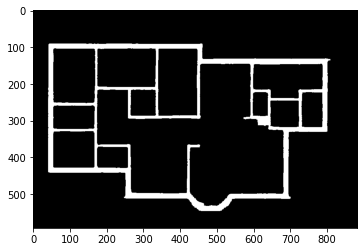

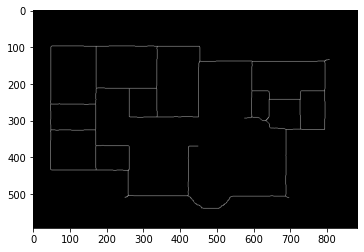

13 contours


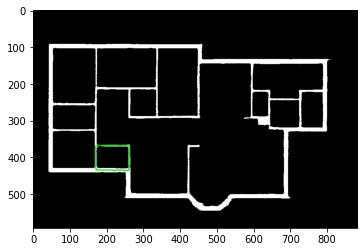

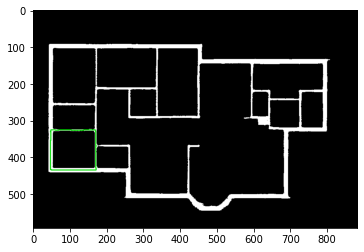

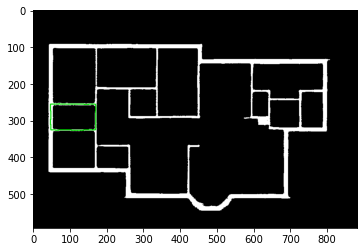

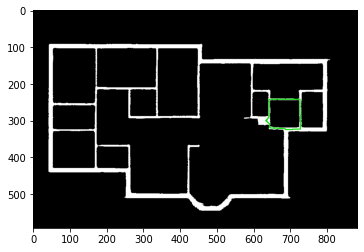

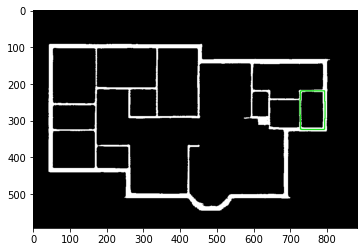

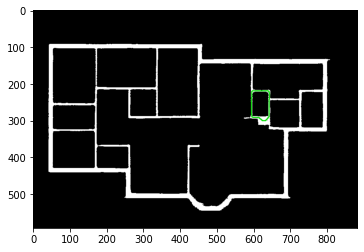

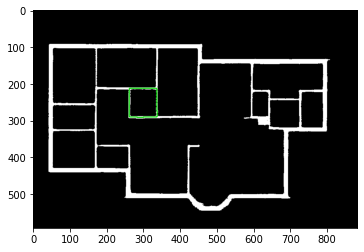

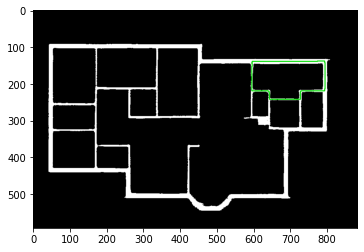

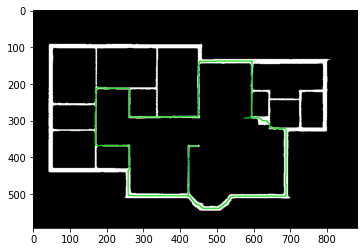

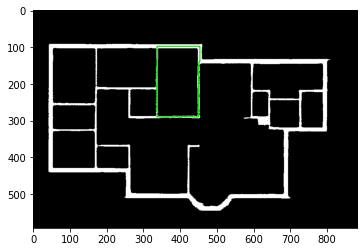

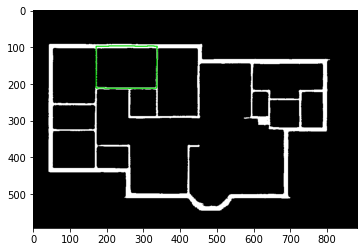

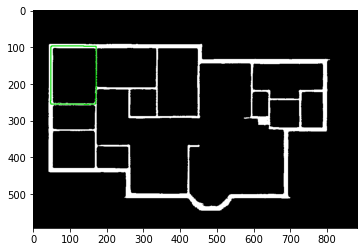

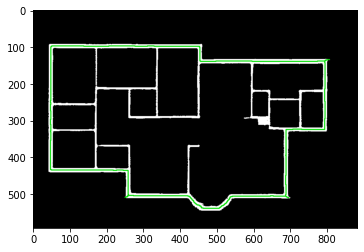

In [13]:
img = cv.imread("walls.png", cv.IMREAD_GRAYSCALE)
wallPixels = (cv.threshold(img, 0, 255, cv.THRESH_OTSU)[1])
dilated = cv.dilate(img, np.ones((3, 3)))
plt.imshow(wallPixels, cmap="gray")
print("dilated")
plt.imshow(dilated, cmap="gray")
plt.show()
skeleton = cv.ximgproc.thinning(dilated)

plt.imshow(skeleton, cmap="gray")
plt.show()

wall_cnts, hierarchy = cv.findContours(skeleton, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
im = np.expand_dims(wallPixels, axis=2).repeat(3, axis=2) 
print(len(wall_cnts), 'contours')
for k, cnt in enumerate(wall_cnts):
    new_img = im.copy()
    new_img = cv.drawContours(new_img, wall_cnts, k, (0, 220, 0), 2) 
    plt.imshow(new_img)
    plt.show()
    new_img = im

# im = cv.drawContours(im, wall_cnts, 4, (0, 220, 0), 2) 
# plt.imshow(im)

311.79898953437805
4
CHOSEN


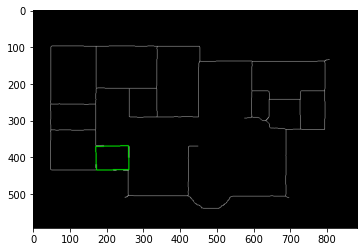

464.6274166107178
4
CHOSEN


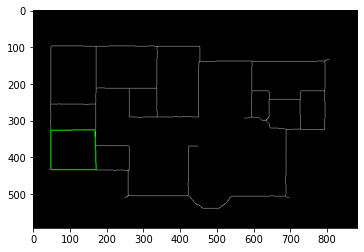

386.04163014888763
4
CHOSEN


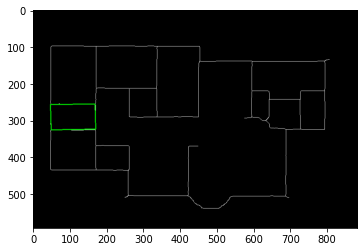

335.2548328638077
5
CHOSEN


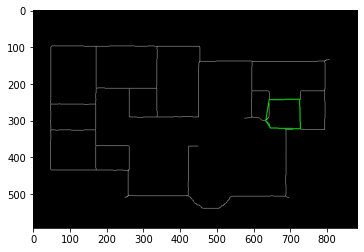

339.55634891986847
4
CHOSEN


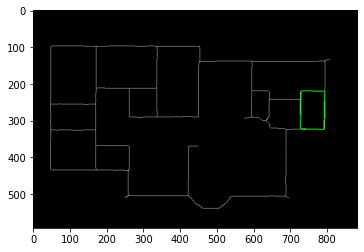

243.01219284534454
4
CHOSEN


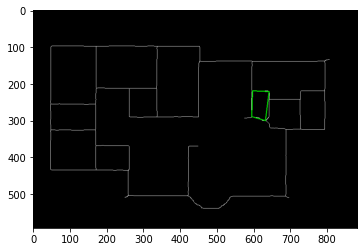

303.55634891986847
4
CHOSEN


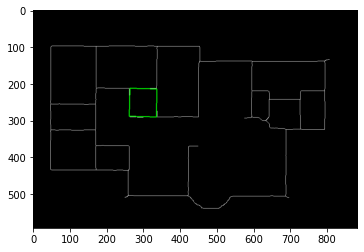

598.0416301488876
8
CHOSEN


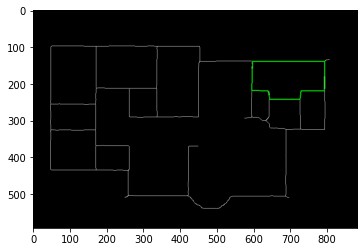

2322.274165391922
23
CHOSEN


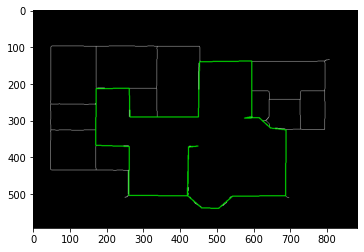

616.2842707633972
4
CHOSEN


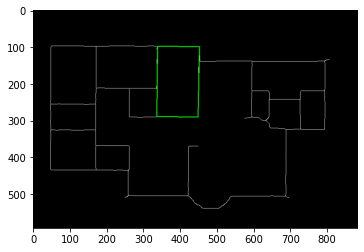

560.0416301488876
4
CHOSEN


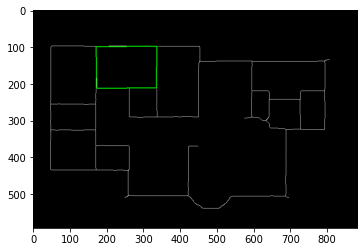

560.8700571060181
4
CHOSEN


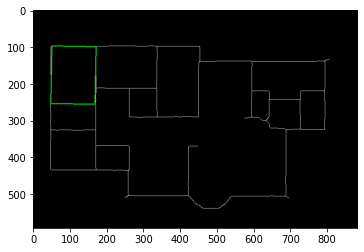

2418.7766921520233
15
CHOSEN


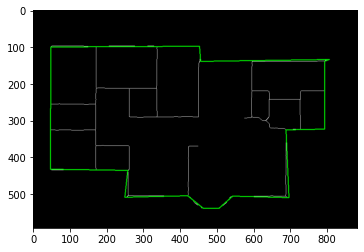

13 new cnts


In [15]:
new_cnts = []
im = np.expand_dims(skeleton, axis=2).repeat(3, axis=2) 
for k, cnt in enumerate(wall_cnts):
    perimeter = cv.arcLength(cnt, True)
    print(perimeter)
    epsilon = 0.01*perimeter
    approx = cv.approxPolyDP(cnt, 10, True)
    new_img = im.copy()
    new_img = cv.drawContours(new_img, (approx, ), 0, (0, 220, 0), 2) 
    print(len(approx))
    if perimeter > 50:
        print('CHOSEN')
        new_cnts.append(approx)
    plt.imshow(new_img)
    plt.show()

print(len(new_cnts), 'new cnts')
# new_cnts = new_cnts[:-1]


In [16]:
import numpy as np

def drawContours(conts, i):
    a = conts[:]
    for j, c in enumerate(a):
        a[j] = c.reshape((a[j].shape[0], 1, 2)).astype(np.int32)

    im = np.expand_dims(wallPixels, axis=2).repeat(3, axis=2) 
    im = cv.drawContours(im, new_cnts, i, (0, 230, 255), 6) # original
    im = cv.drawContours(im, a, i, (255, 0, 0), 2) # optimized

    for p in a[i]:
        im = cv.circle(im, p[0], 5, (255, 0, 0), 5)

    plt.figure(figsize = (15,15))
    plt.imshow(im)
    plt.show()
    

def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def conditionA(p1, p2, delta=0):
    return distance(p1, p2) < delta
    
def checkConditionA(points):
    for i in range(len(points)-1):
        if conditionA(points[i], points[i+1]):
            return True
    return False

def checkConditionB(points):
    for i in range(len(points)-2):
        if conditionB(points[i], points[i+1], points[i+2]):
            return True
    return False

def conditionB(p0, p1, p2, delta=np.cos(np.radians(10))):
    if np.linalg.norm(p1 - p0) == 0 or np.linalg.norm(p2 - p1) == 0:
        return False # HACK: this might happen because, it is fixed on the wall step
    return np.abs(cos_sim(p1 - p0, p2 - p1)) > delta

def simplifyPolygon(p):
    p = np.copy(p)
    
    # a
    redo = True
    while redo:
        redo = False
        for i in range(len(p)-1):  
            if conditionA(p[i], p[i+1]):
                p[i] = (p[i] + p[i+1])/2
                p = np.delete(p, i+1, 0)
                redo = True
                break
    
    # b
    redo = True
    while redo:
        redo =  False
        for i in range(len(p)-2):
            if conditionB(p[i], p[i+1], p[i+2]):
                print(p[i], p[i+1], p[i+2])
                p = np.delete(p, i+1, 0)
                redo = True
                break
    return p

In [18]:
final = list(new_cnts)
for i, c in enumerate(final):
    final[i] = c.reshape((c.shape[0], 2)).astype(np.float32)

# Room contour optimization
# for i, _ in enumerate(final):
#     print(i)
#     drawContours(final, i)
#     while checkConditionA(final[i]) or checkConditionB(final[i]):
#         # TODO: optimize...
#         final[i] = simplifyPolygon(final[i])
#         drawContours(final, i)


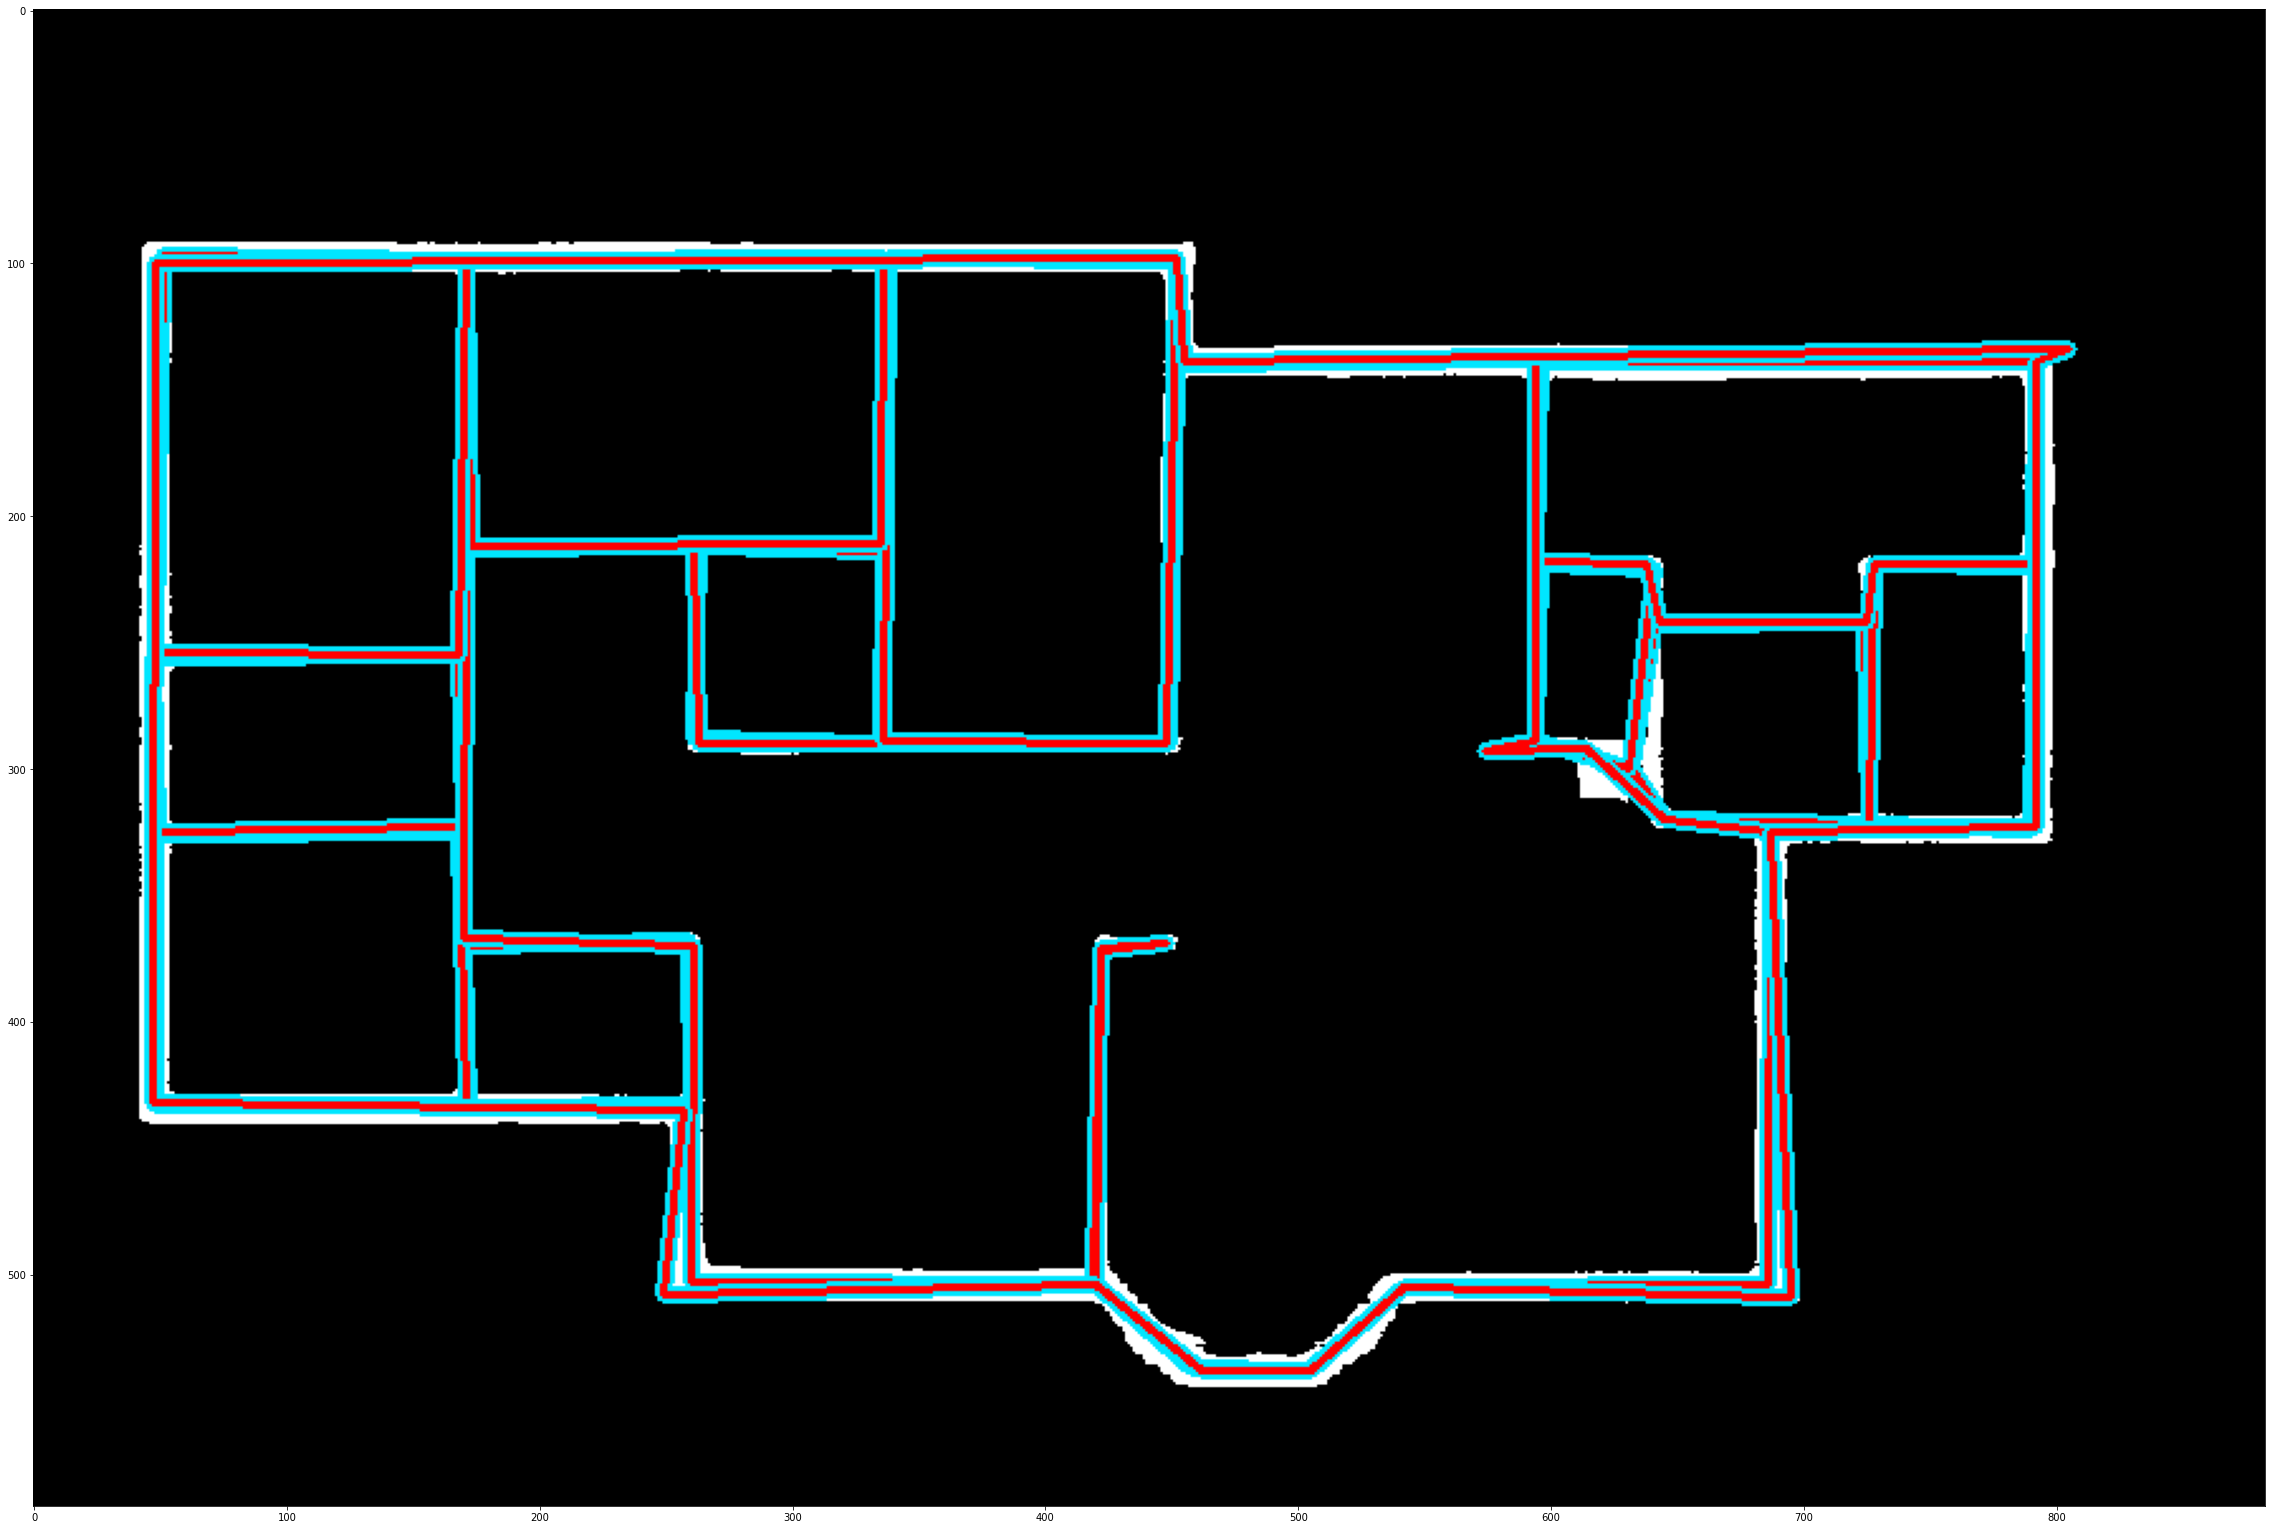

In [19]:
a = final[:]
for i, c in enumerate(a):
    a[i] = c.reshape((a[i].shape[0], 1, 2)).astype(np.int32)

im = np.expand_dims(wallPixels, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(new_cnts): # used to be wall_cnts
    im = cv.drawContours(im, new_cnts, k, (0, 230, 255), 6) # original
    im = cv.drawContours(im, a, k, (255, 0, 0), 2) # optimized
plt.figure(figsize = (40,40))
plt.imshow(im)

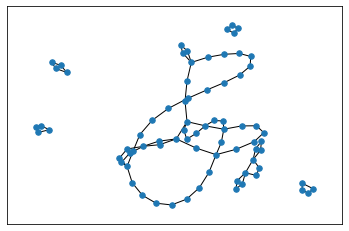

In [20]:
import networkx as nx

G = nx.Graph()
for polygon in final:
    G.add_node(tuple(polygon[0]))
    for v in range(len(polygon) - 1):
        G.add_node(tuple(polygon[v+1]))
        G.add_edge(tuple(polygon[v]), tuple(polygon[v+1]))
    G.add_edge(tuple(polygon[-1]), tuple(polygon[0]))
    
nx.draw_networkx(G, with_labels = False, node_size = 30)
plt.show()

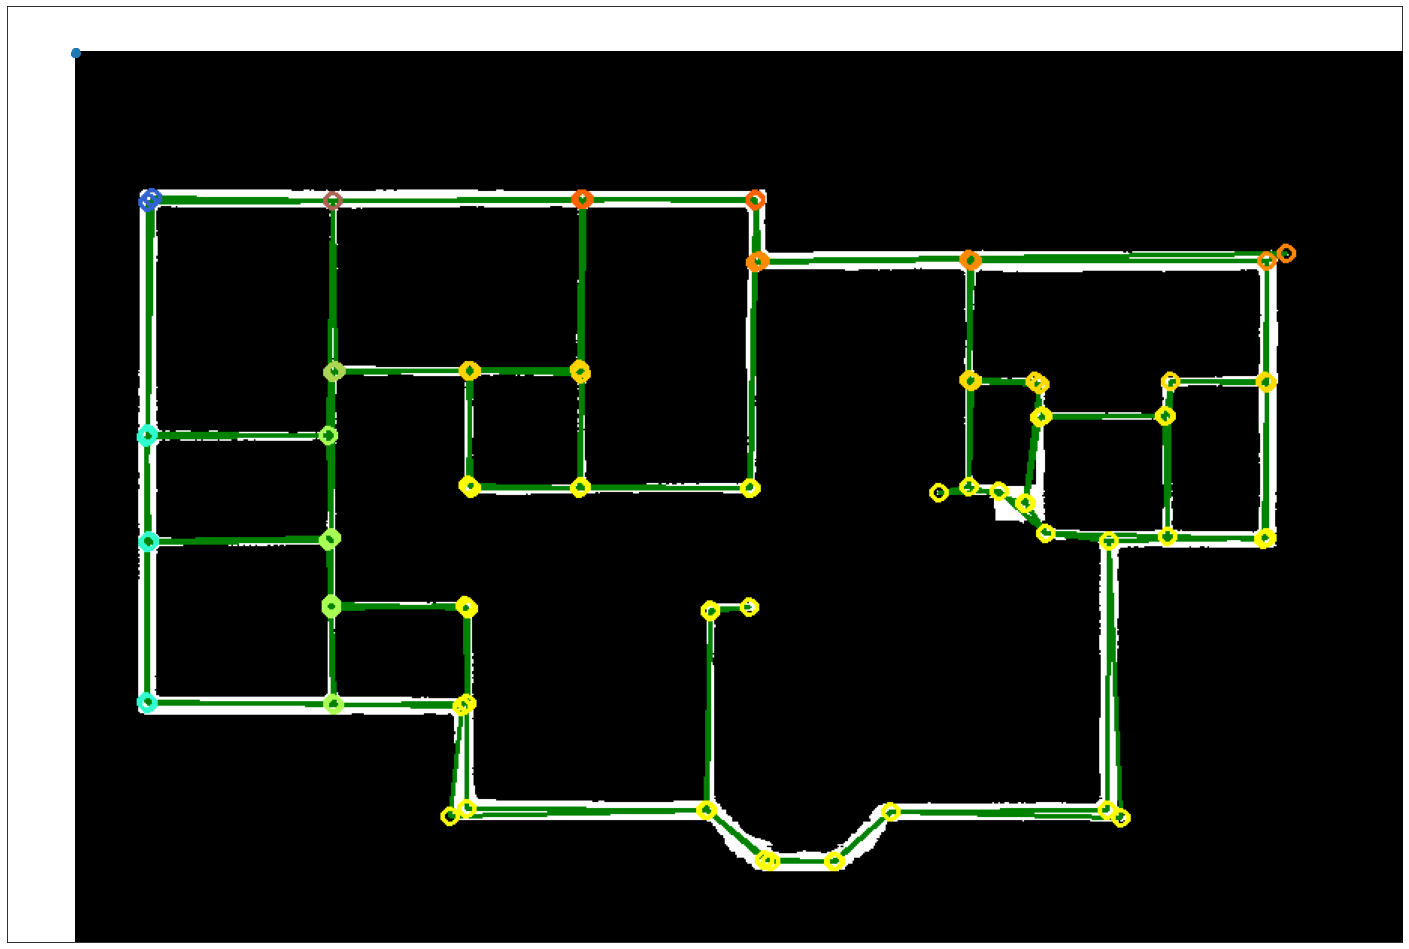

condition x: (170.0, 370.0) (170.0, 367.0)


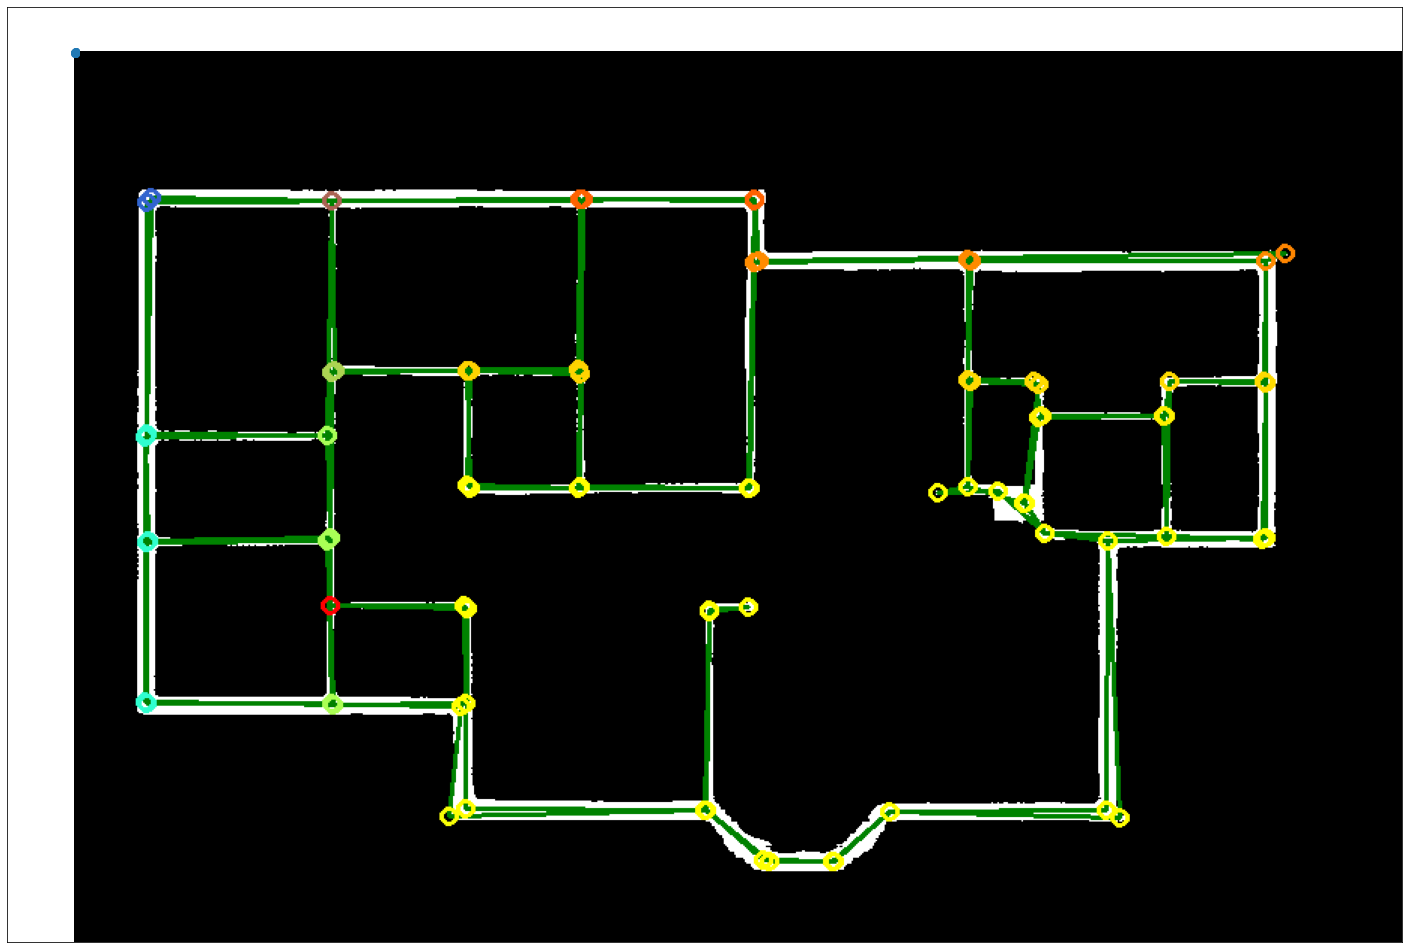

condition x: (259.0, 368.0) (261.0, 370.0)


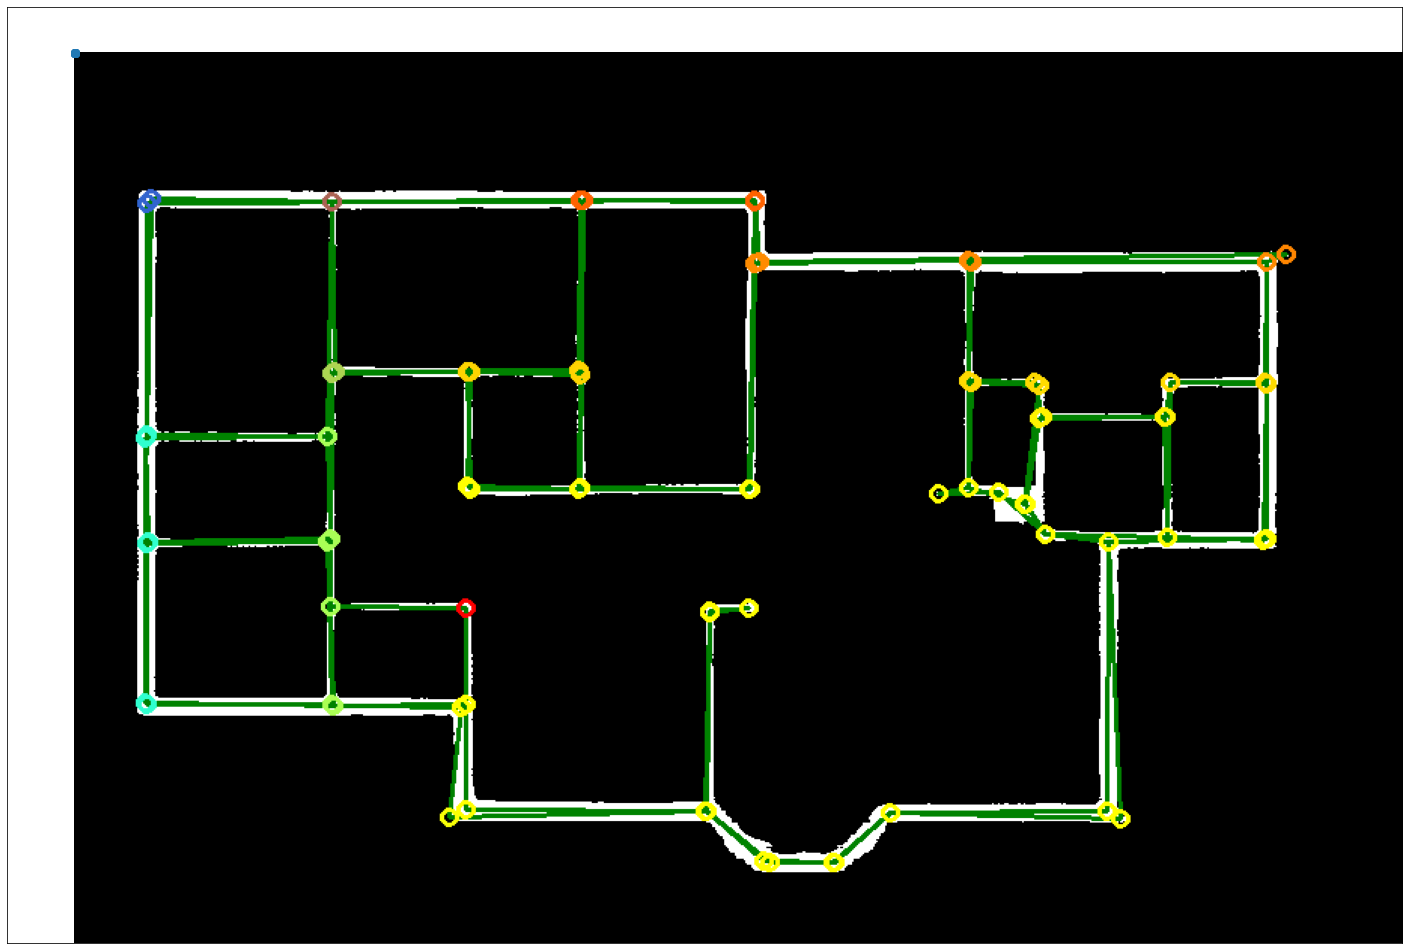

condition x: (260.0, 433.0) (257.0, 435.0)


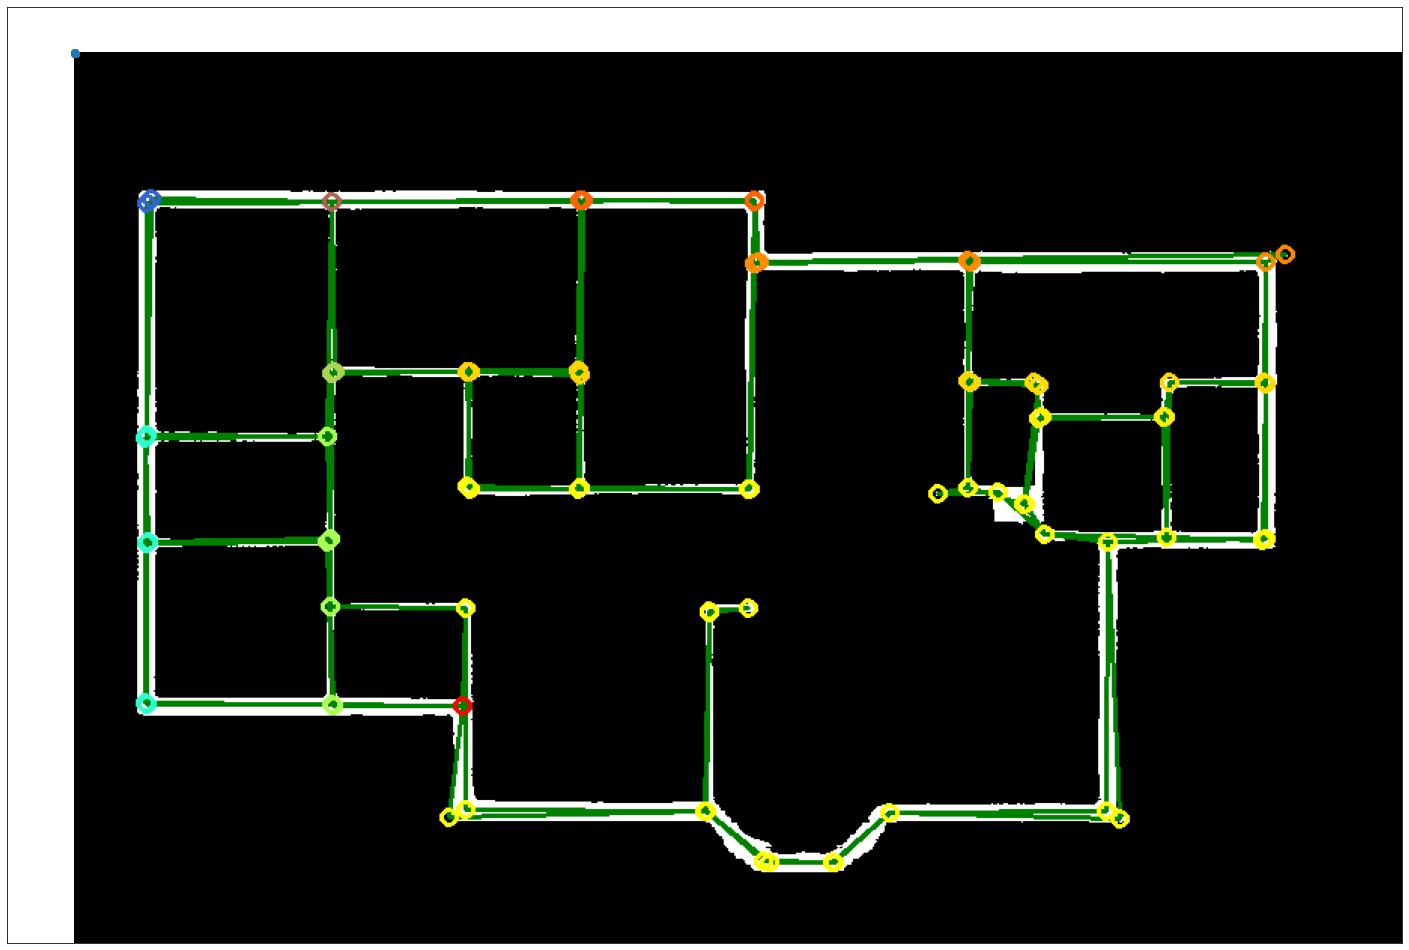

condition x: (172.0, 434.0) (171.0, 433.0)


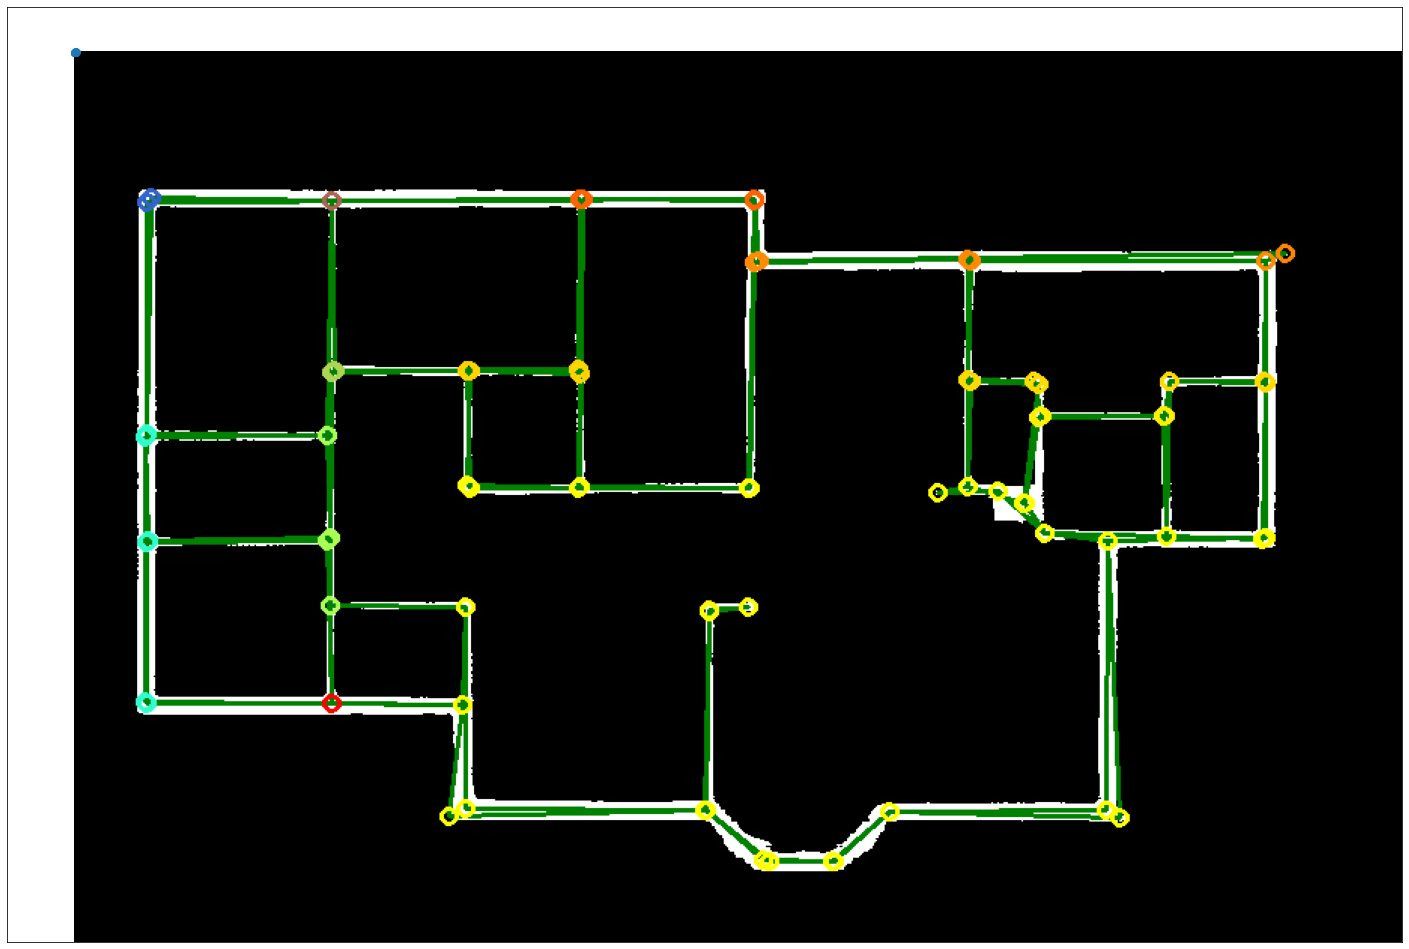

condition x: (48.0, 326.0) (49.0, 325.0)


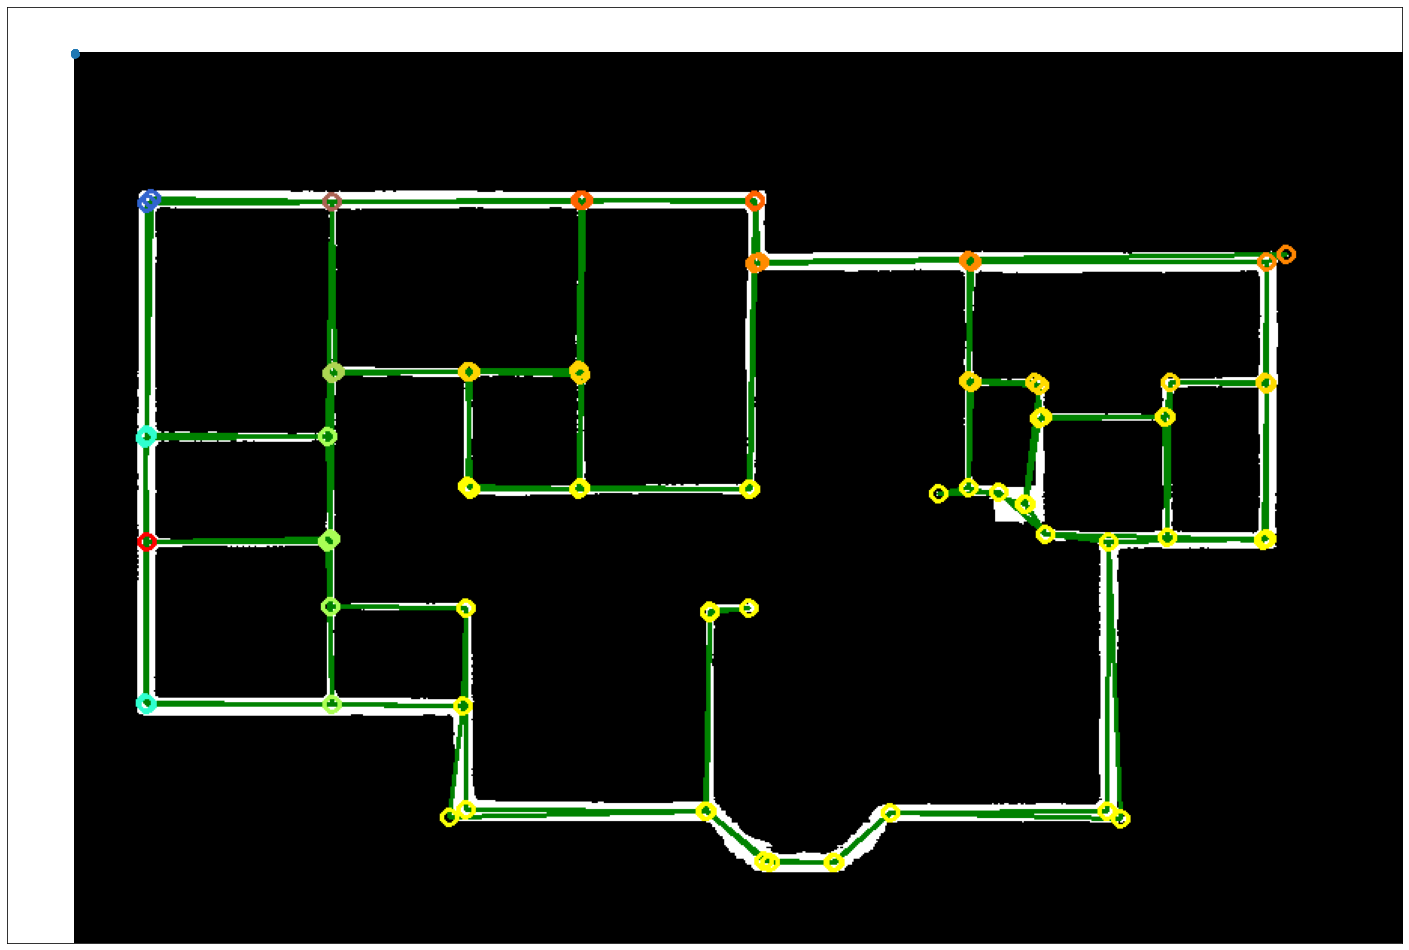

condition x: (168.0, 325.0) (170.0, 323.0)


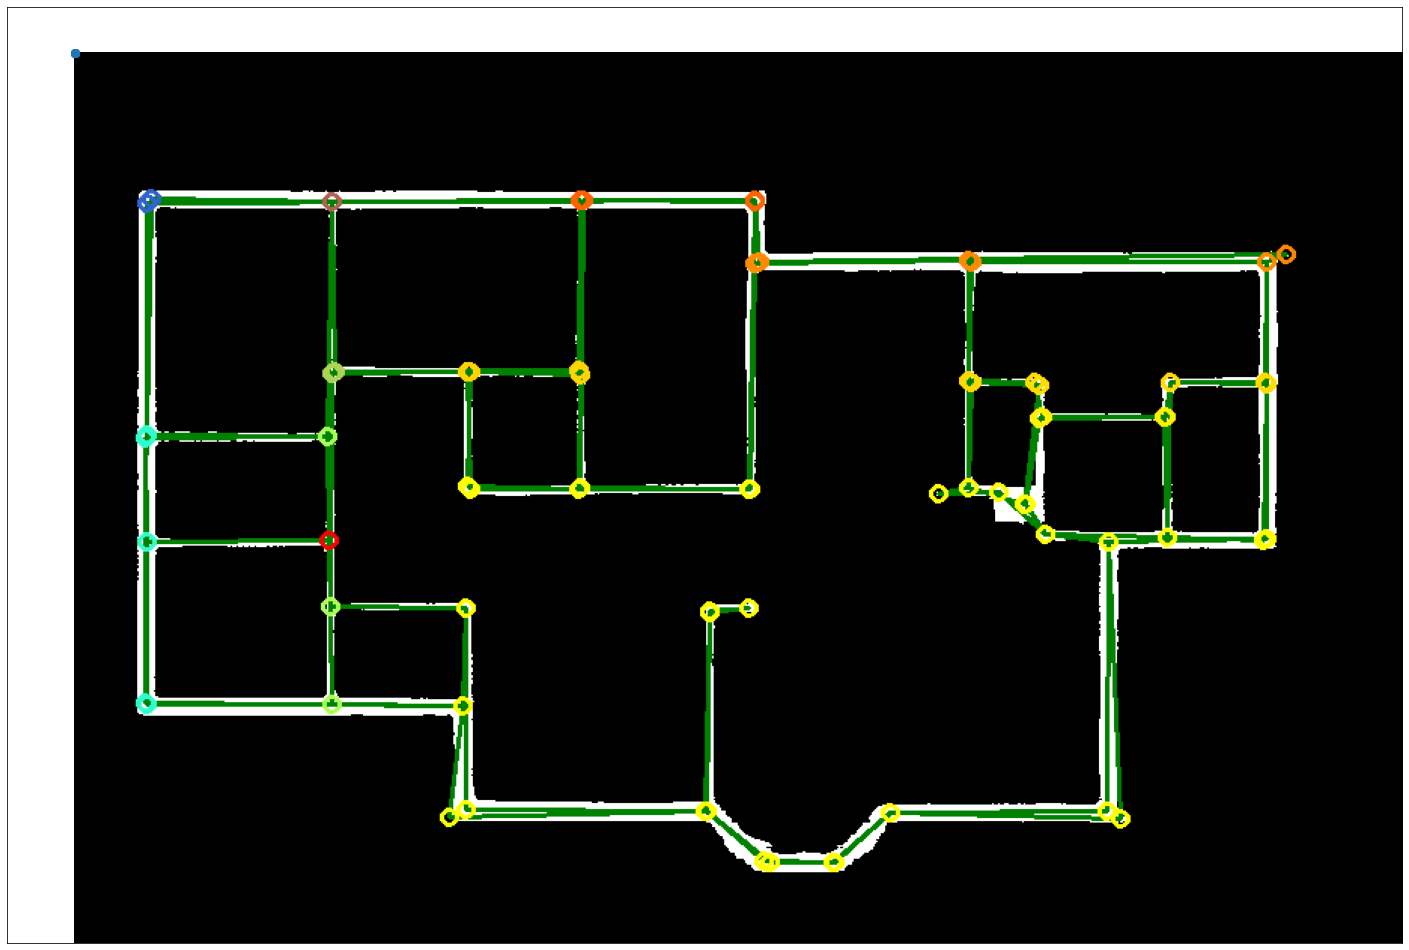

condition x: (48.0, 433.0) (47.0, 432.0)


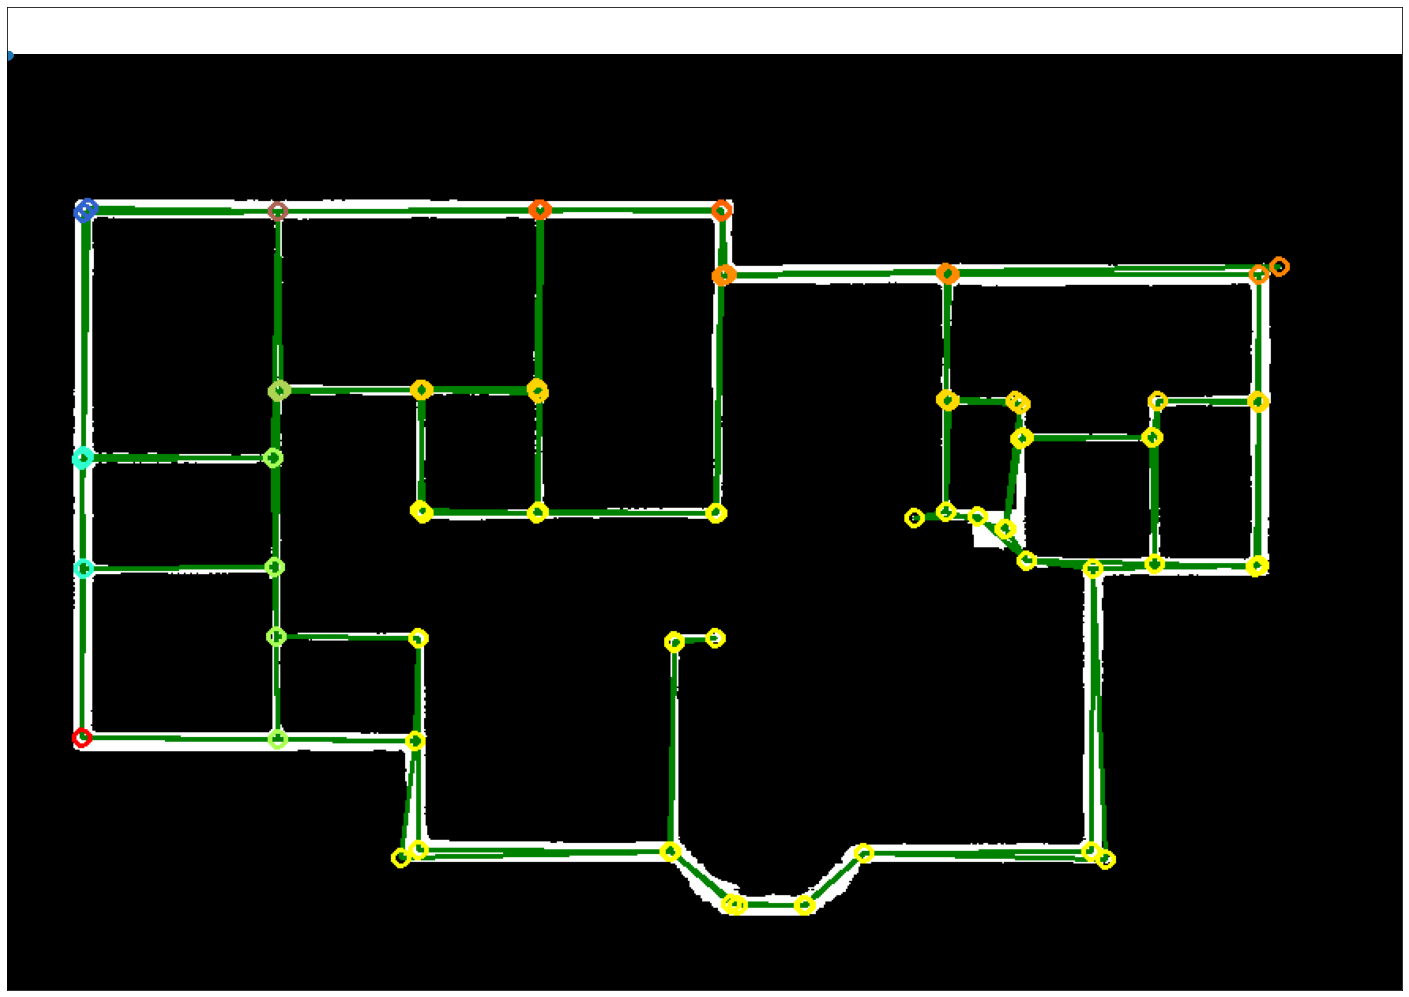

condition x: (47.0, 256.0) (48.0, 254.0)


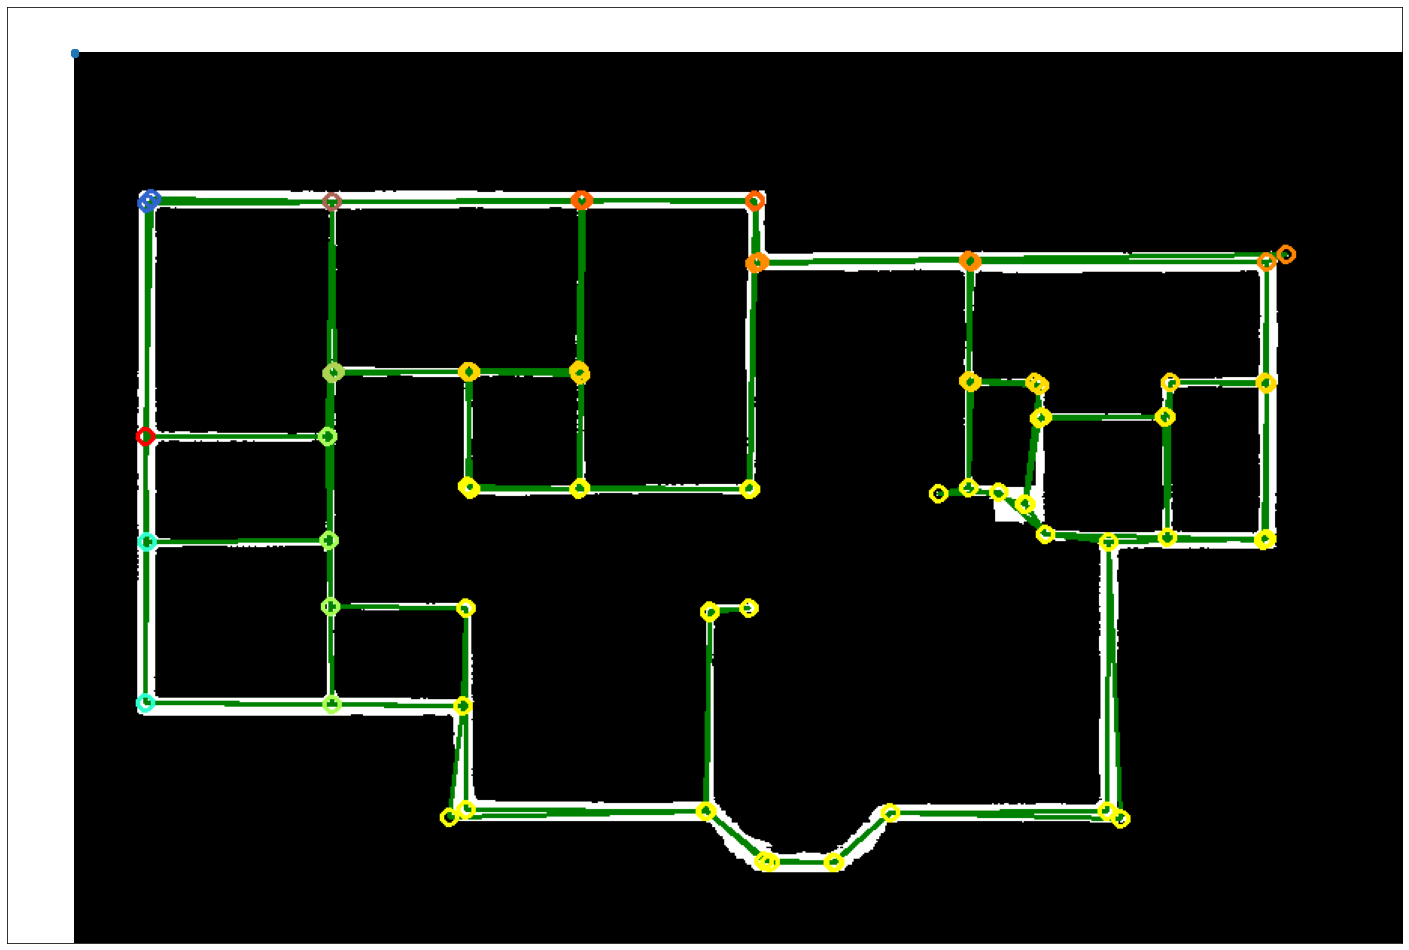

condition x: (641.0, 243.0) (641.0, 221.0)


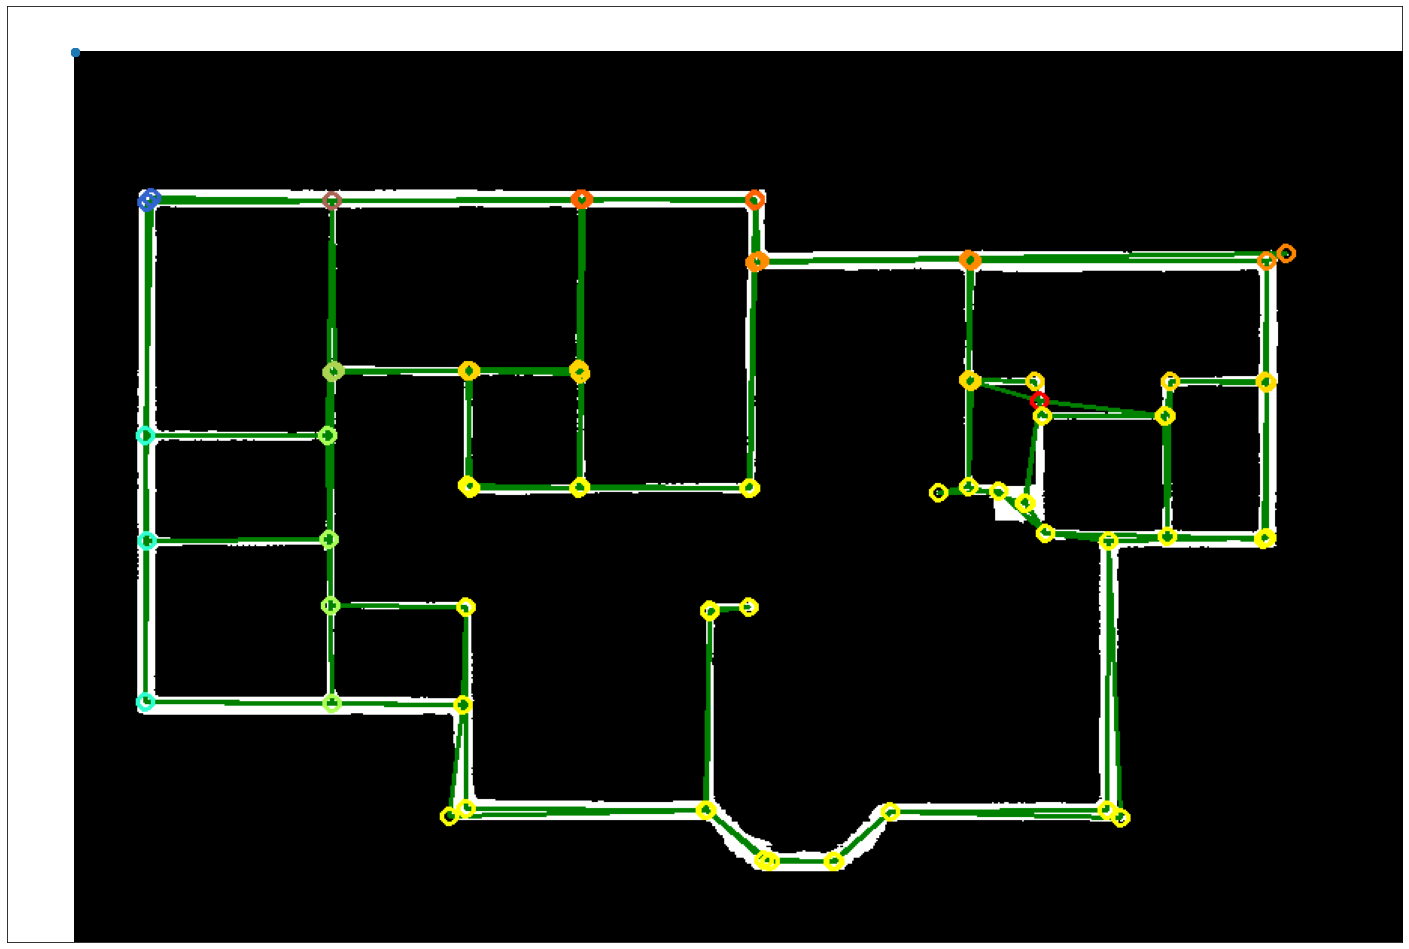

condition x: (641.0, 232.0) (643.0, 242.0)


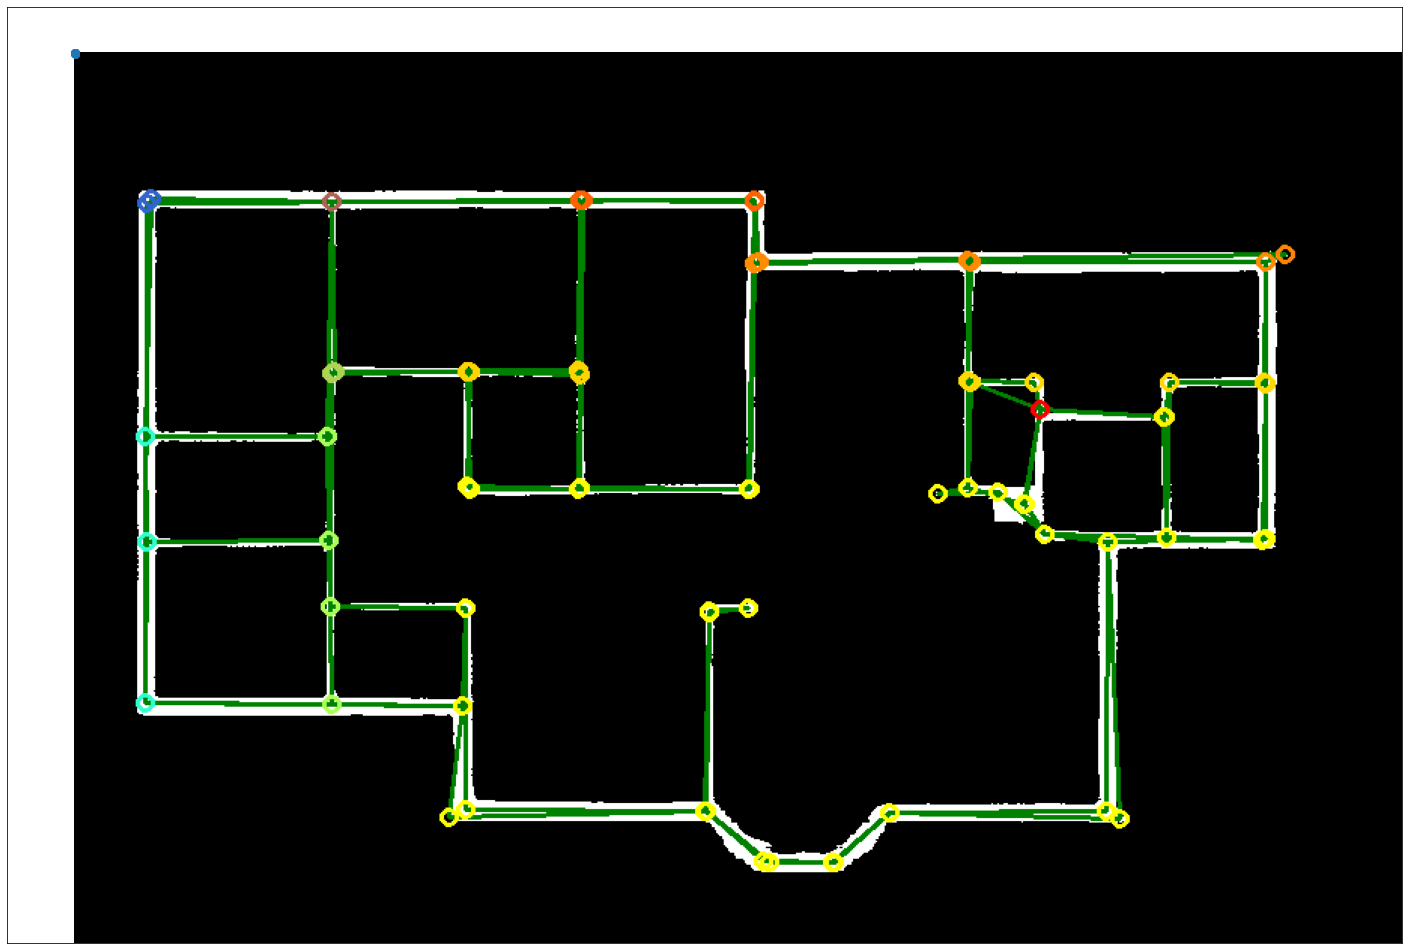

condition x: (642.0, 237.0) (638.0, 219.0)


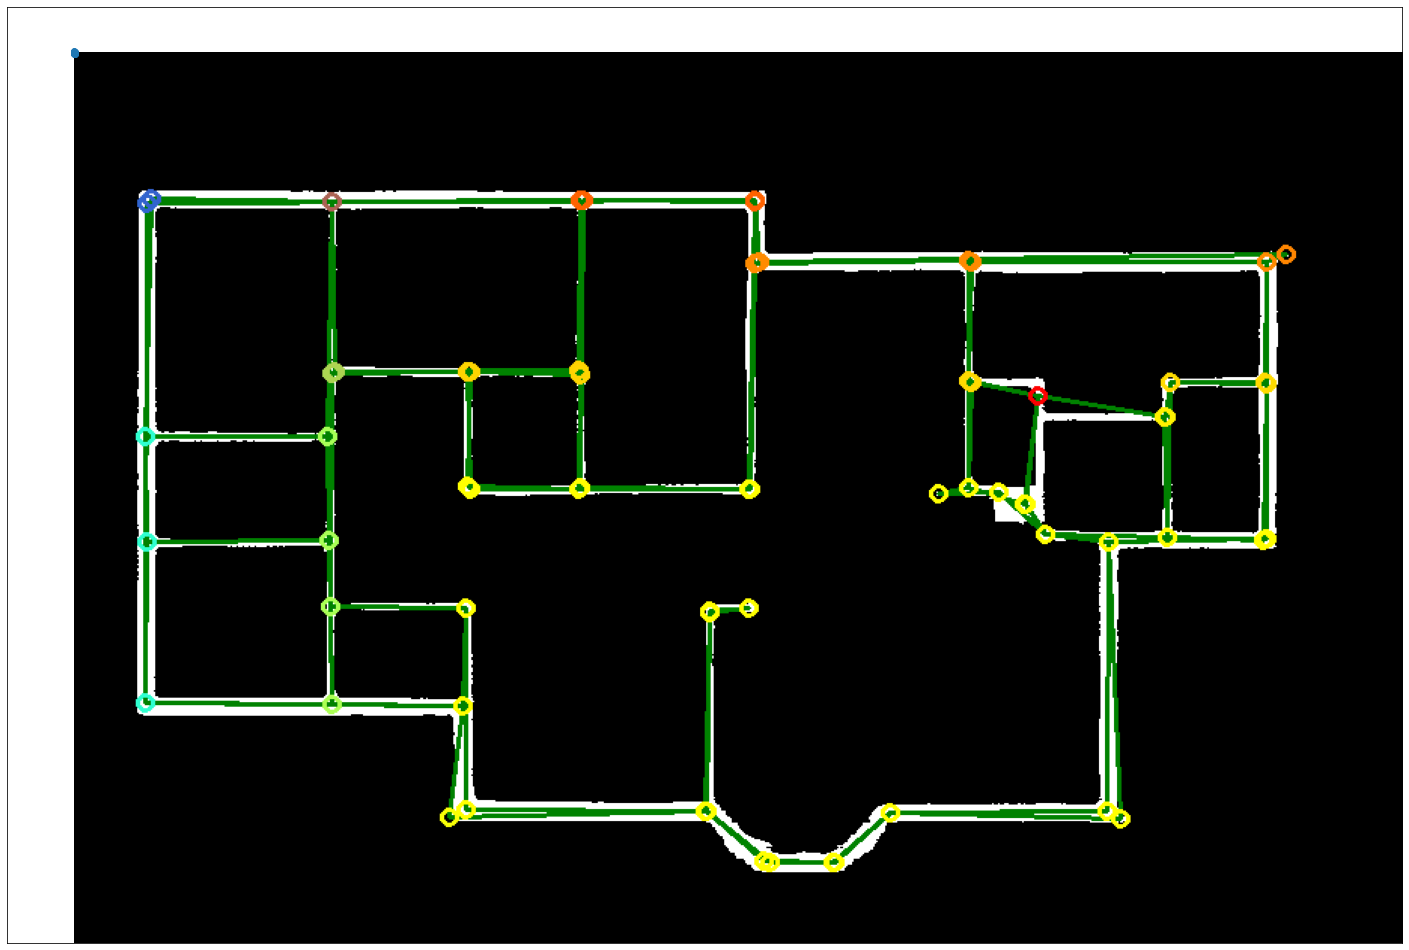

condition x: (724.0, 242.0) (728.0, 219.0)


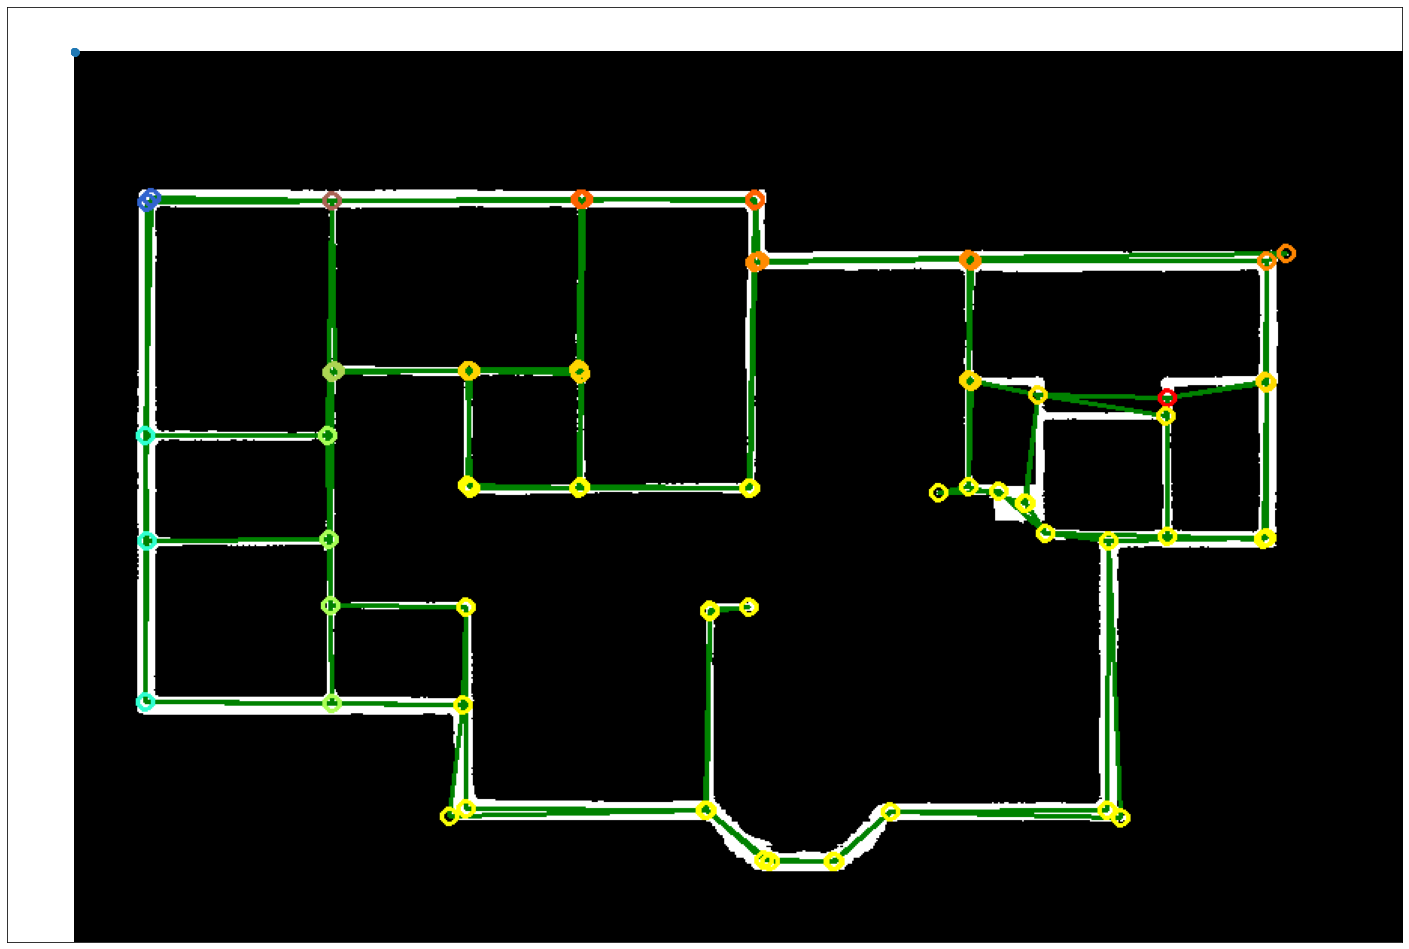

condition x: (726.0, 230.5) (725.0, 242.0)


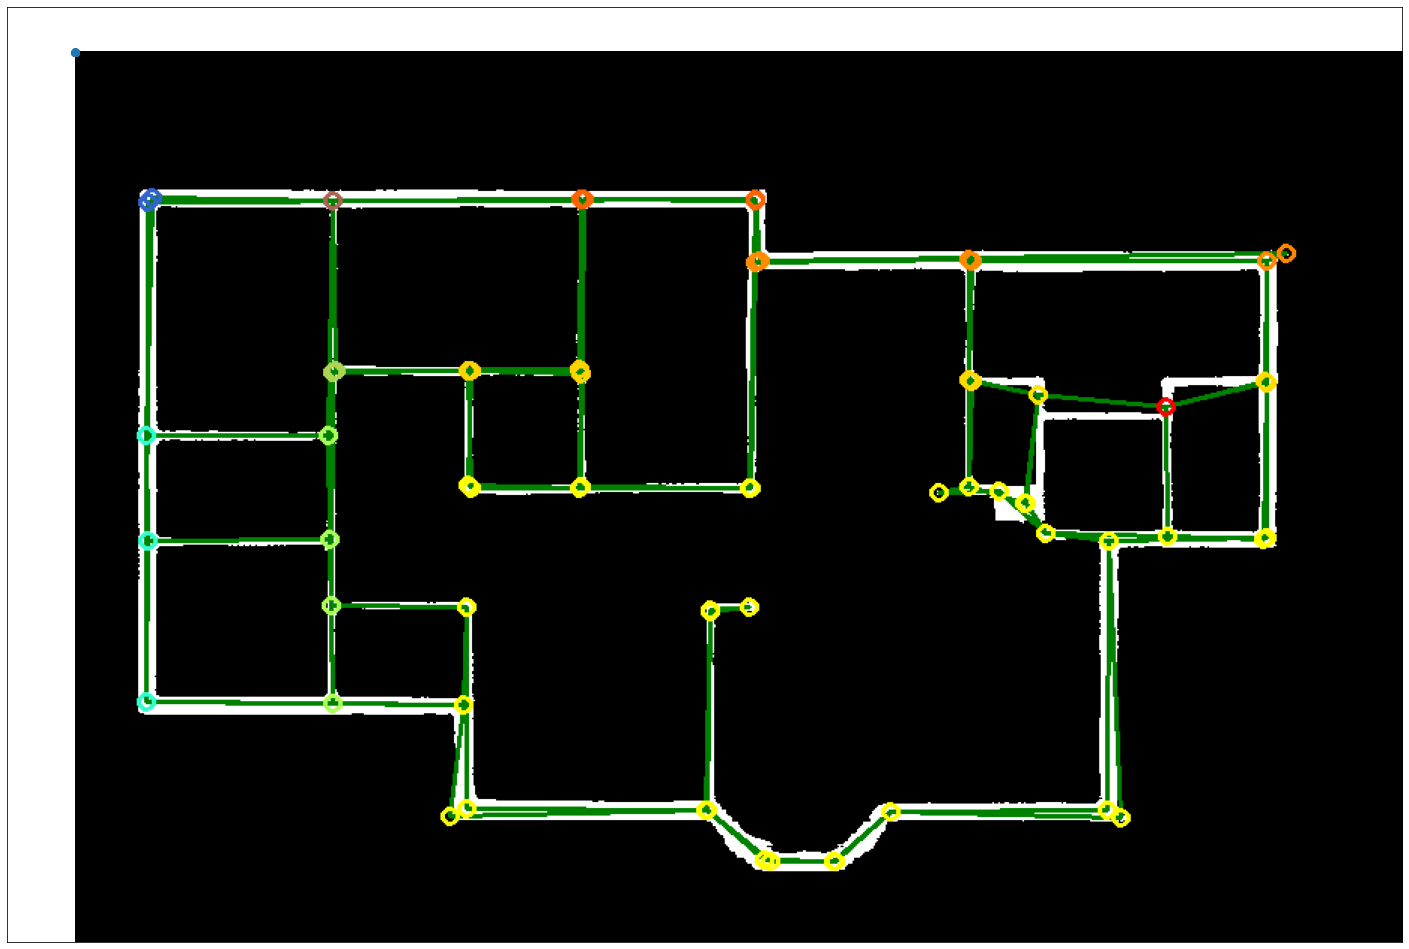

condition x: (645.0, 320.0) (632.0, 300.0)


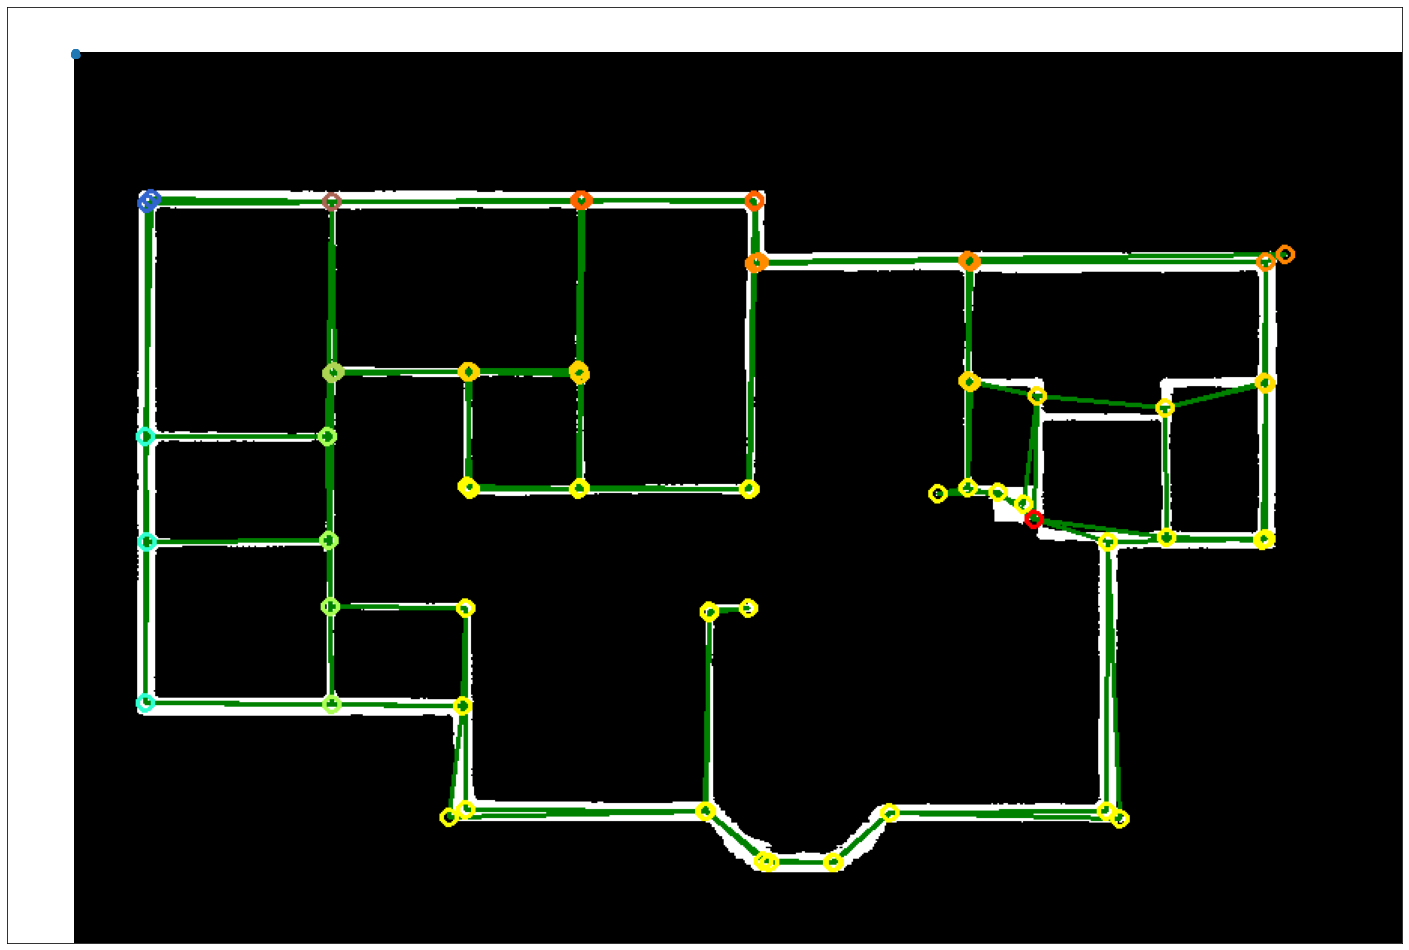

condition x: (638.5, 310.0) (631.0, 300.0)


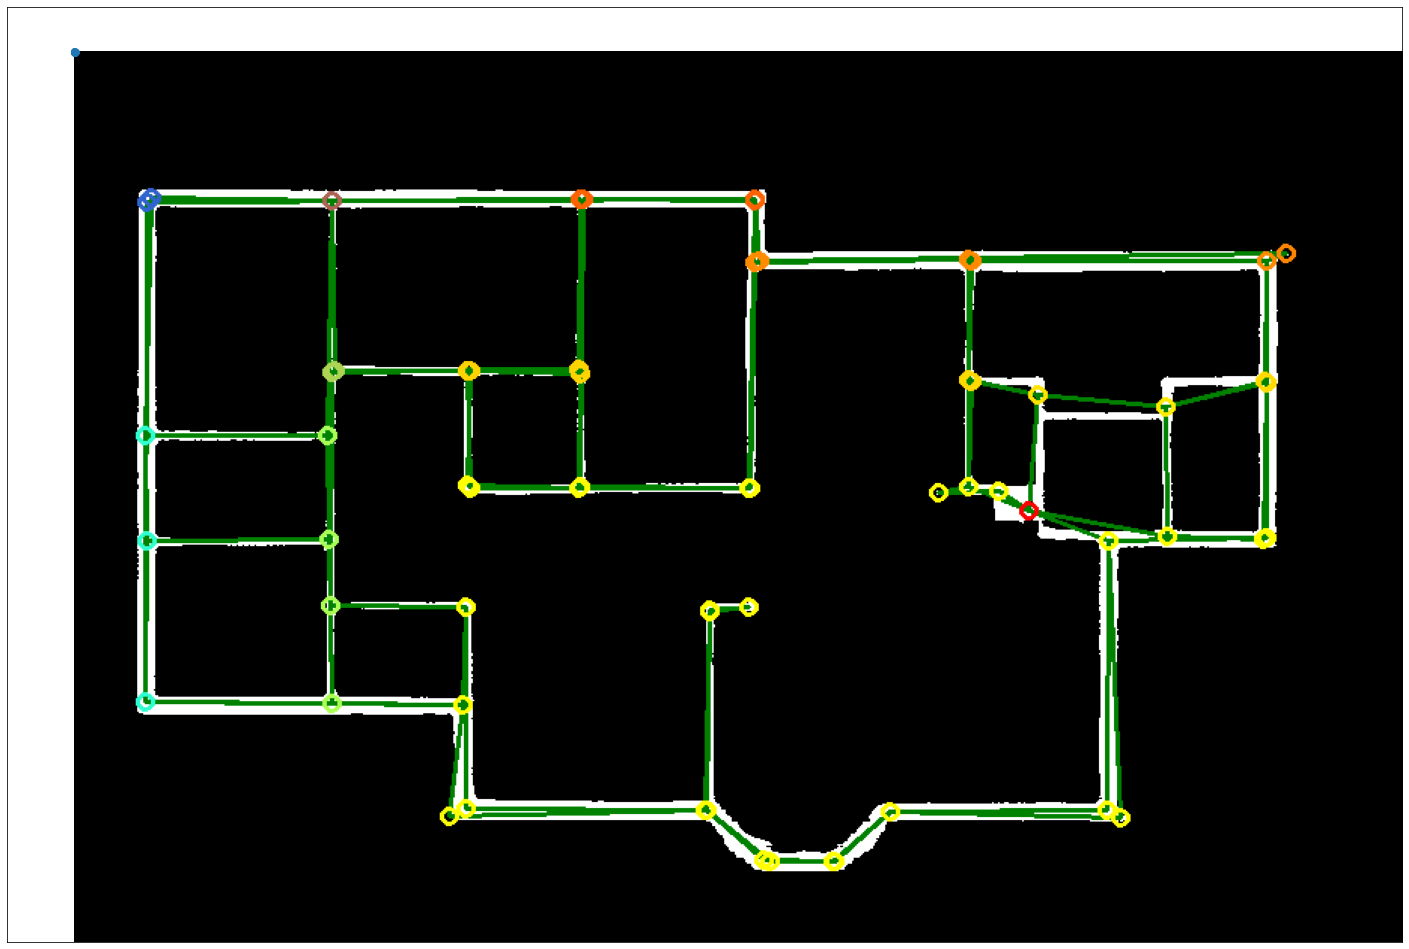

condition x: (634.75, 305.0) (614.0, 292.0)


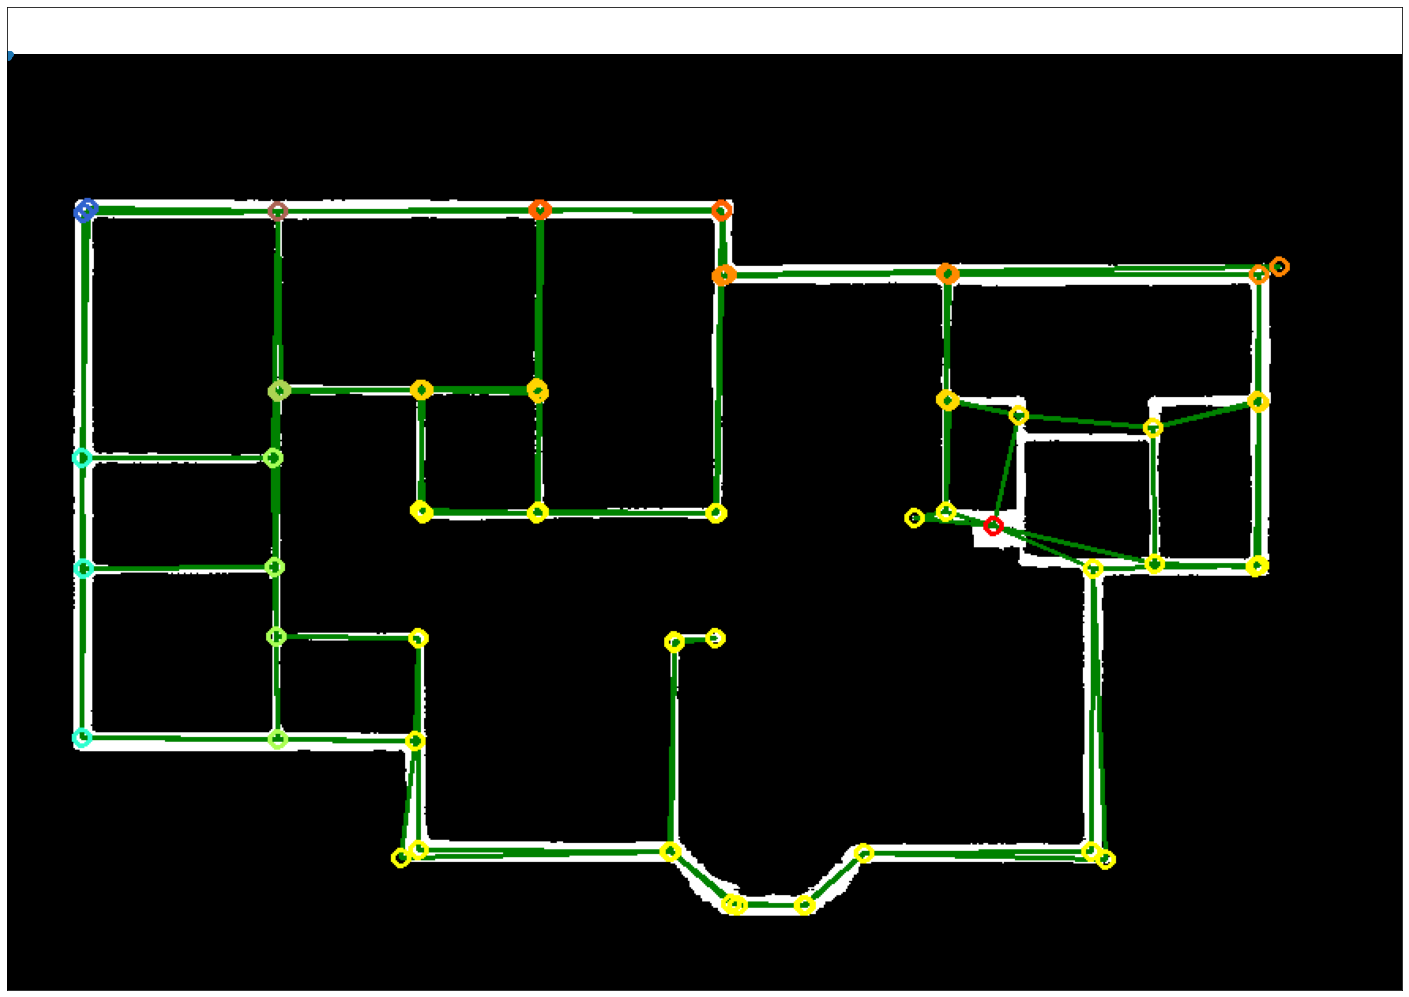

condition x: (792.0, 220.0) (791.0, 219.0)


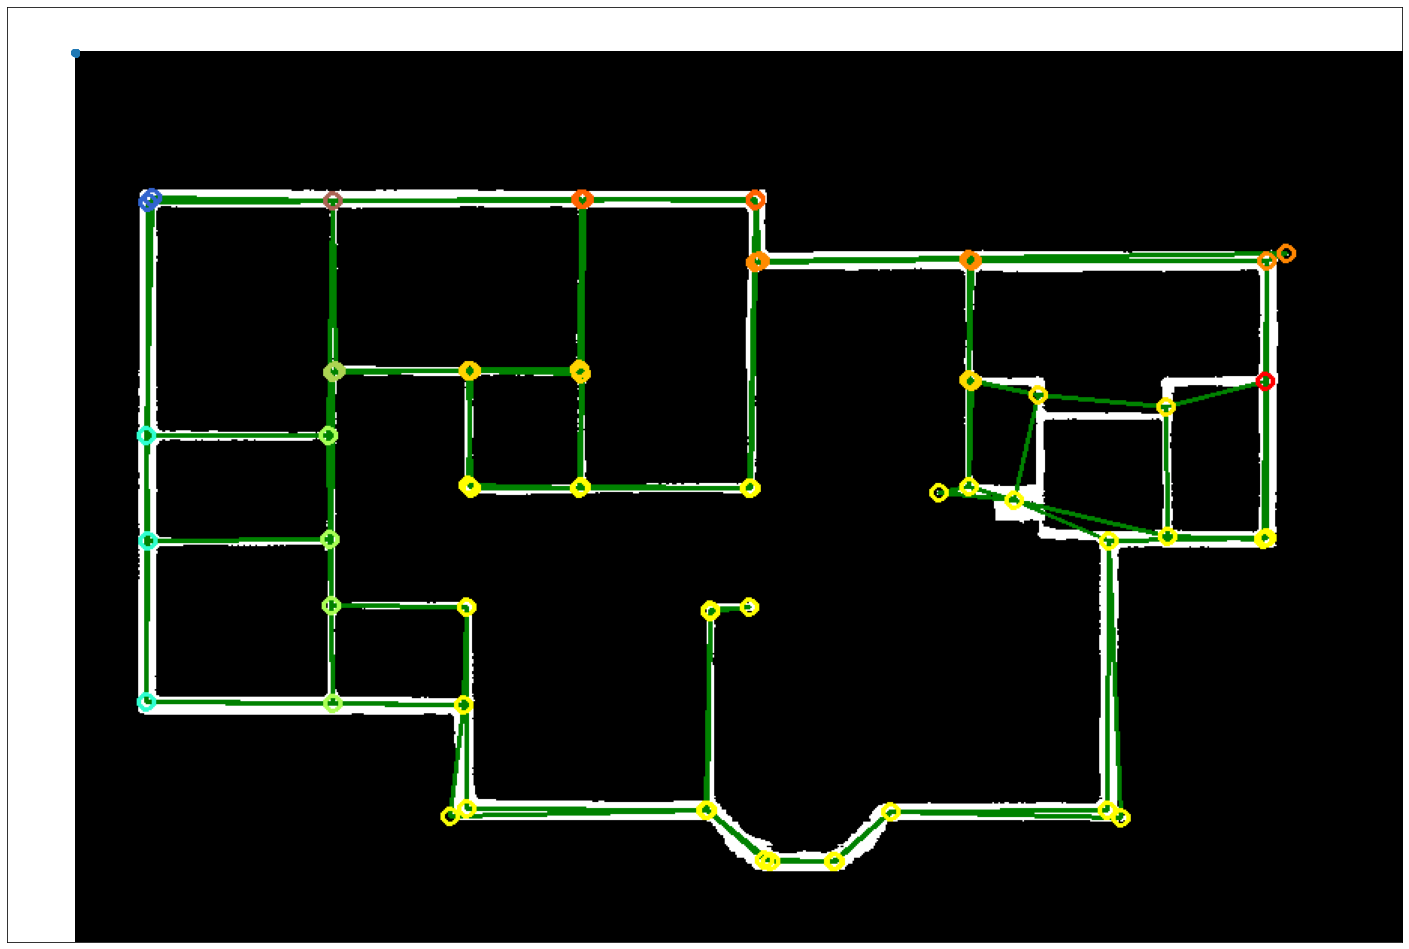

condition x: (790.0, 324.0) (792.0, 323.0)


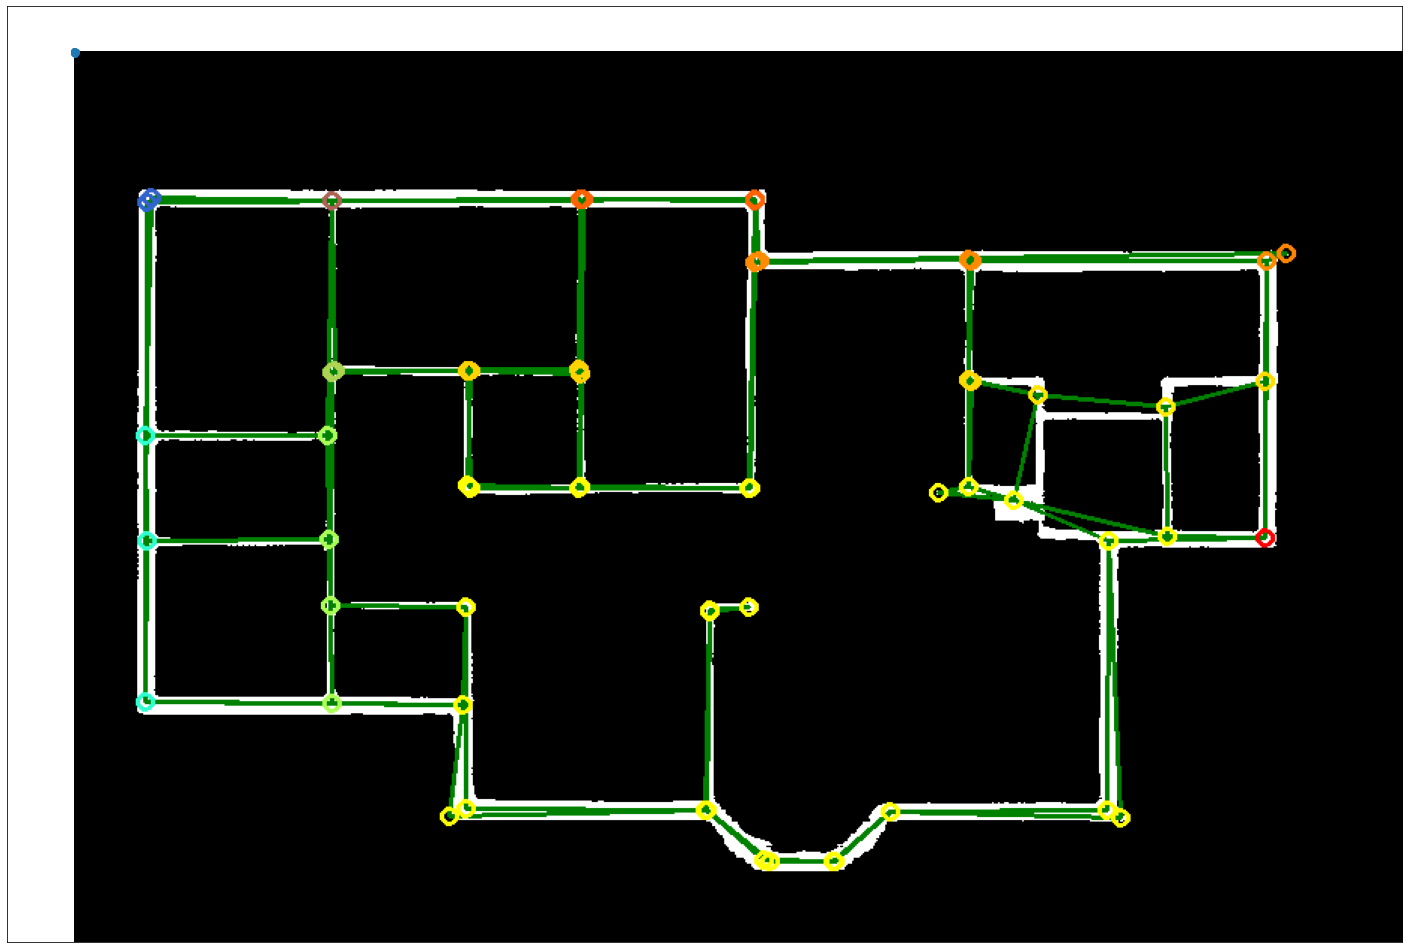

condition x: (596.0, 219.0) (594.0, 218.0)


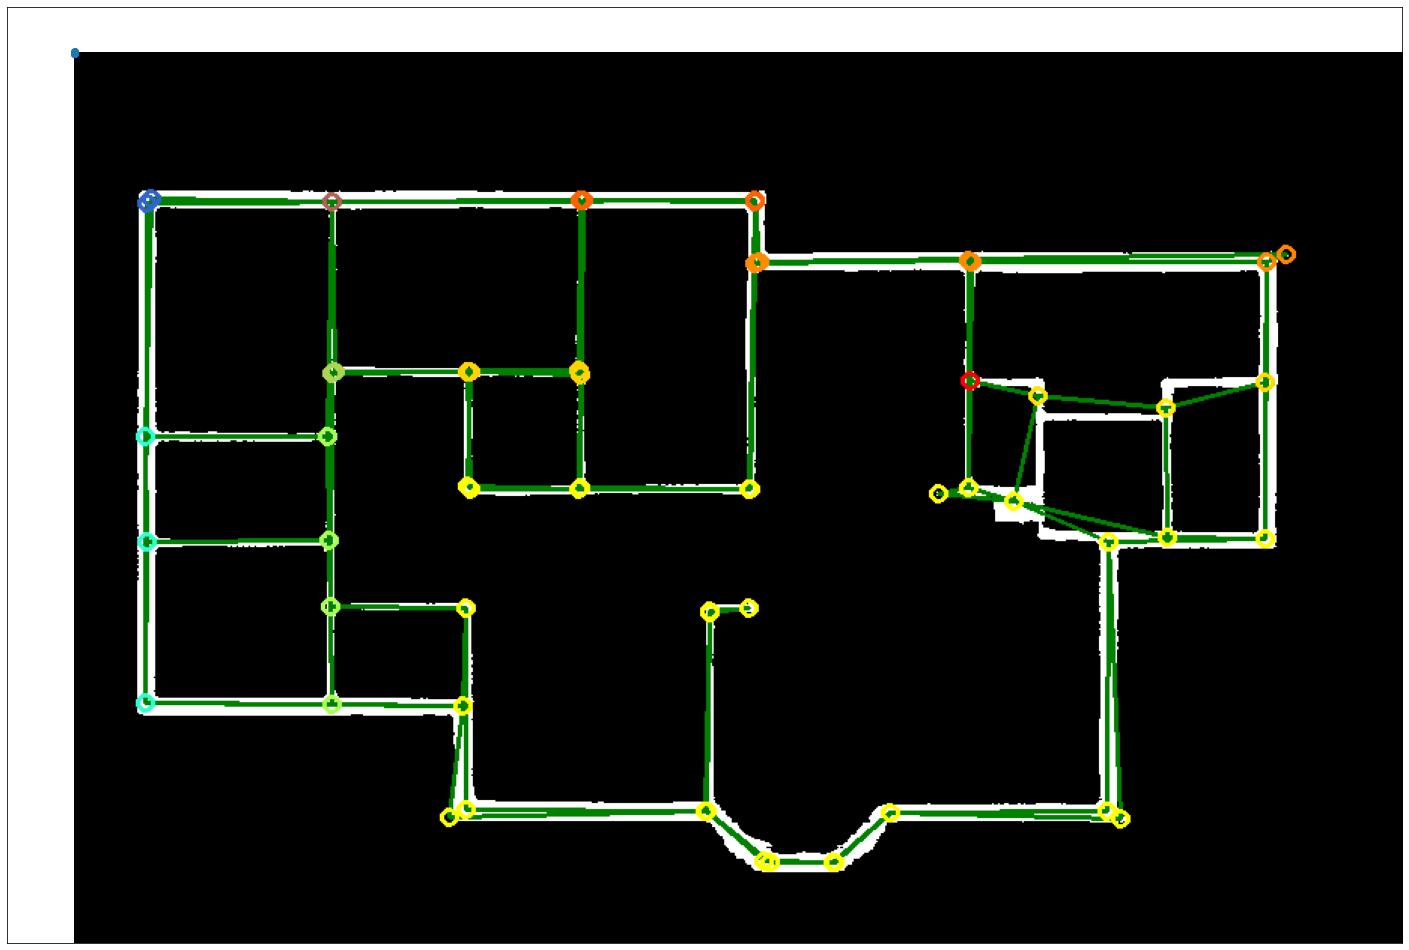

condition x: (594.0, 289.0) (574.0, 293.0)


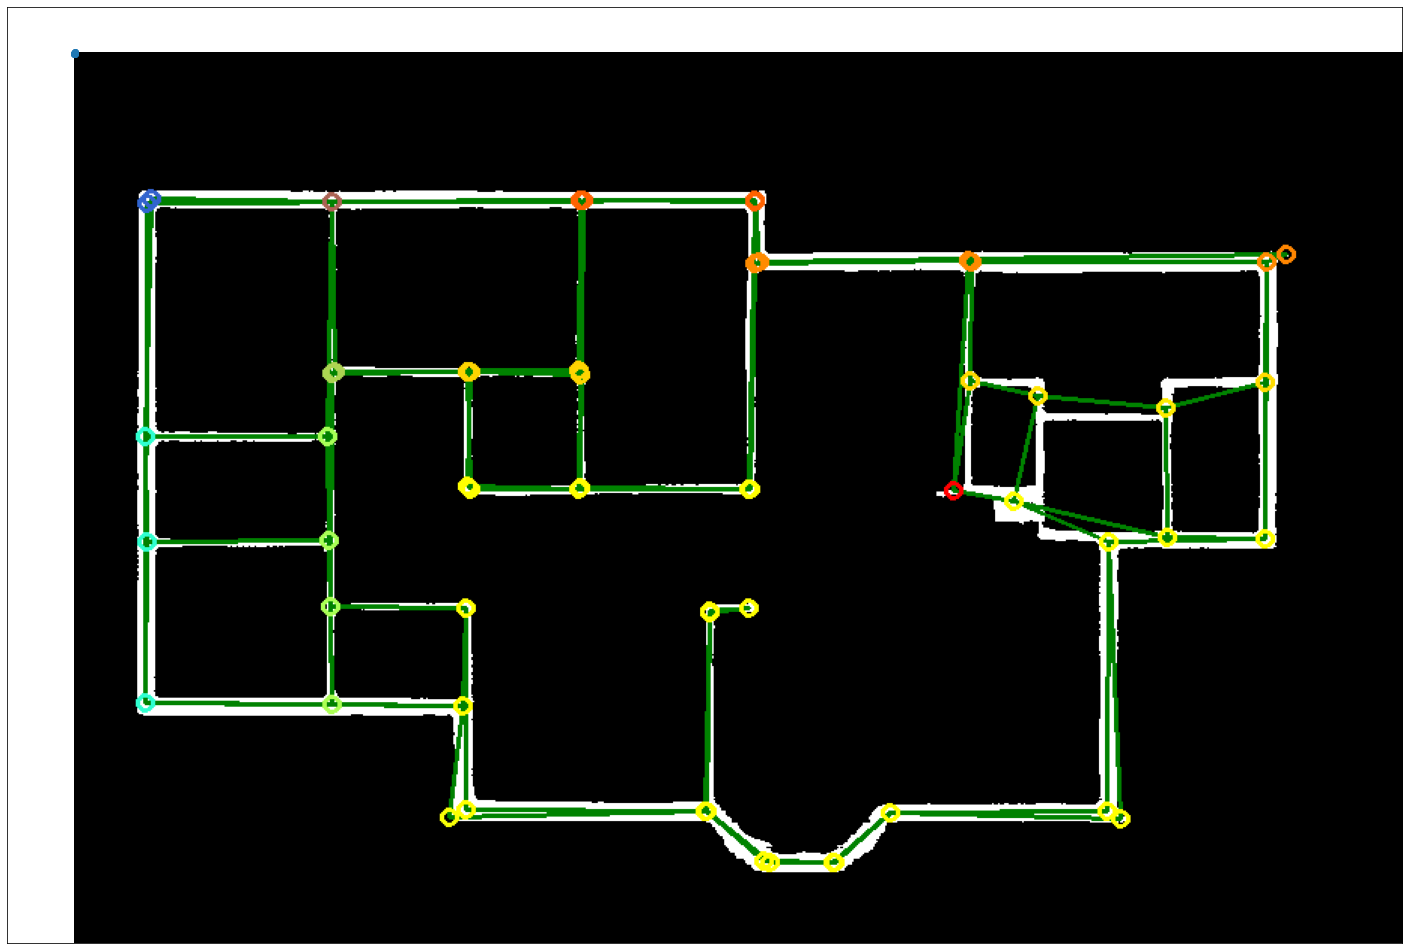

condition x: (263.0, 212.0) (261.0, 212.0)


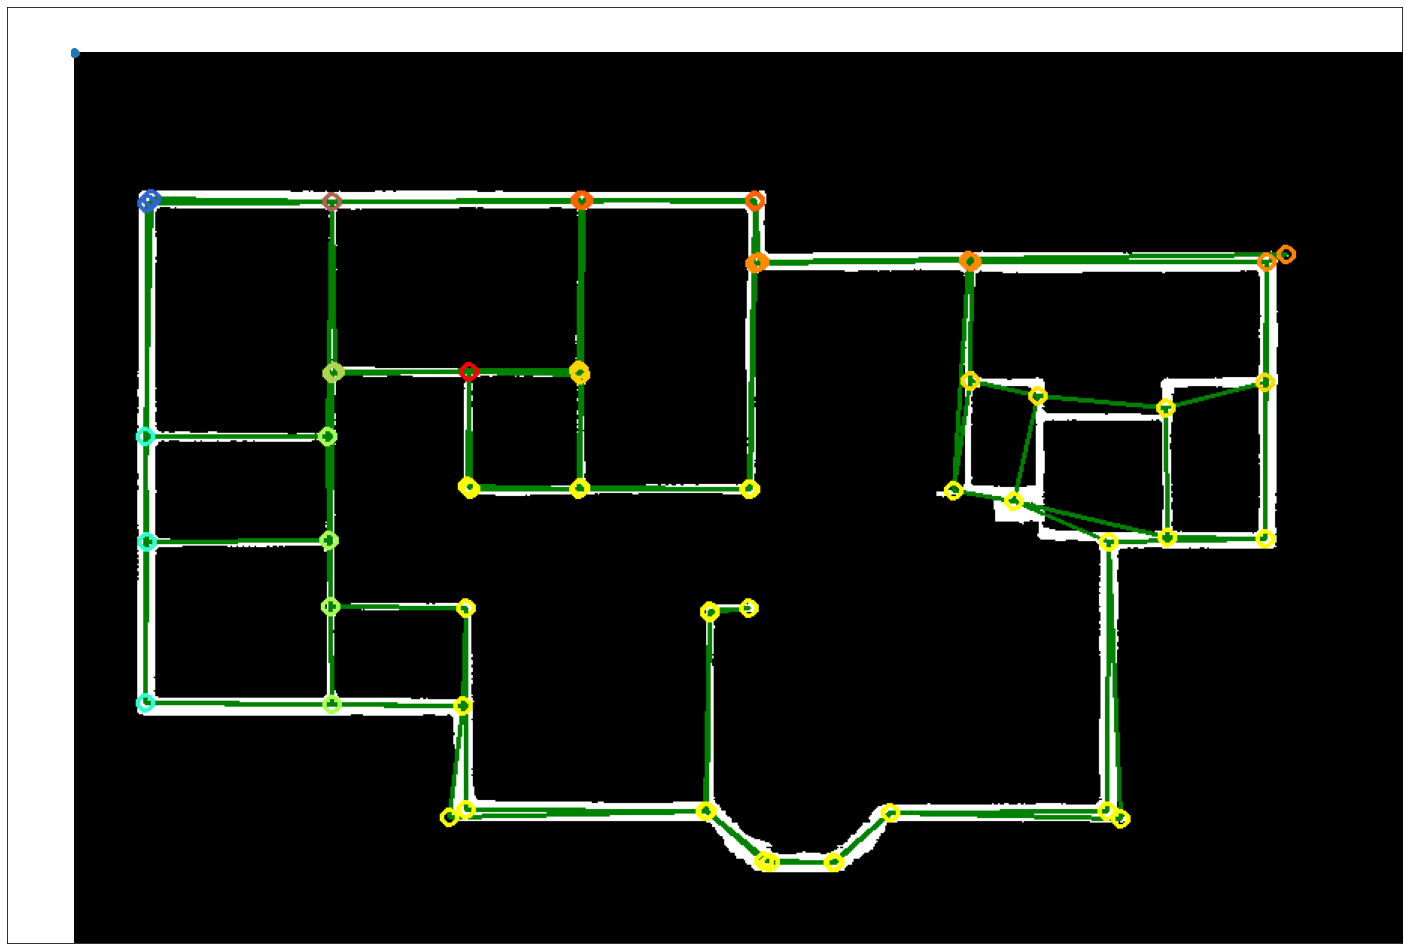

condition x: (336.0, 214.0) (335.0, 211.0)


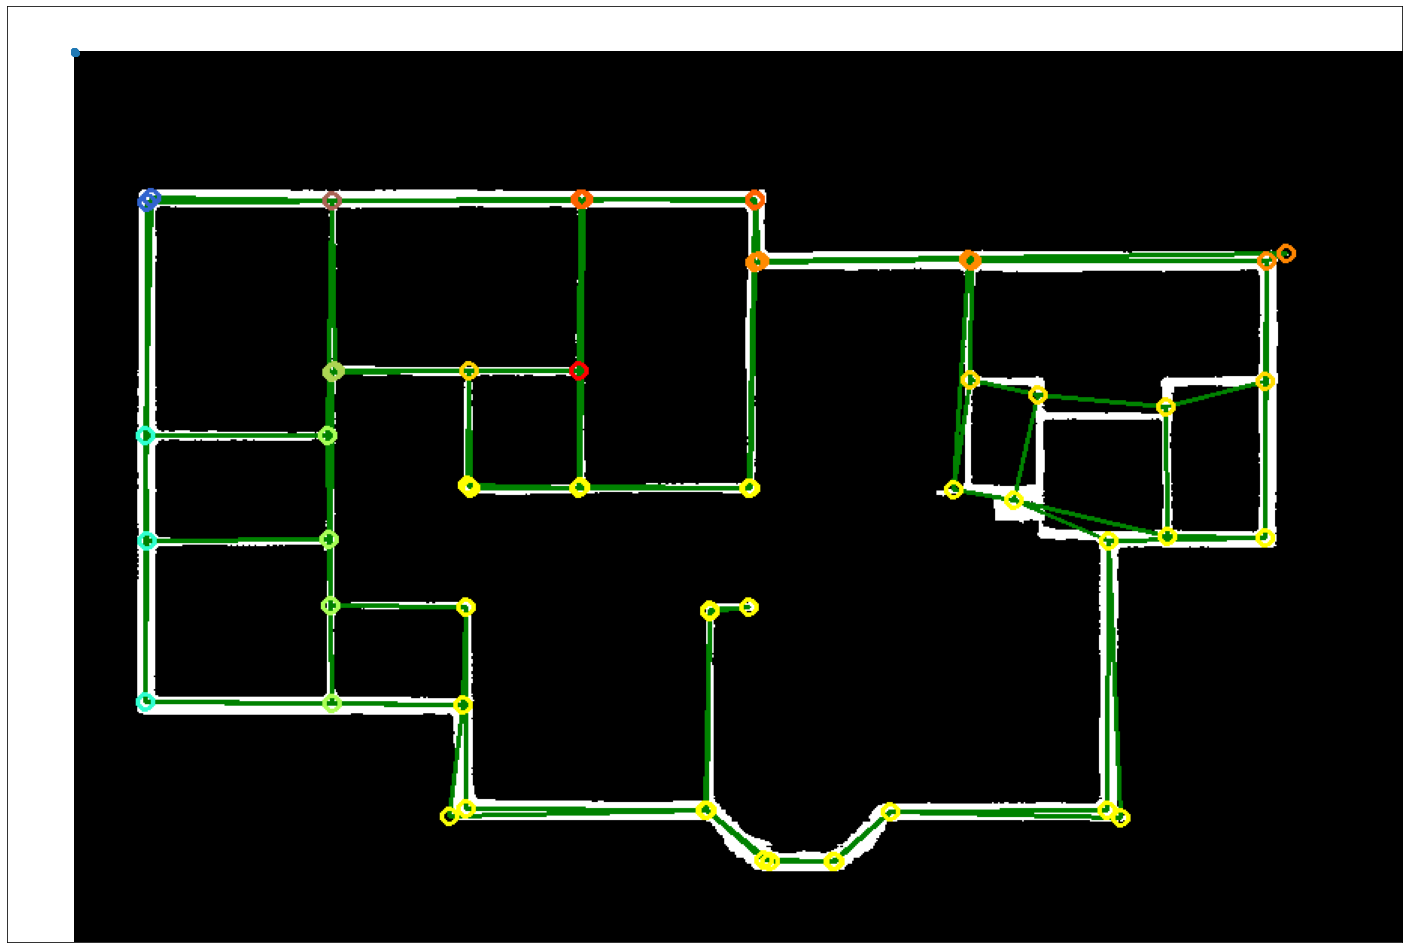

condition x: (335.0, 290.0) (336.0, 289.0)


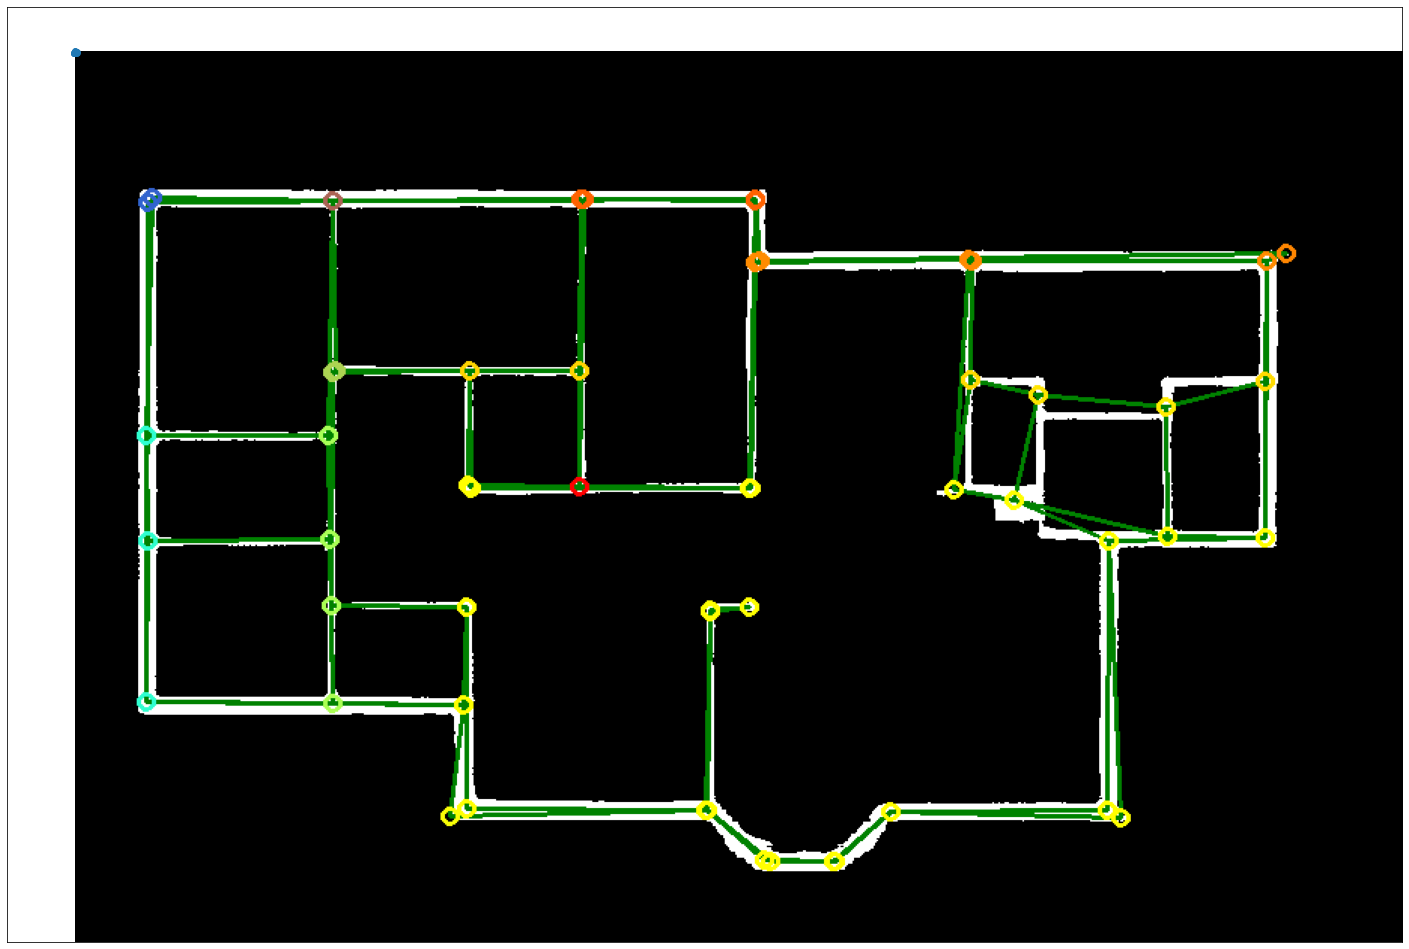

condition x: (261.0, 288.0) (263.0, 290.0)


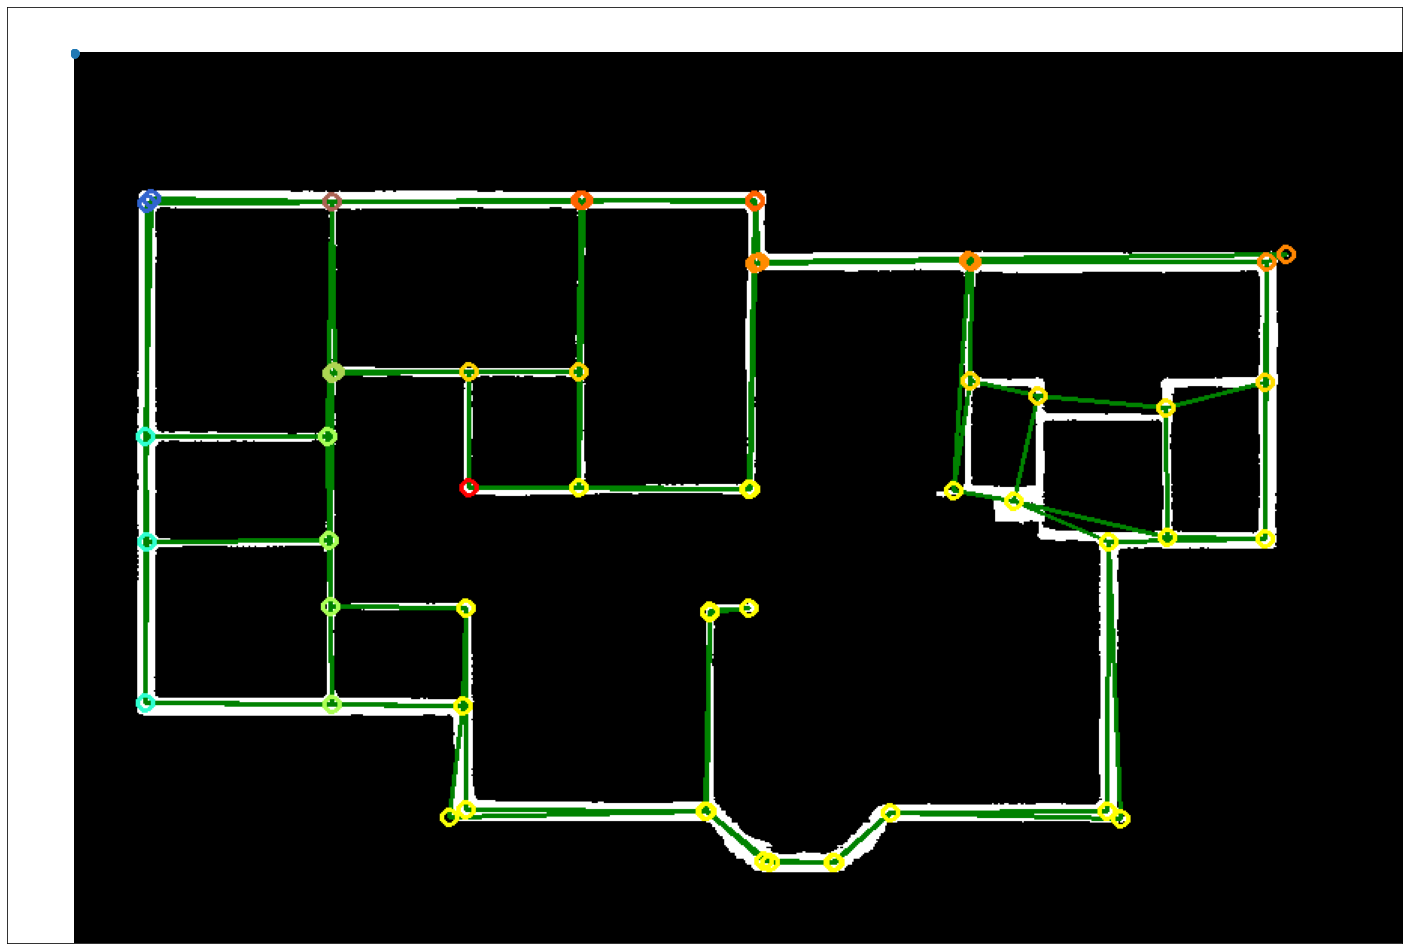

condition x: (792.0, 139.0) (805.0, 134.0)


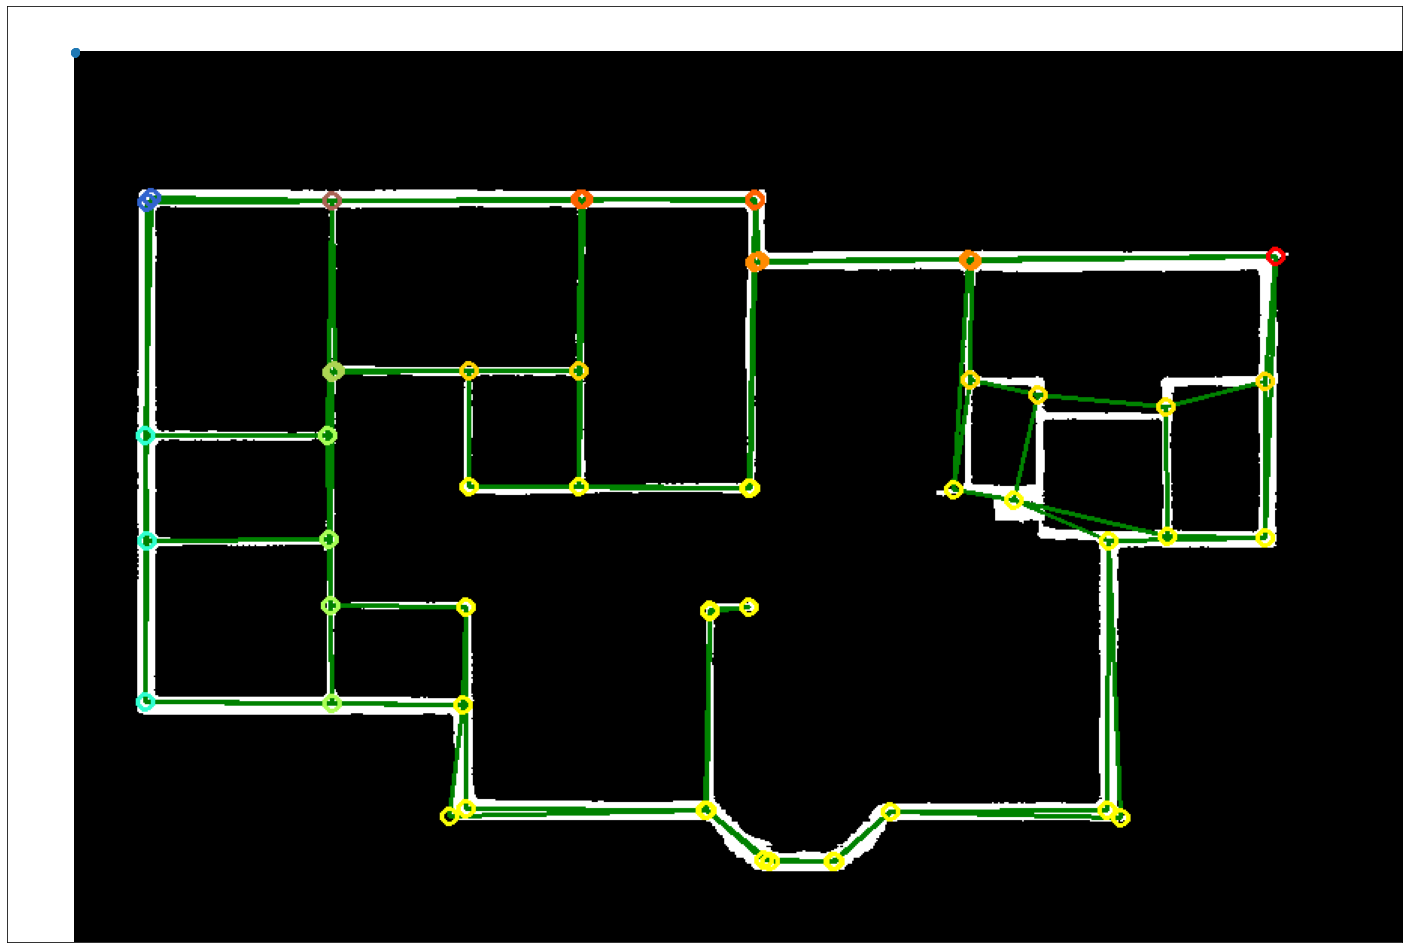

condition x: (596.0, 139.0) (594.0, 138.0)


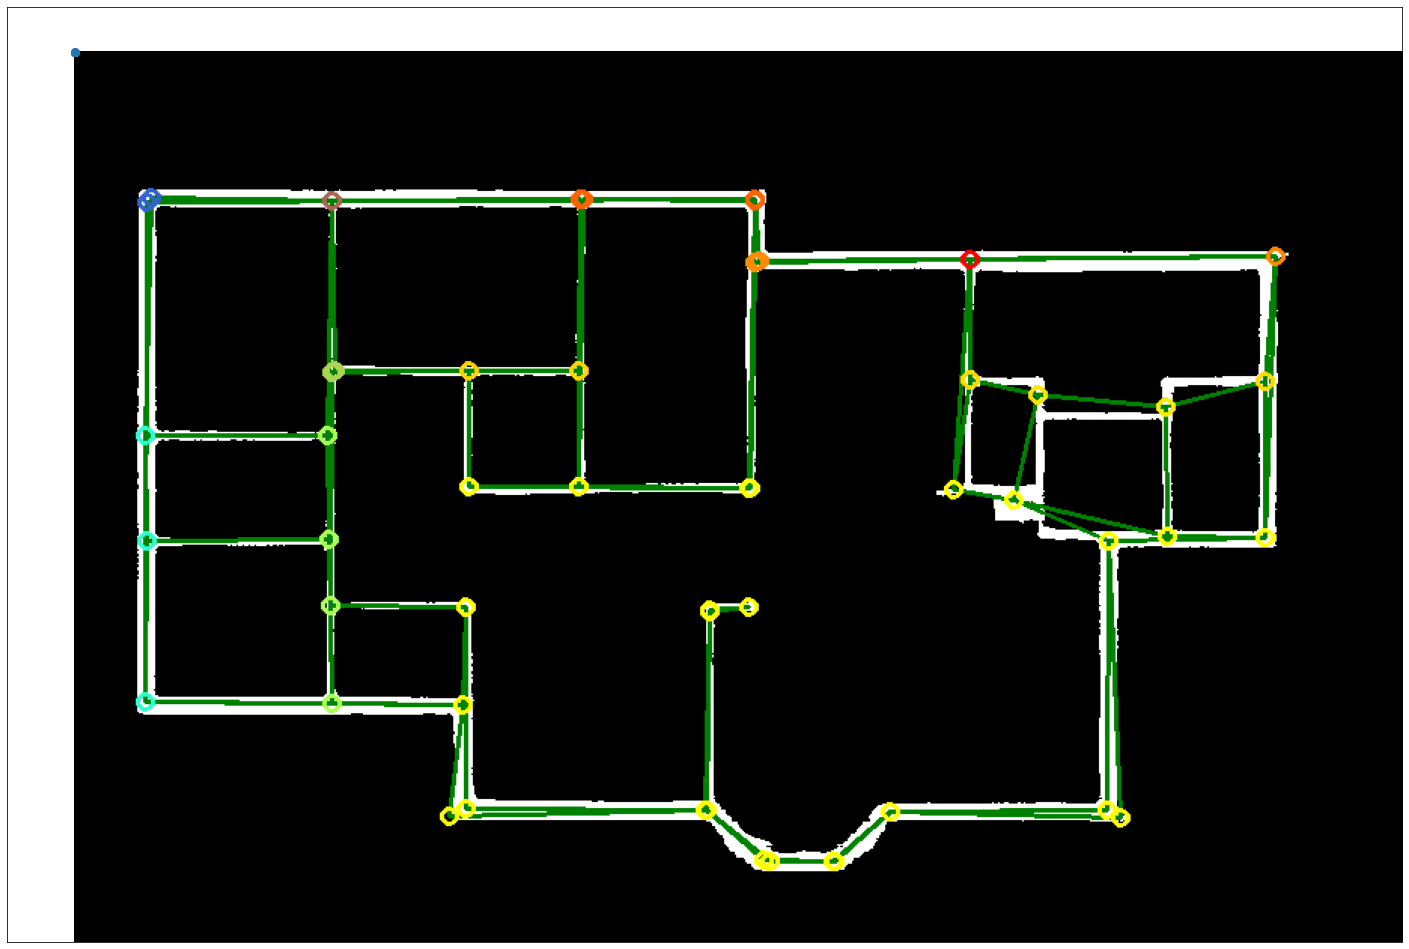

condition x: (171.0, 213.0) (173.0, 212.0)


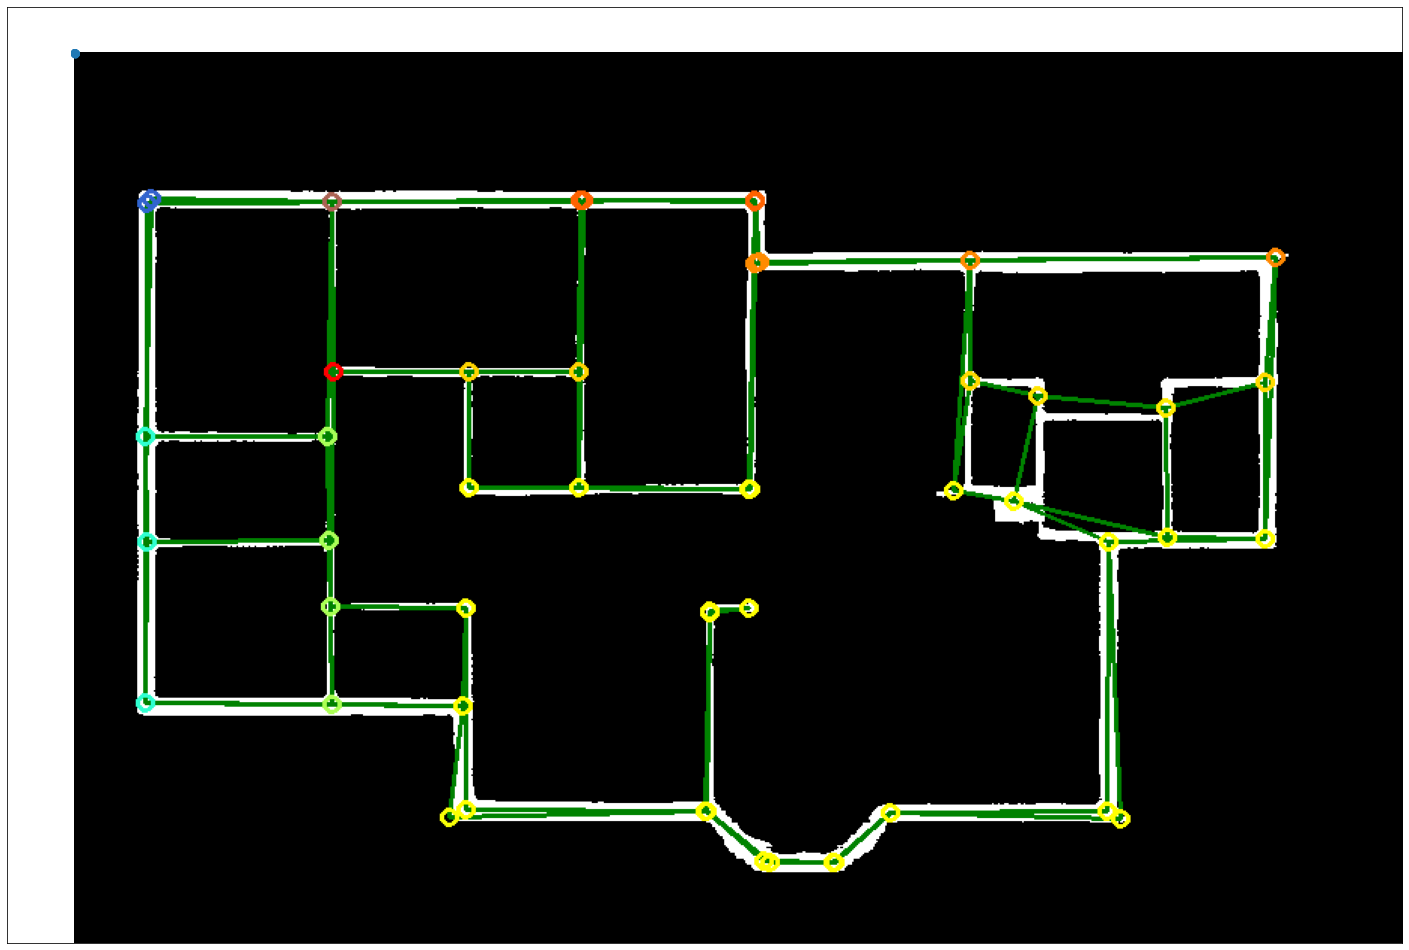

condition x: (449.0, 290.0) (448.0, 290.0)


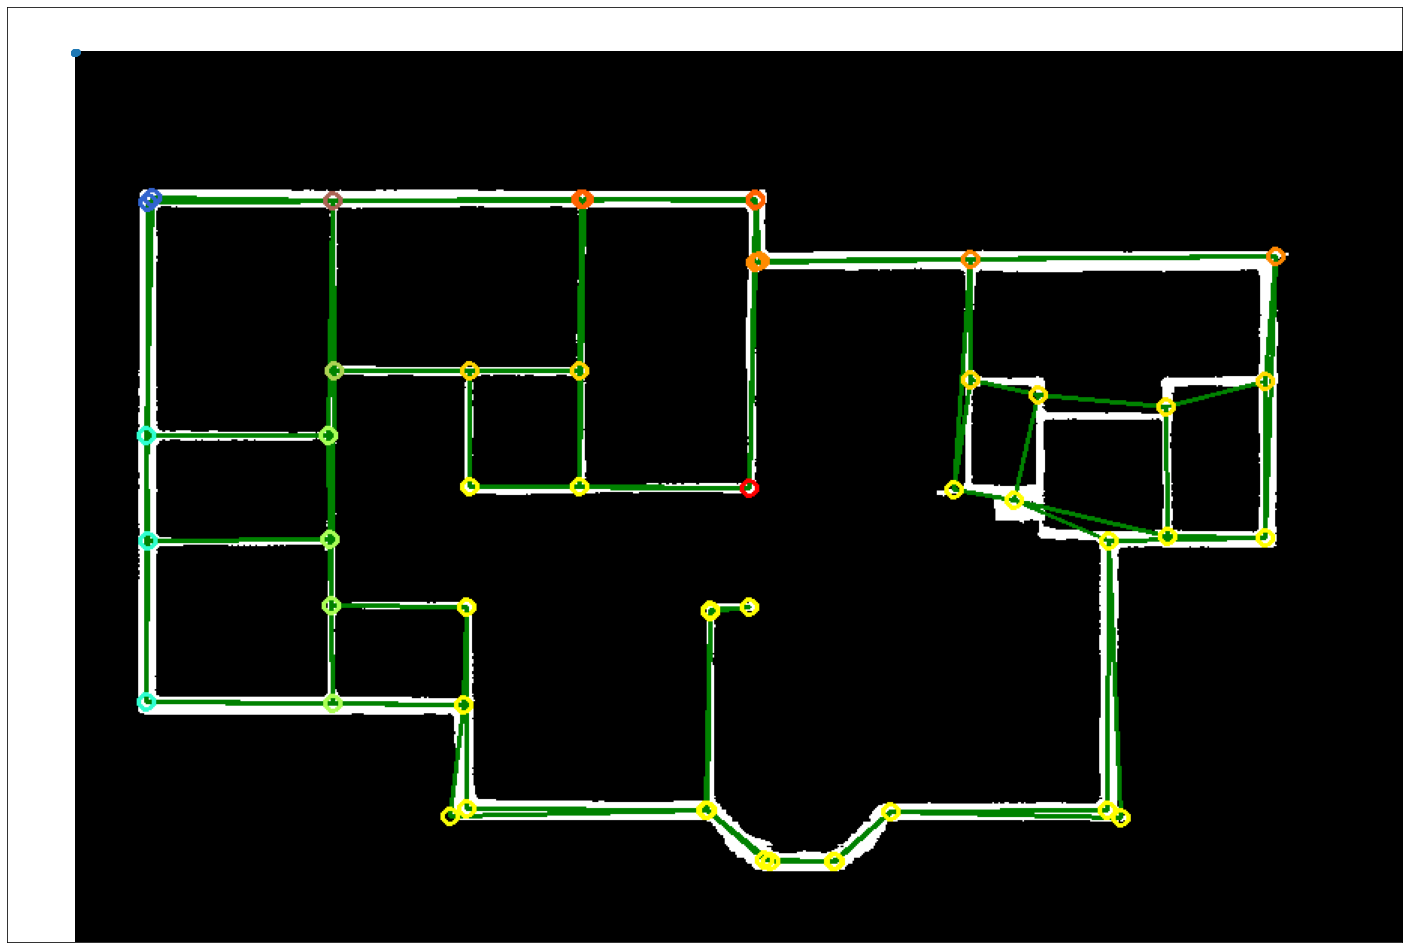

condition x: (452.0, 140.0) (455.0, 139.0)


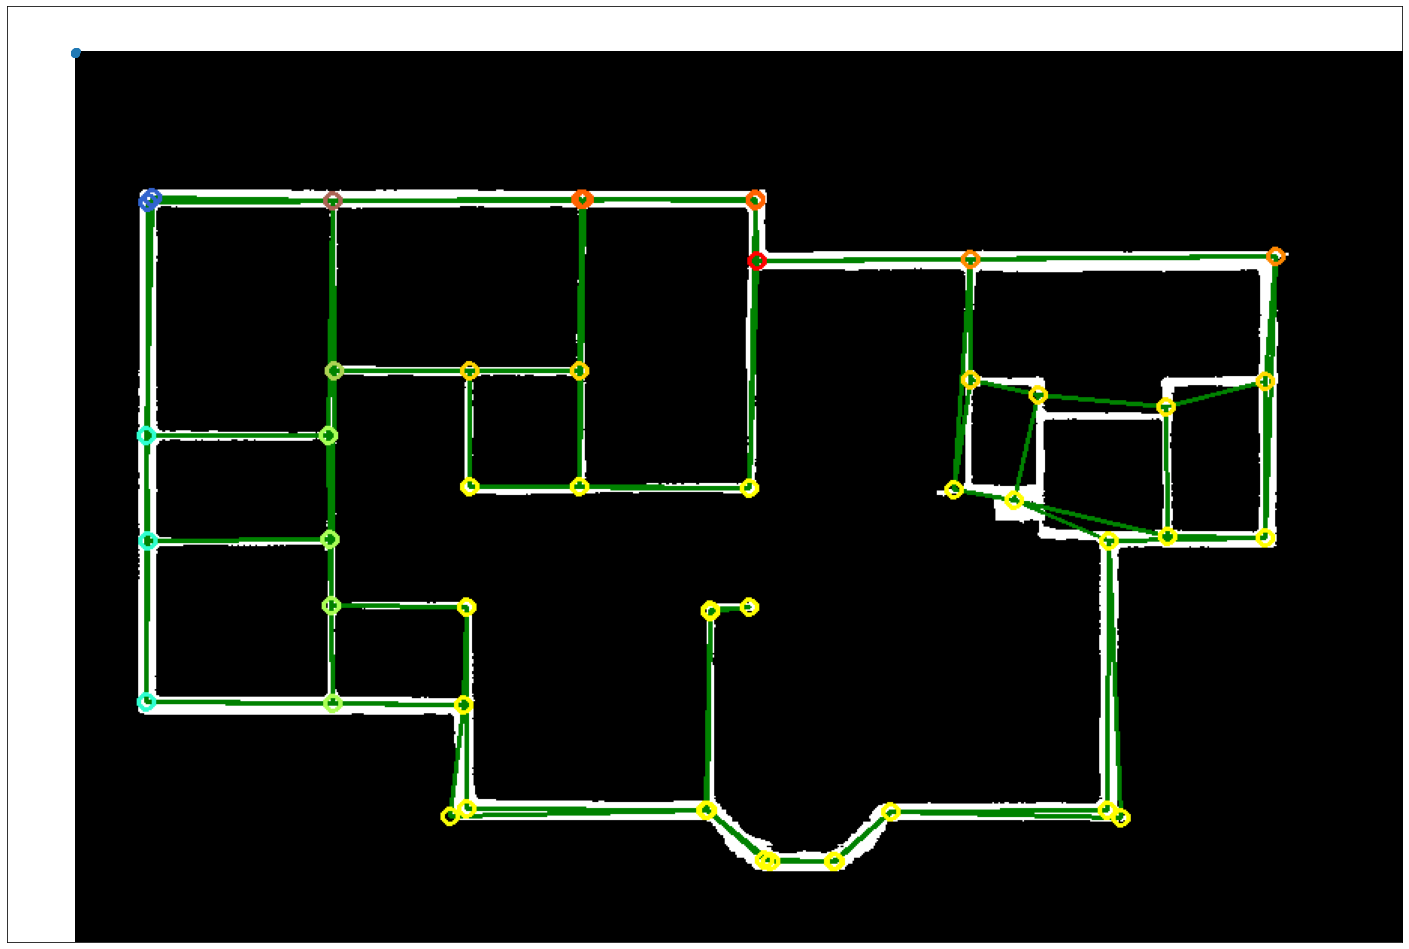

condition x: (686.0, 504.0) (695.0, 509.0)


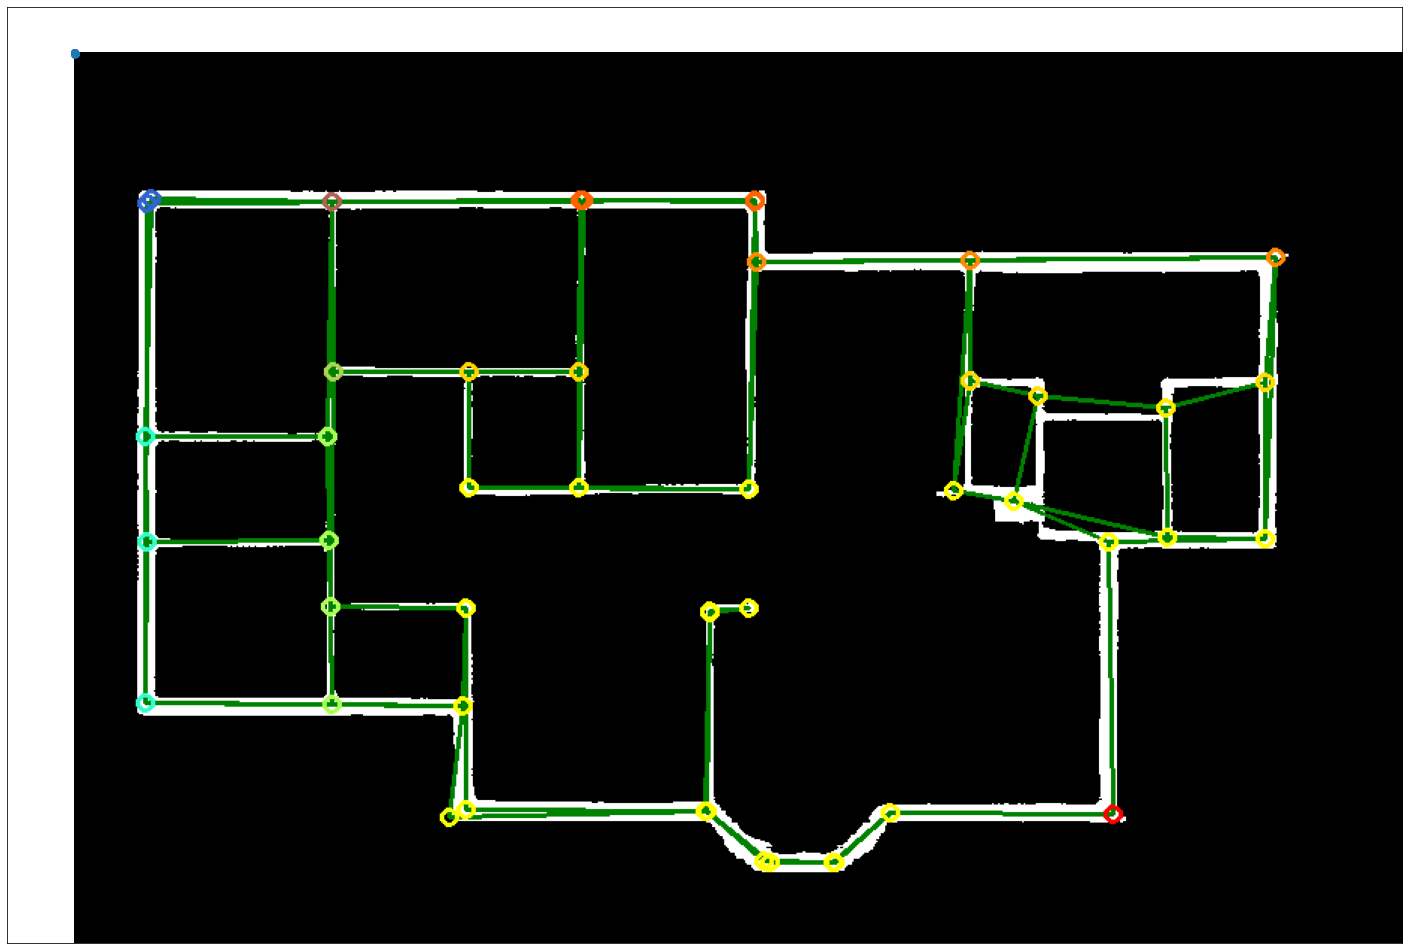

condition x: (504.0, 538.0) (505.0, 538.0)


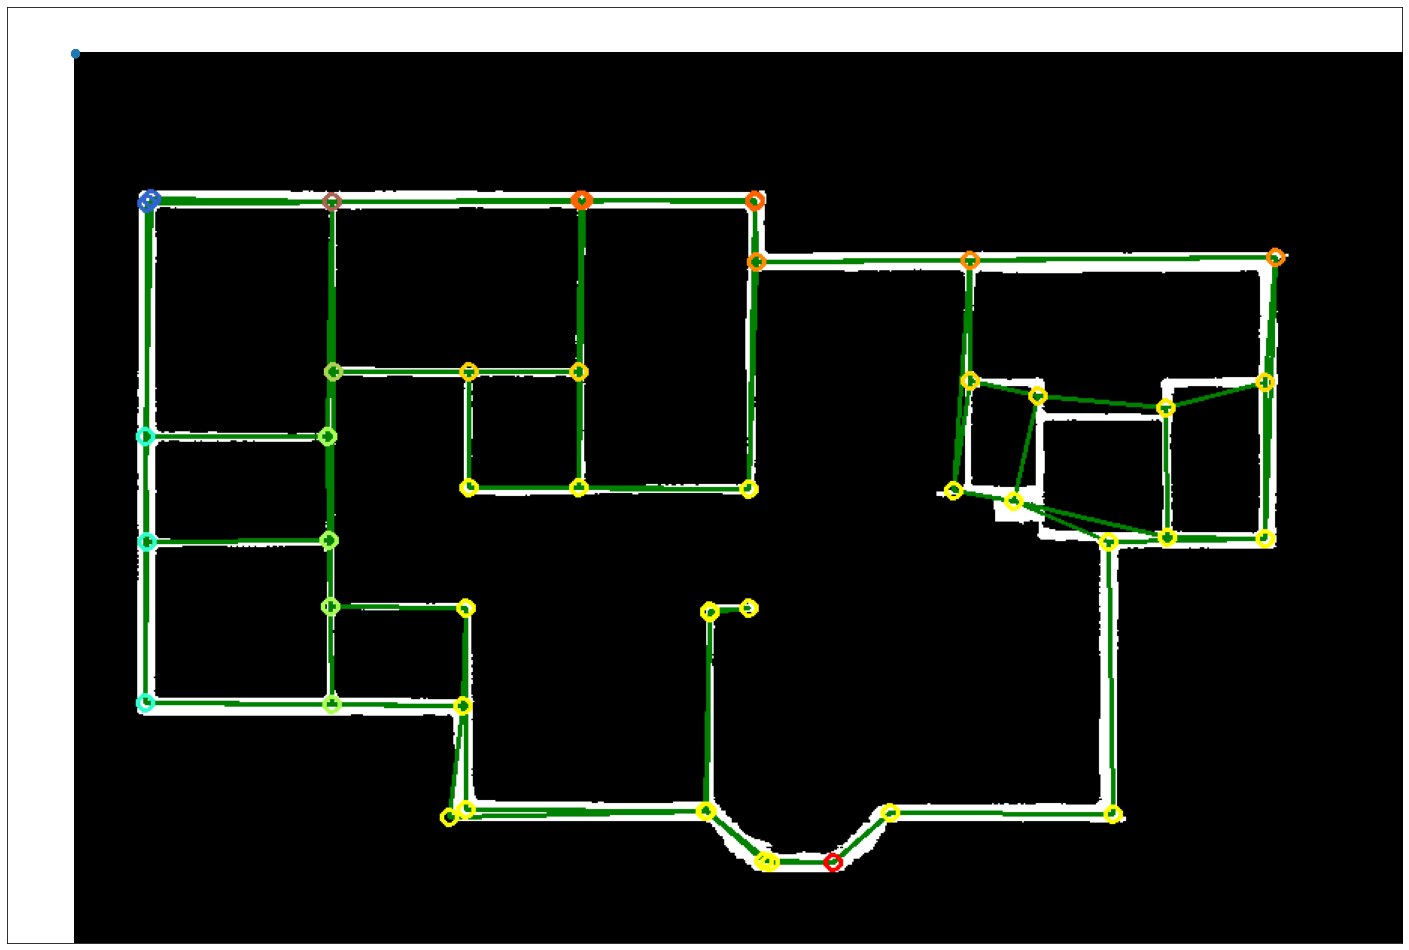

condition x: (458.0, 537.0) (462.0, 538.0)


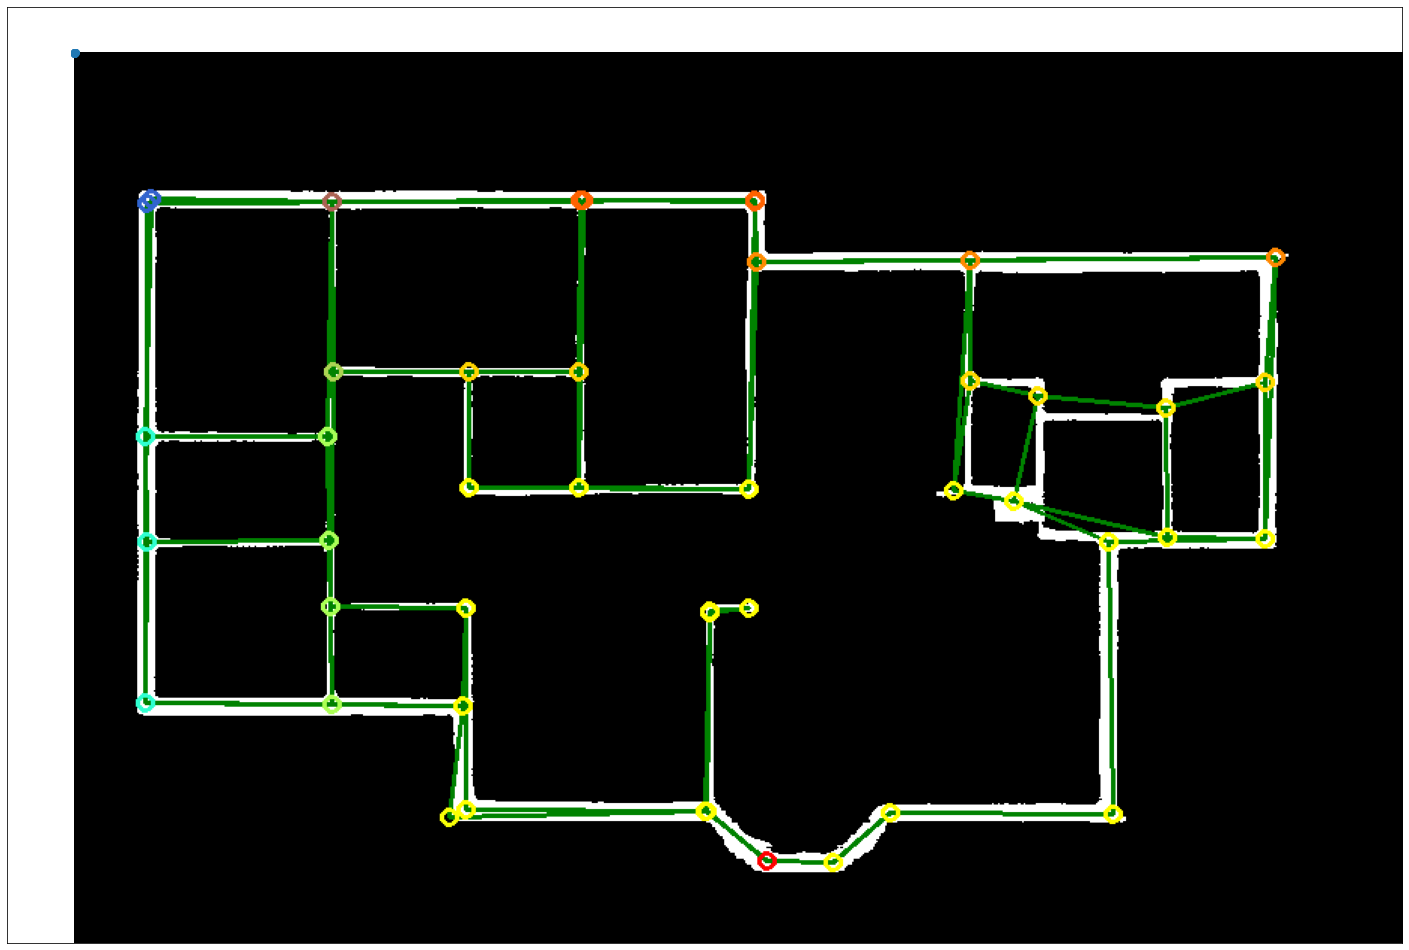

condition x: (420.0, 504.0) (419.0, 504.0)


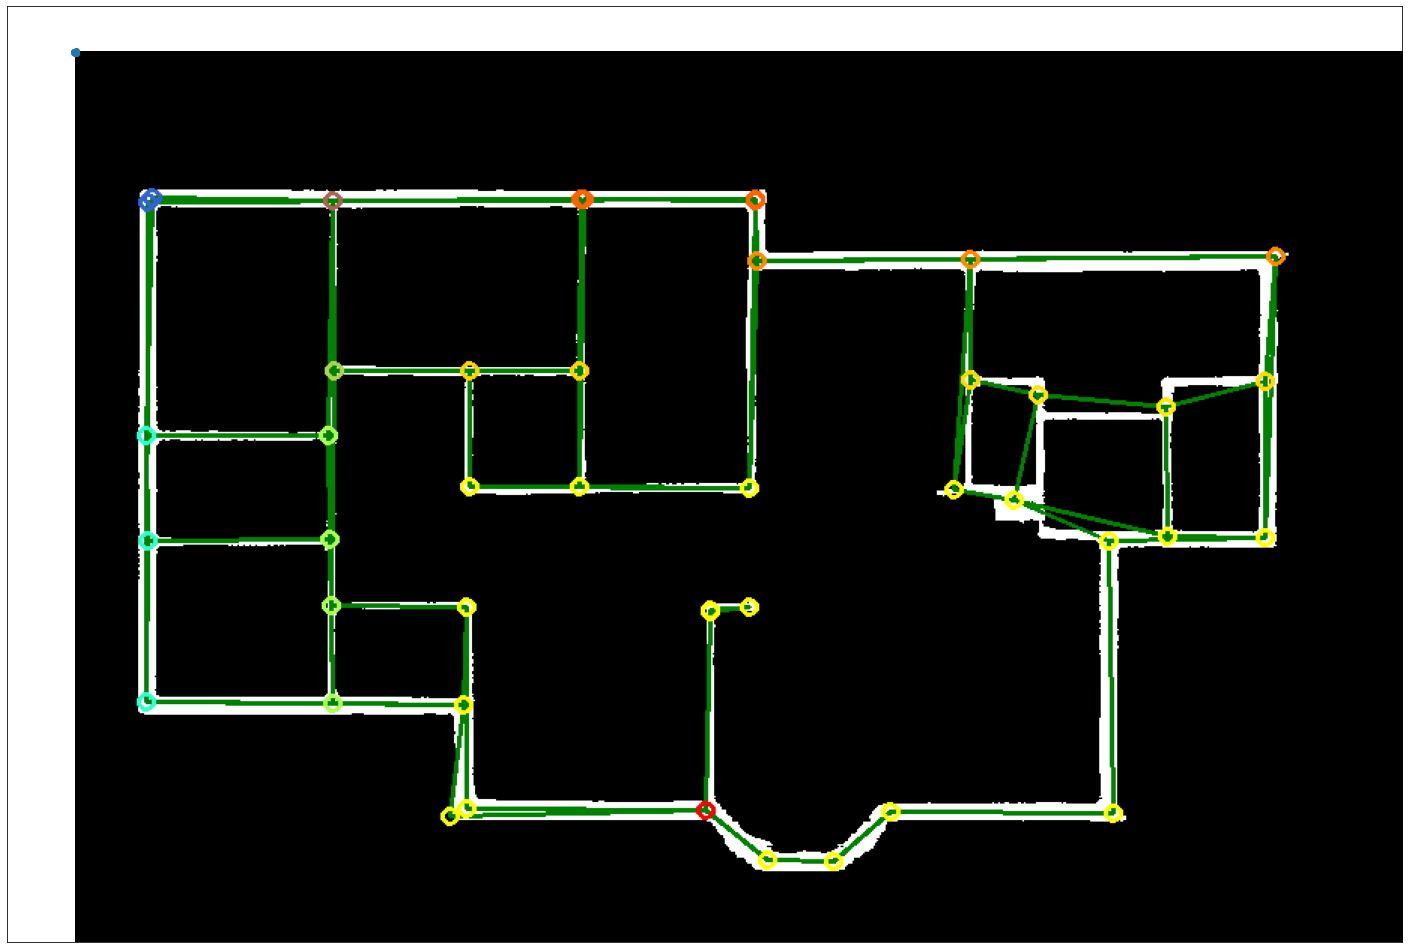

condition x: (422.0, 372.0) (422.0, 371.0)


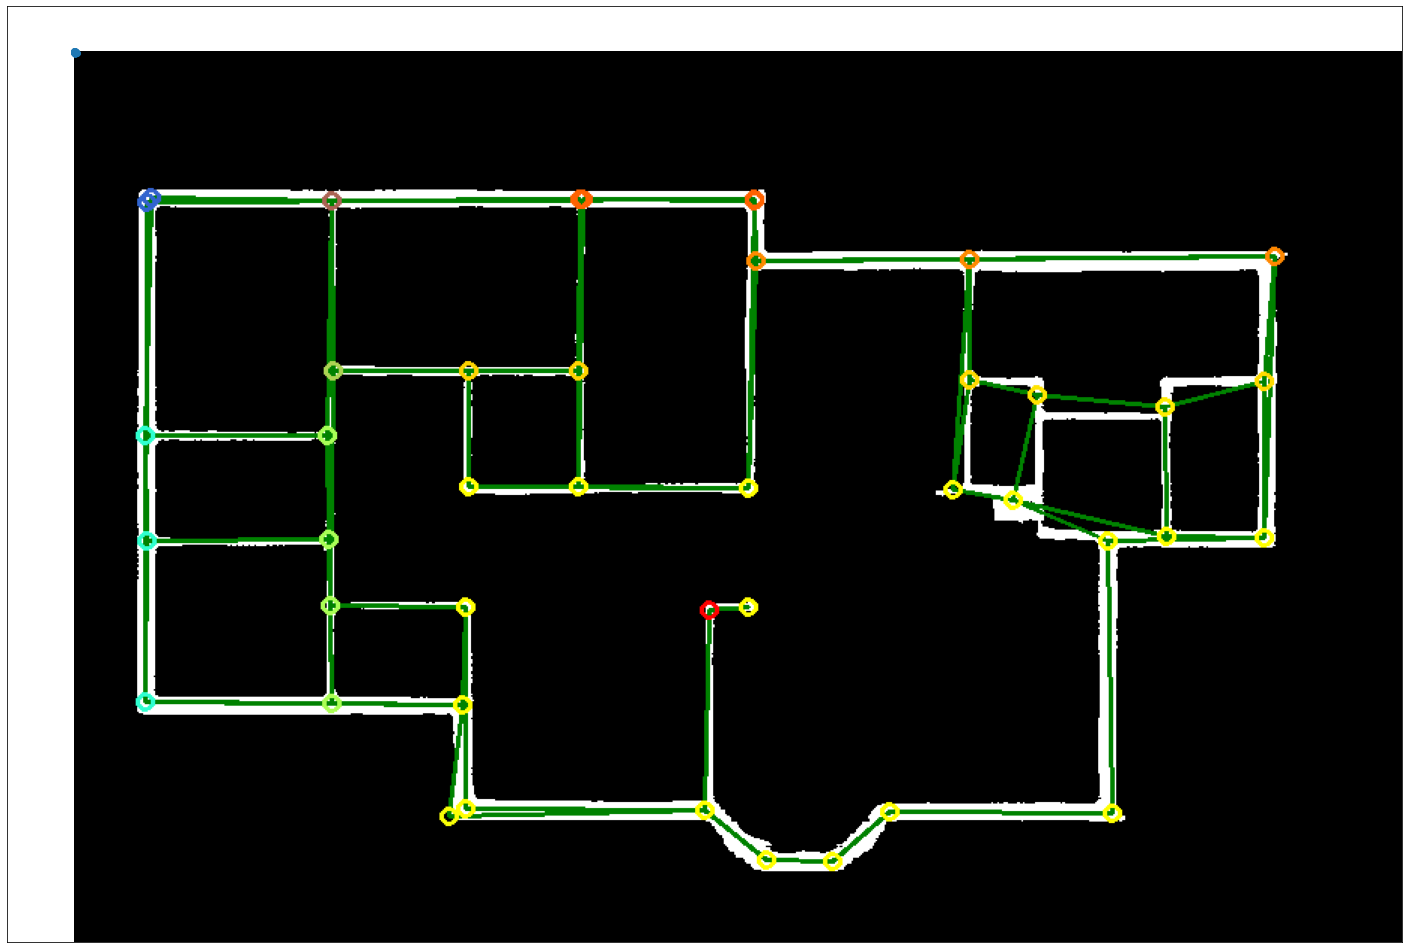

condition x: (260.0, 503.0) (249.0, 508.0)


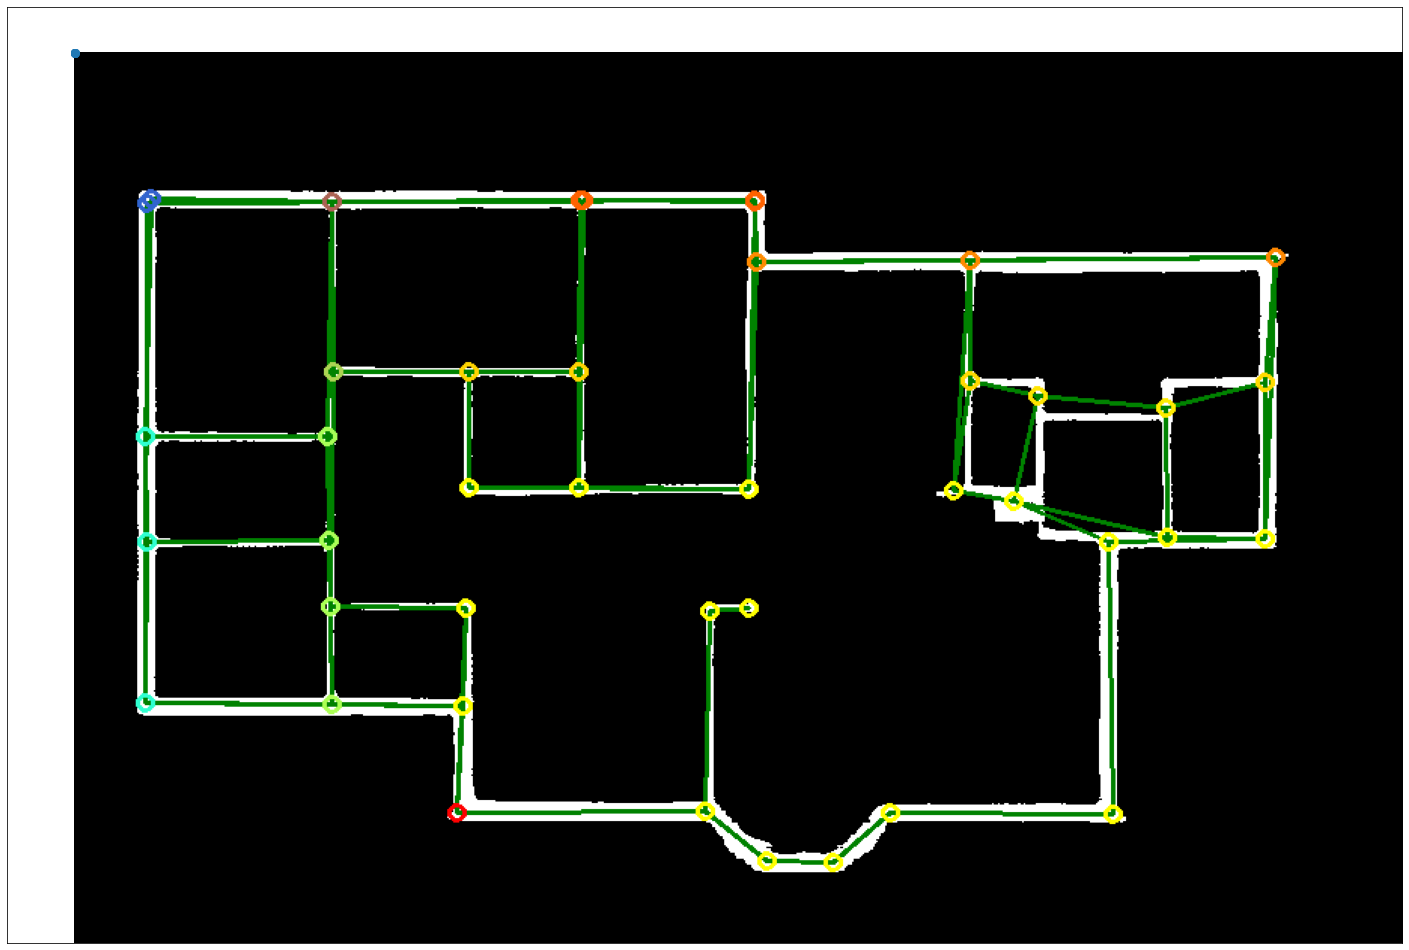

condition x: (338.0, 98.0) (336.0, 98.0)


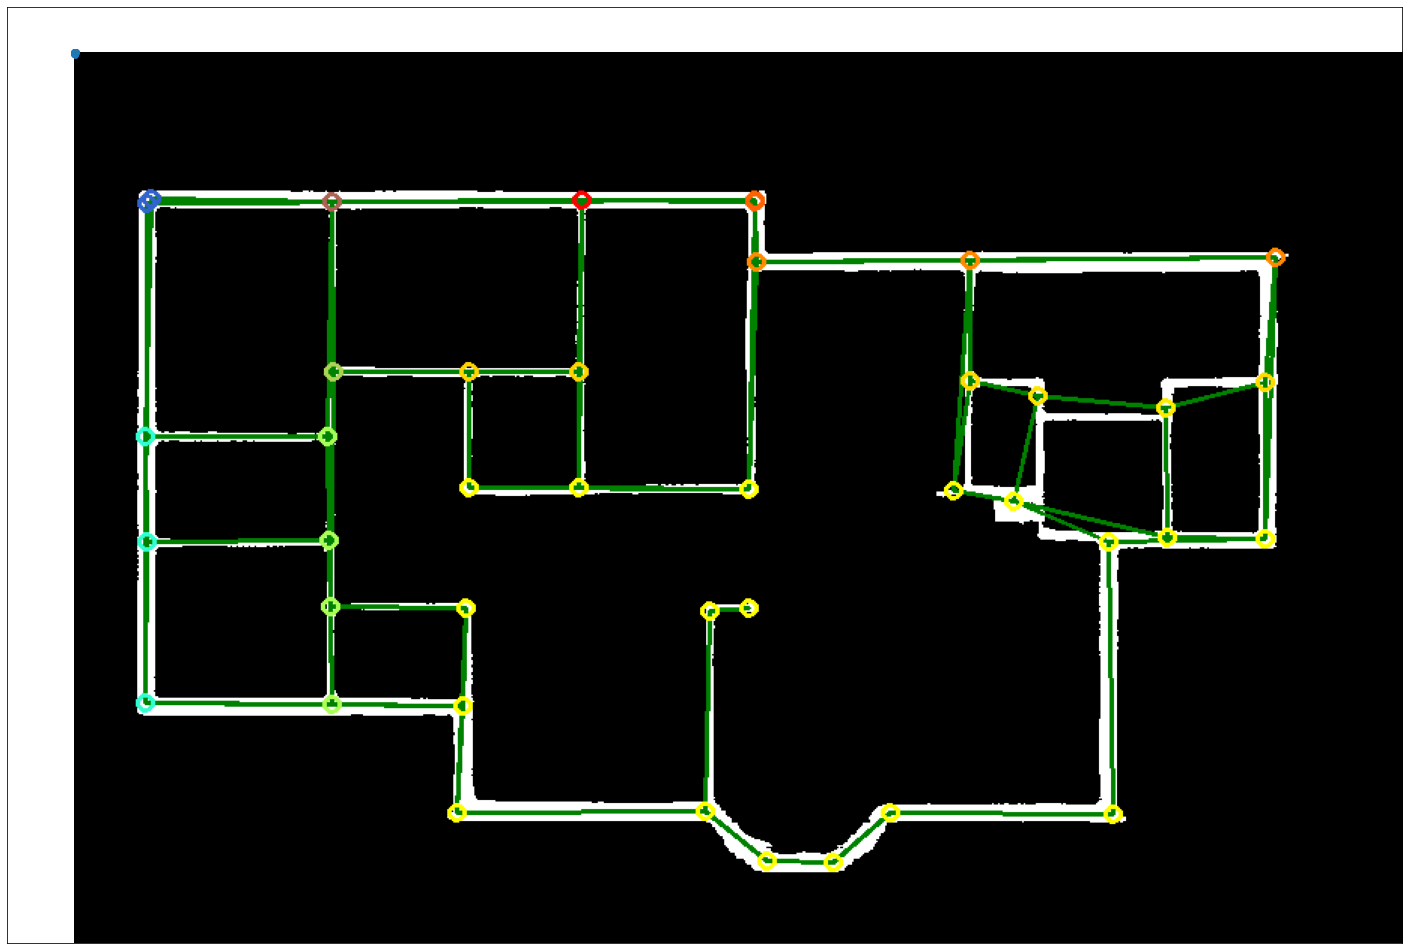

condition x: (452.0, 99.0) (452.0, 98.0)


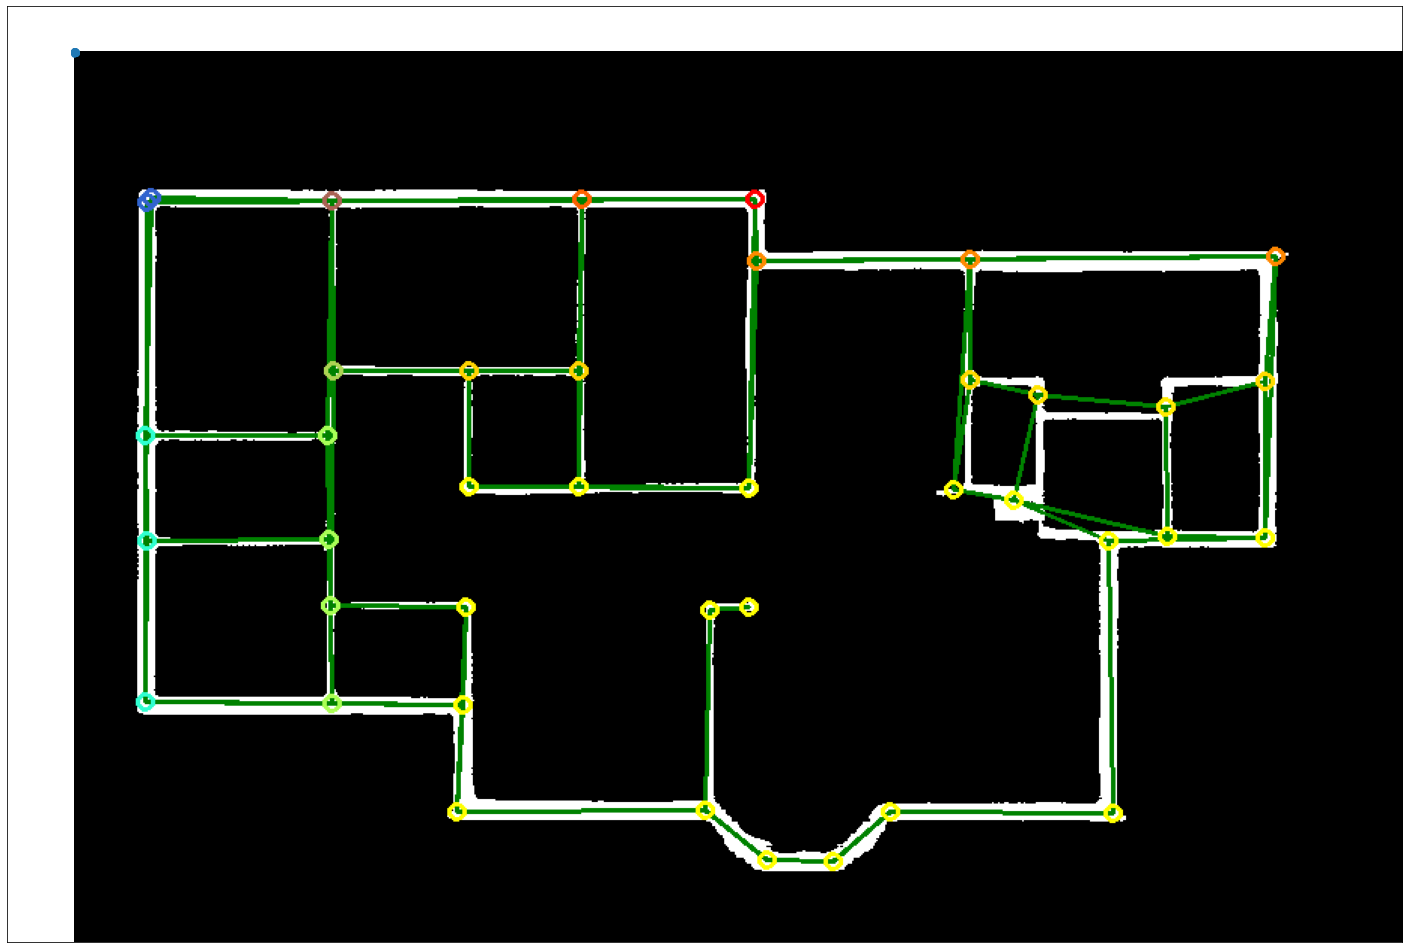

condition x: (51.0, 97.0) (48.0, 100.0)


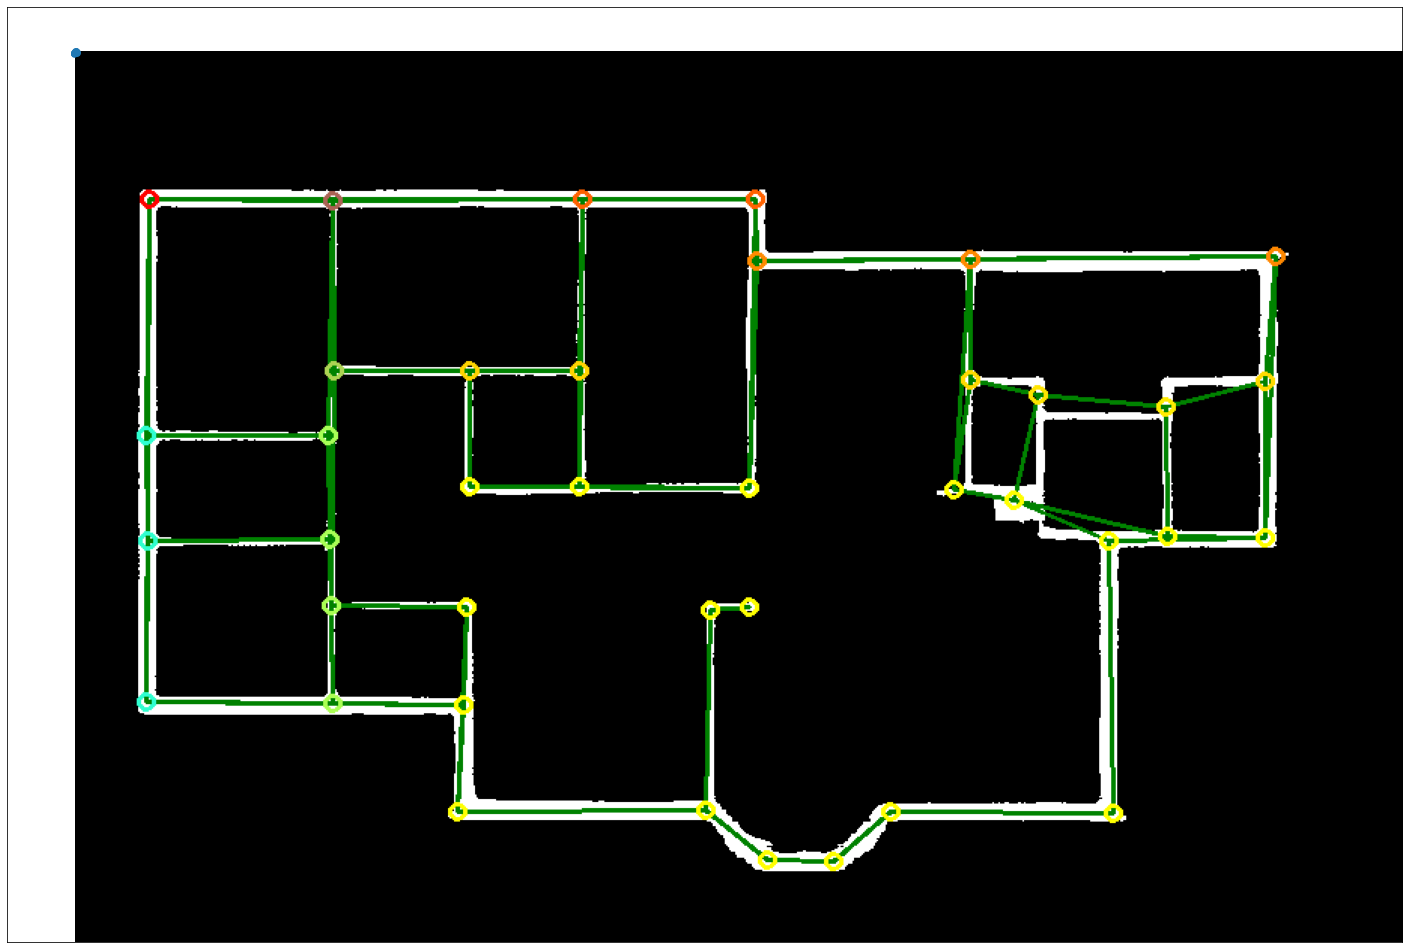

condition y: ((170.0, 368.5), (172.0, 212.5)) (169.0, 324.0)


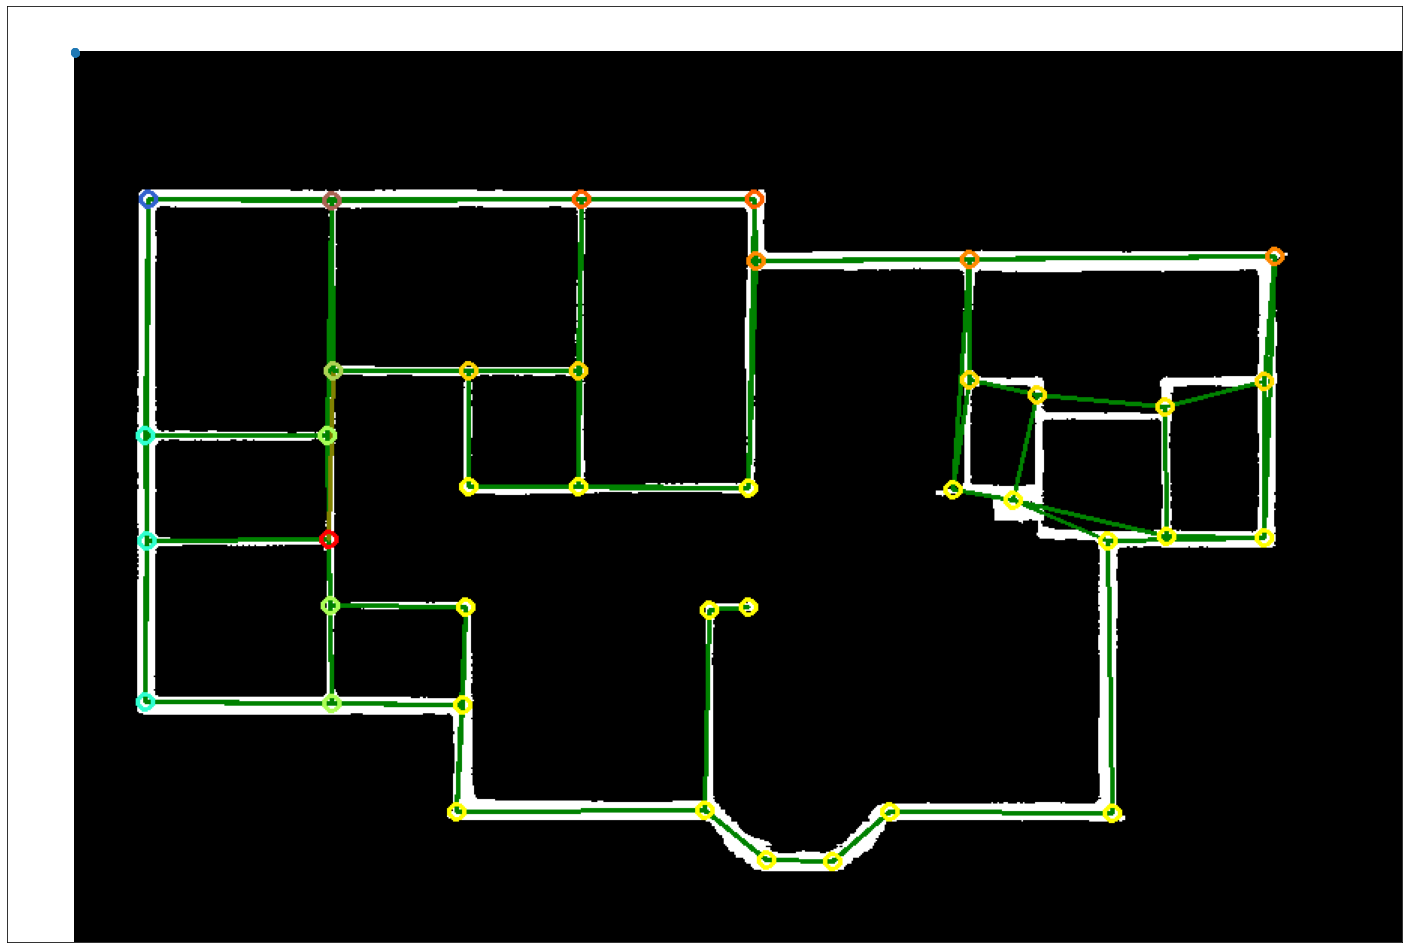

condition y: ((260.0, 369.0), (254.5, 505.5)) (258.5, 434.0)


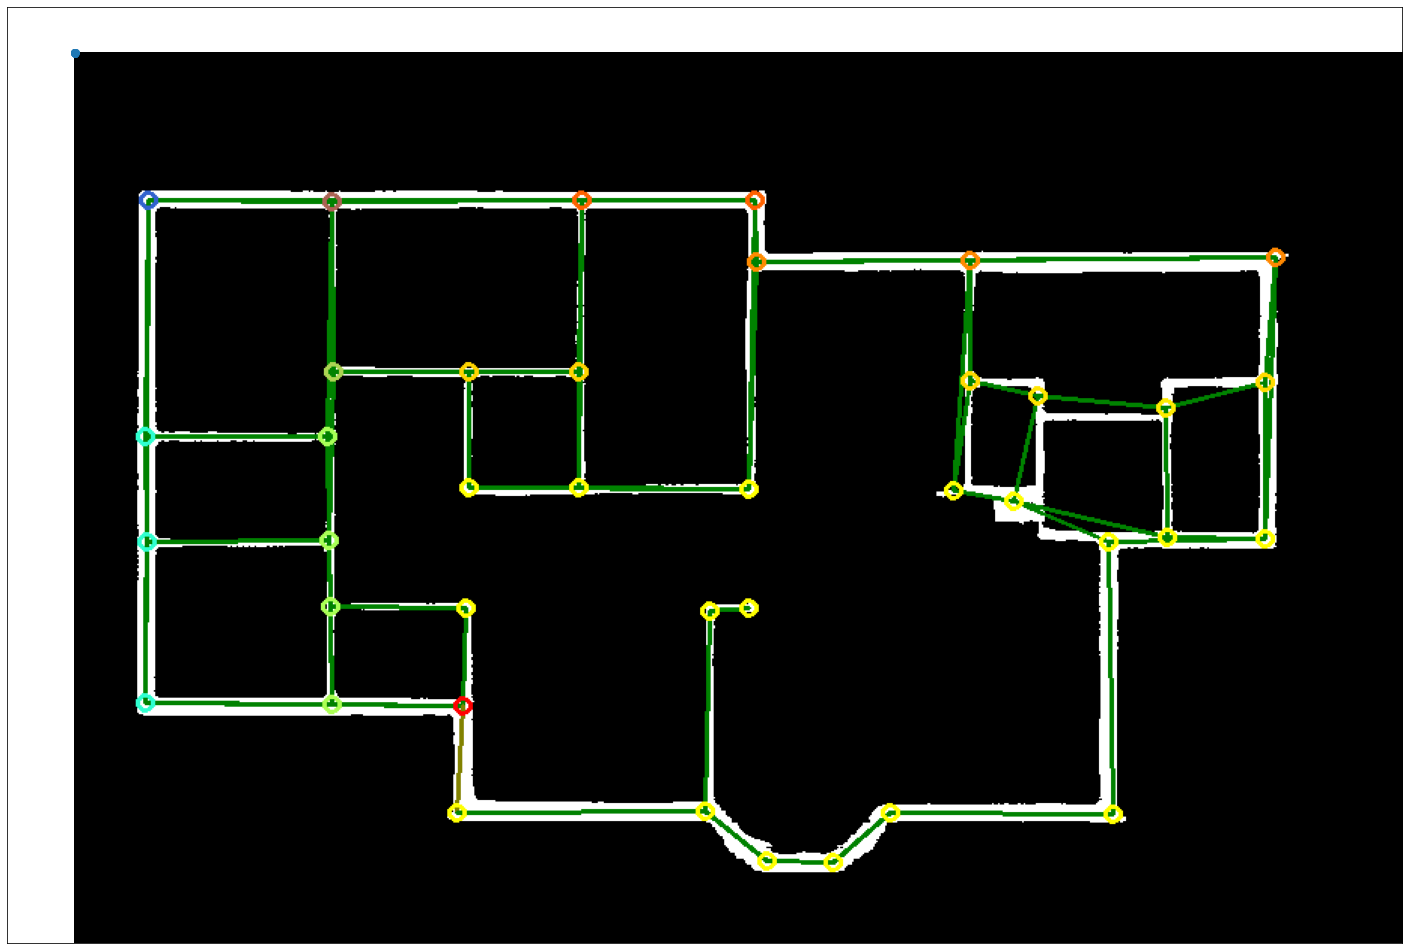

condition y: ((258.5, 434.0), (47.5, 432.5)) (171.5, 433.5)


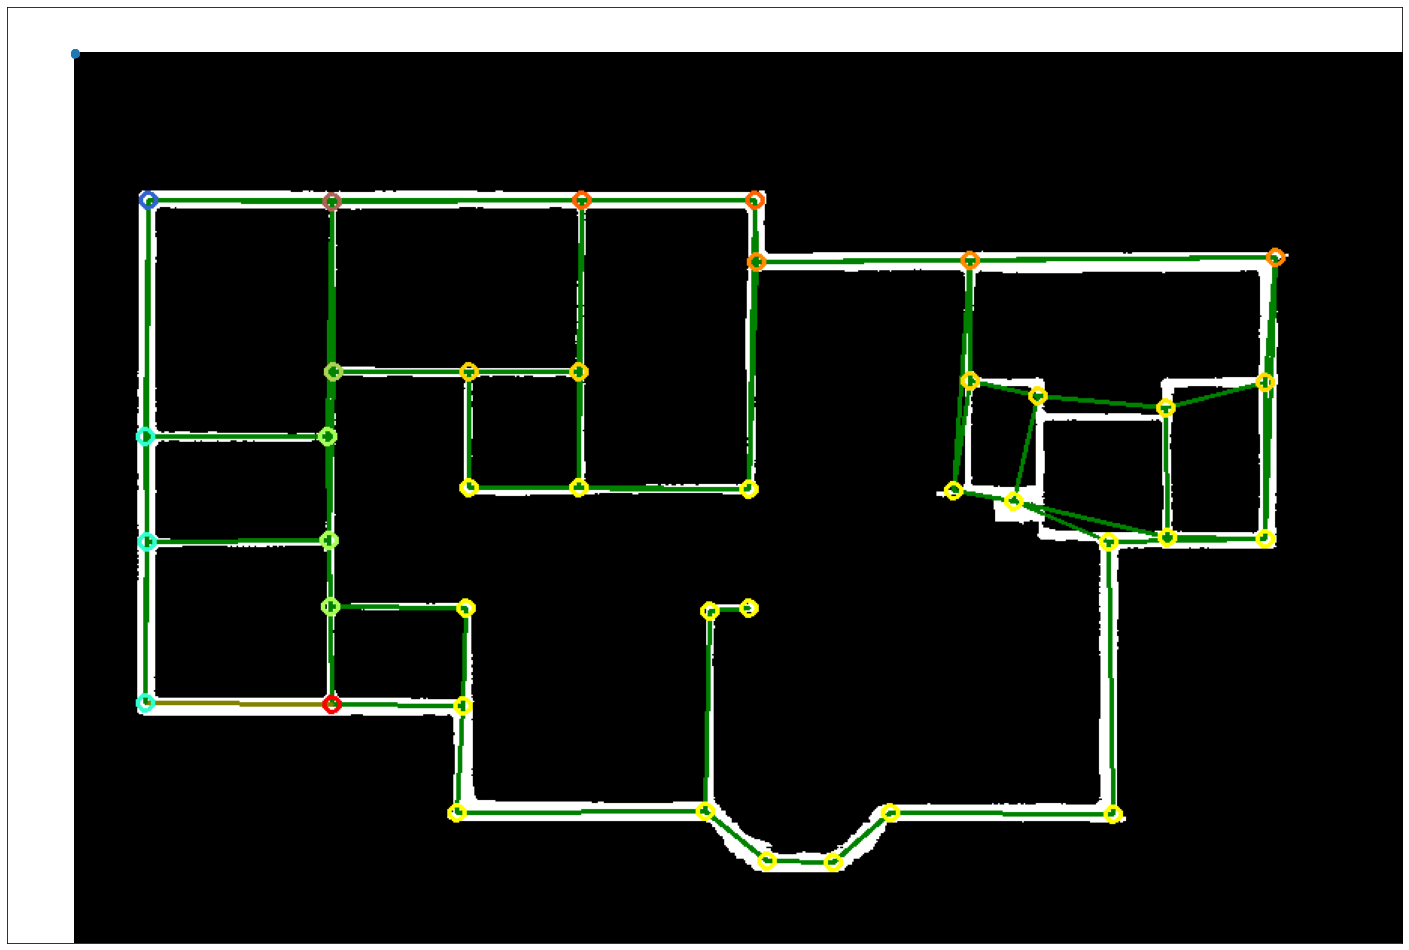

condition y: ((171.5, 433.5), (169.0, 324.0)) (170.0, 368.5)


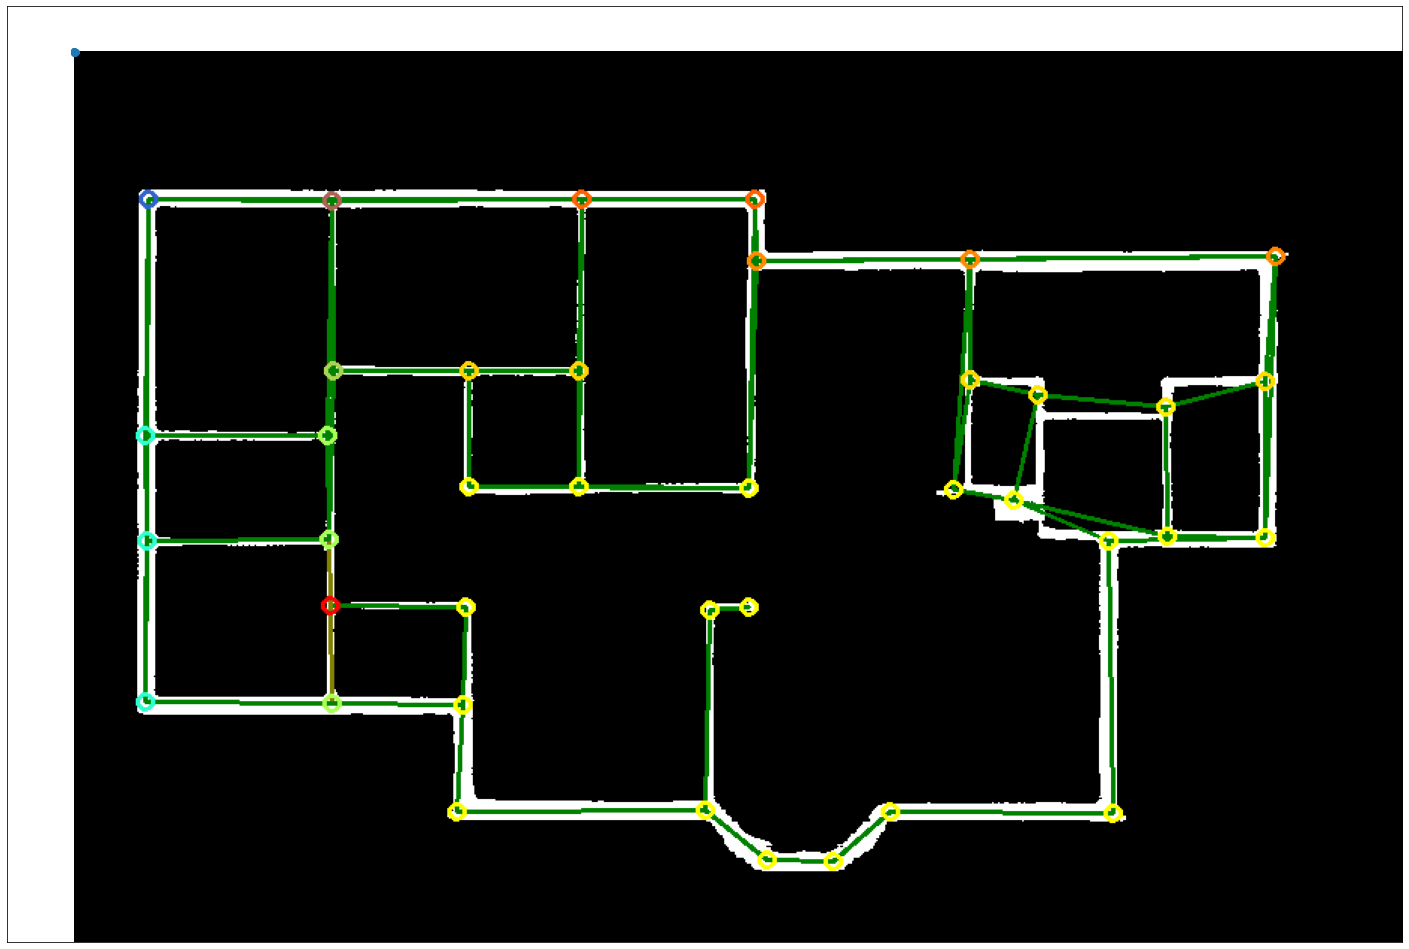

condition y: ((169.0, 324.0), (172.0, 212.5)) (168.0, 255.0)


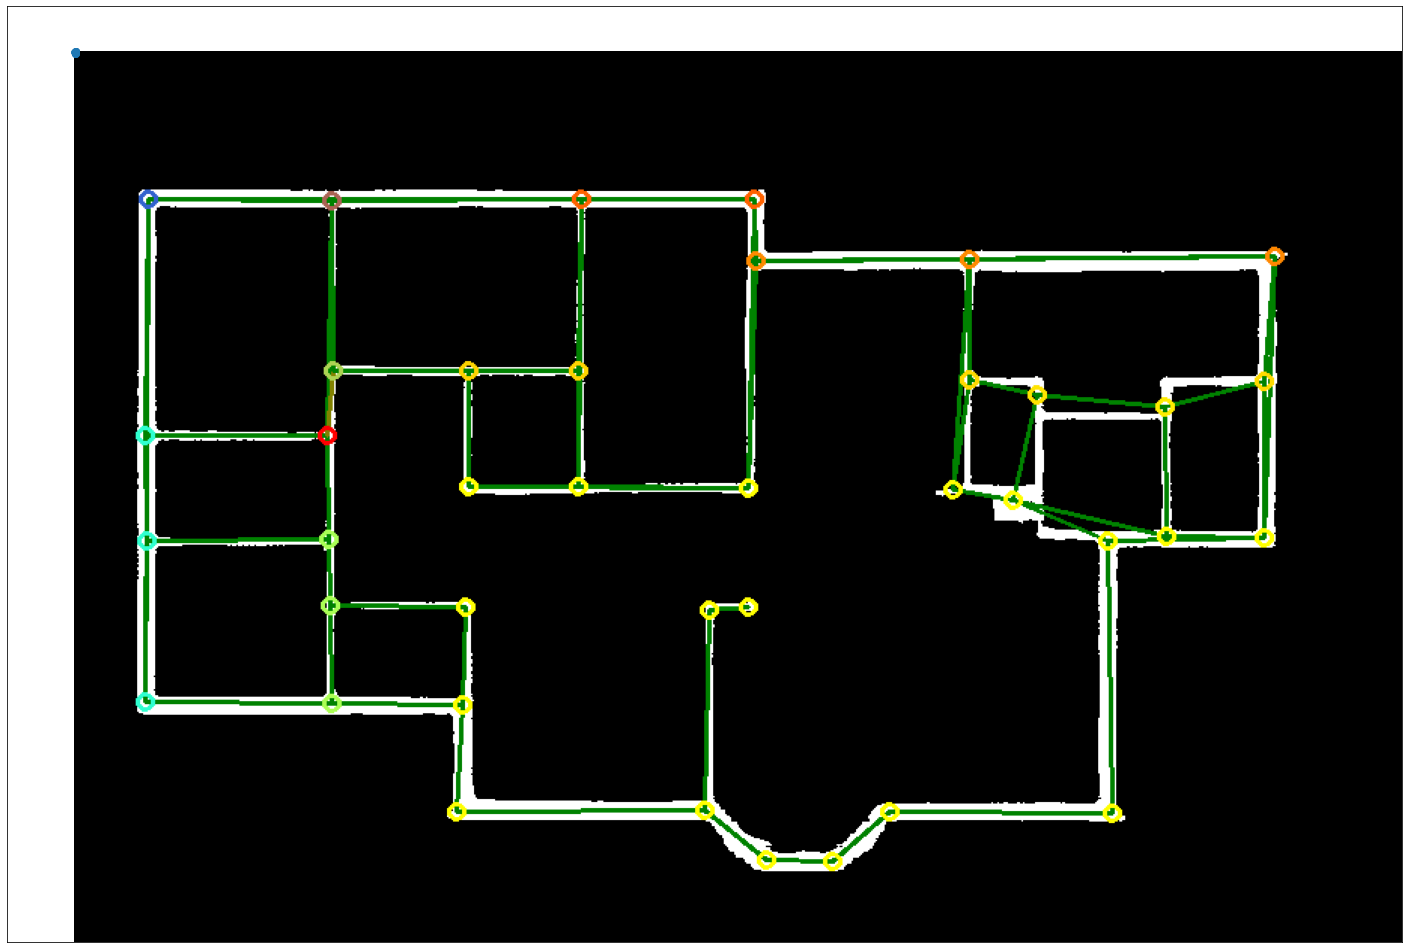

condition y: ((47.5, 432.5), (49.5, 98.5)) (48.5, 325.5)


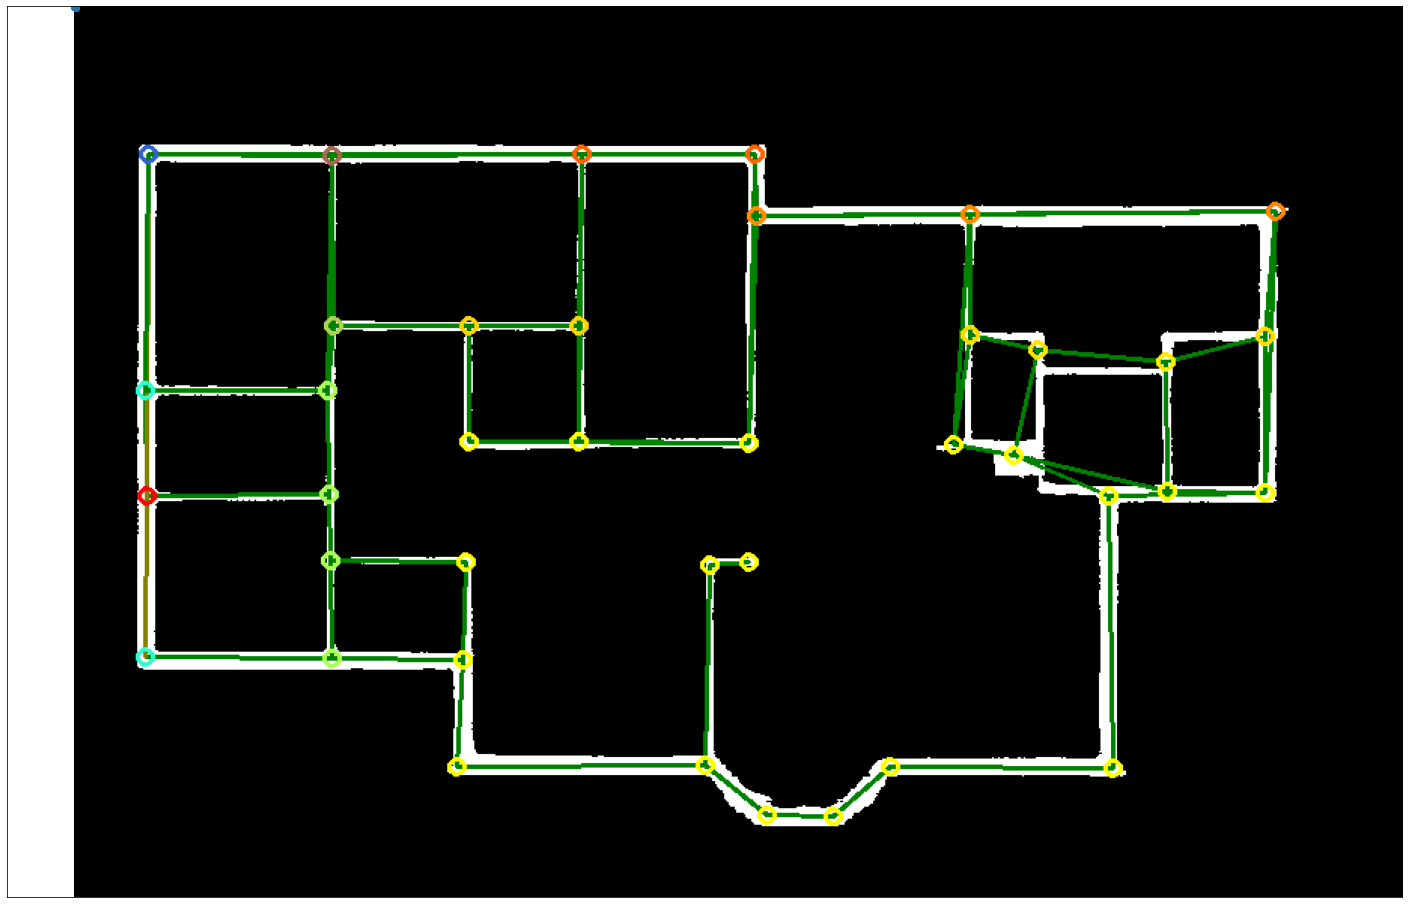

condition y: ((48.5, 325.5), (49.5, 98.5)) (47.5, 255.0)


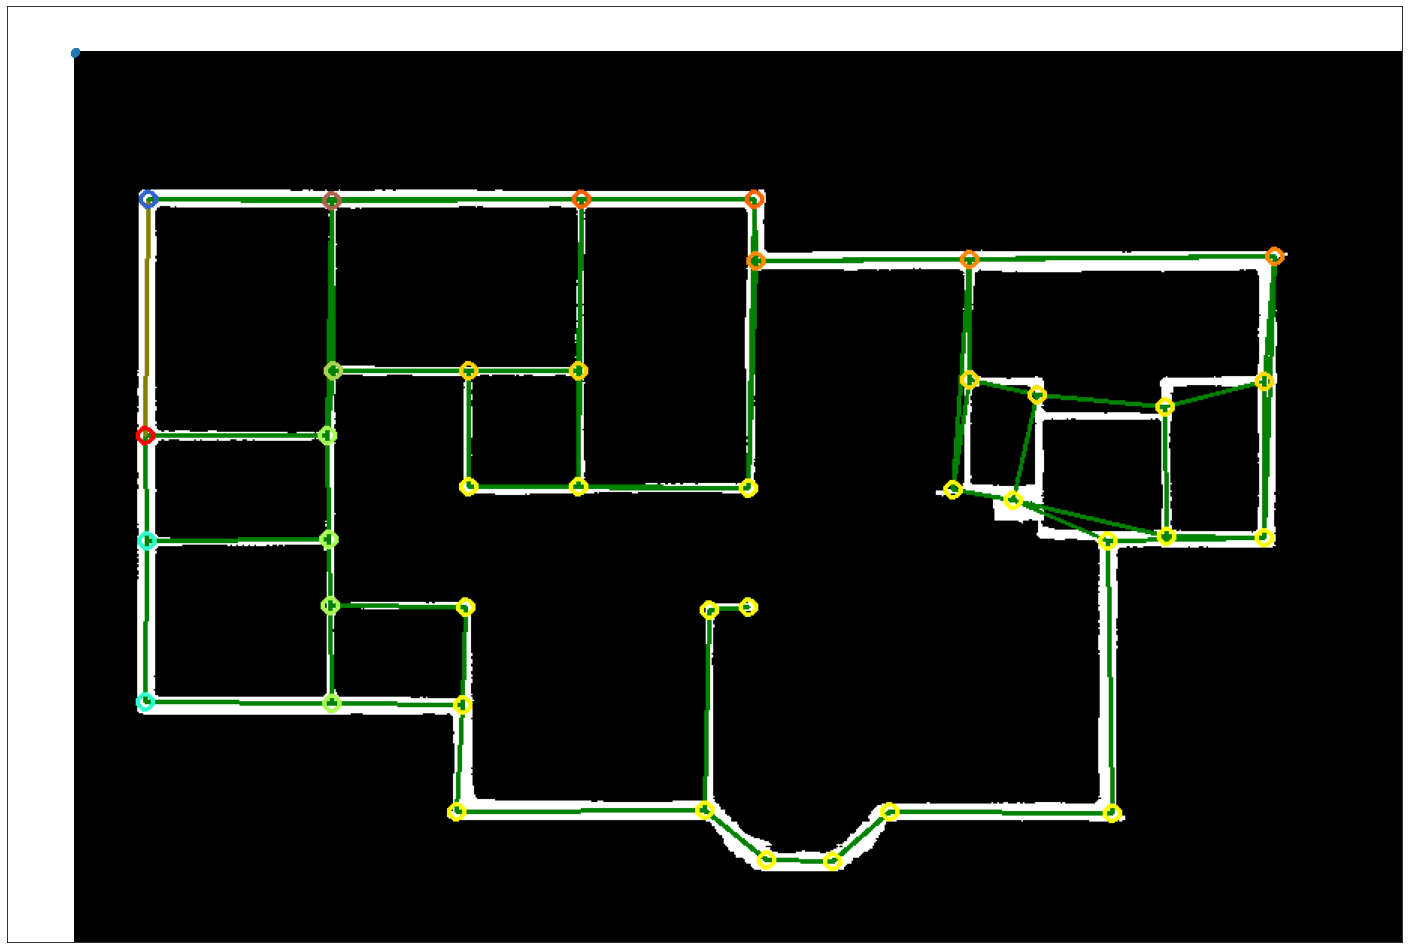

condition y: ((168.0, 255.0), (171.0, 99.0)) (172.0, 212.5)


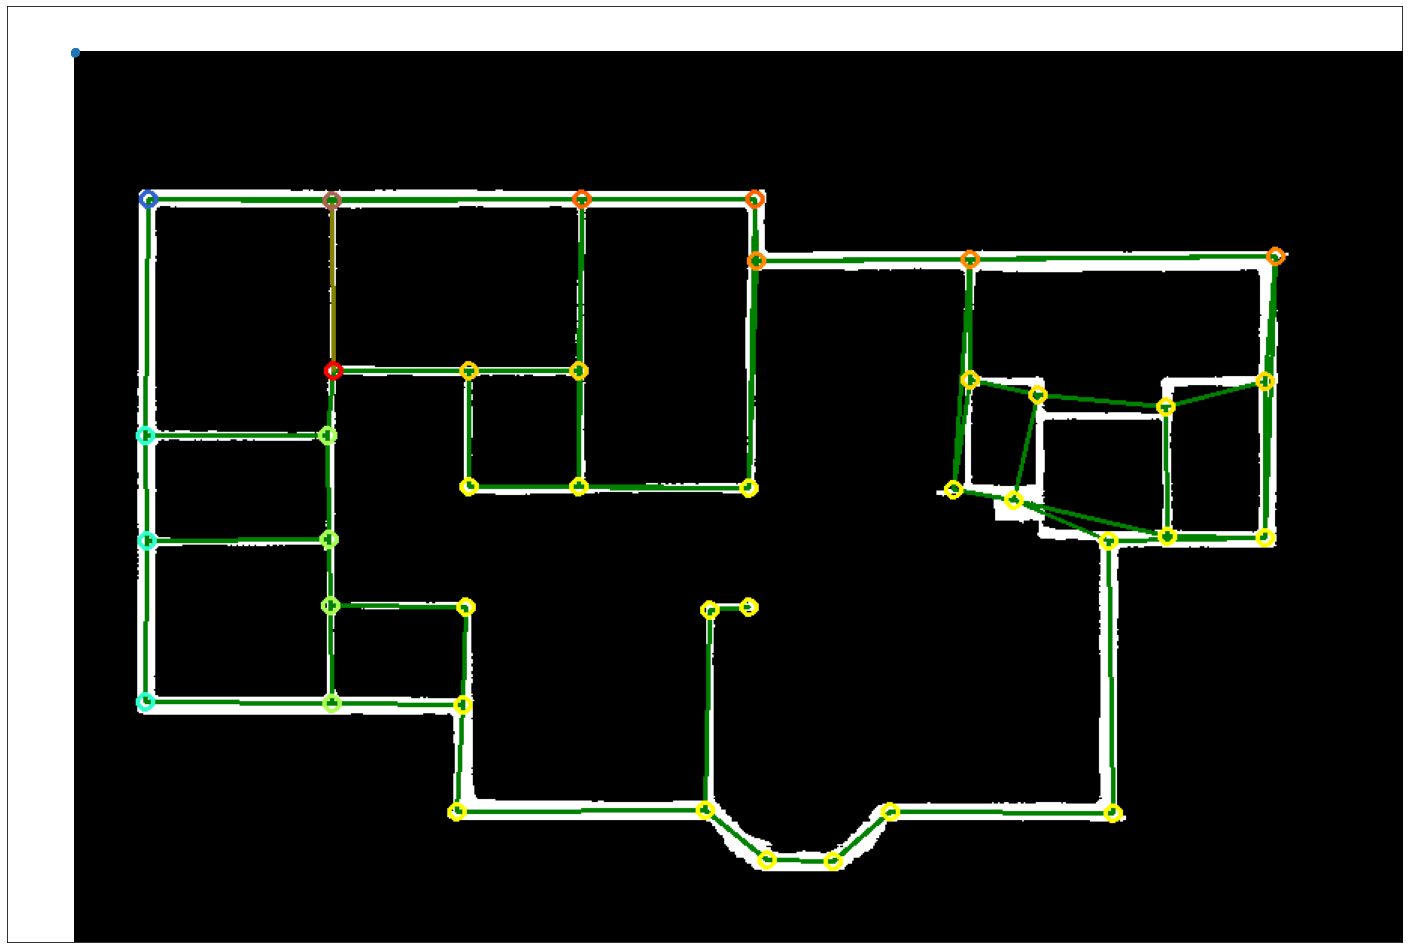

condition y: ((726.0, 322.0), (624.375, 298.5)) (687.0, 325.0)


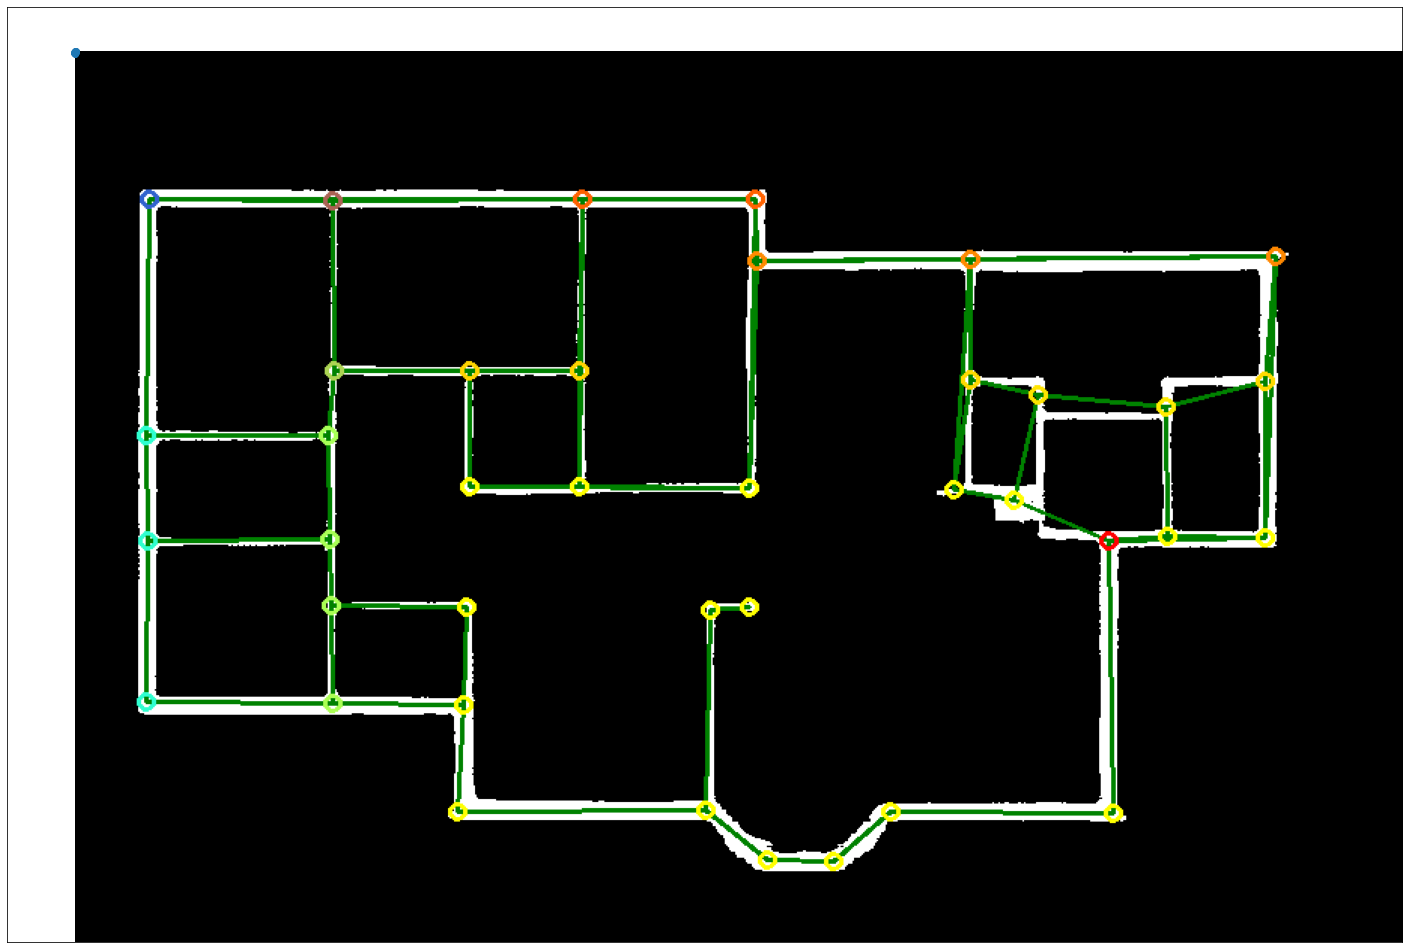

condition y: ((791.0, 323.5), (798.5, 136.5)) (791.5, 219.5)


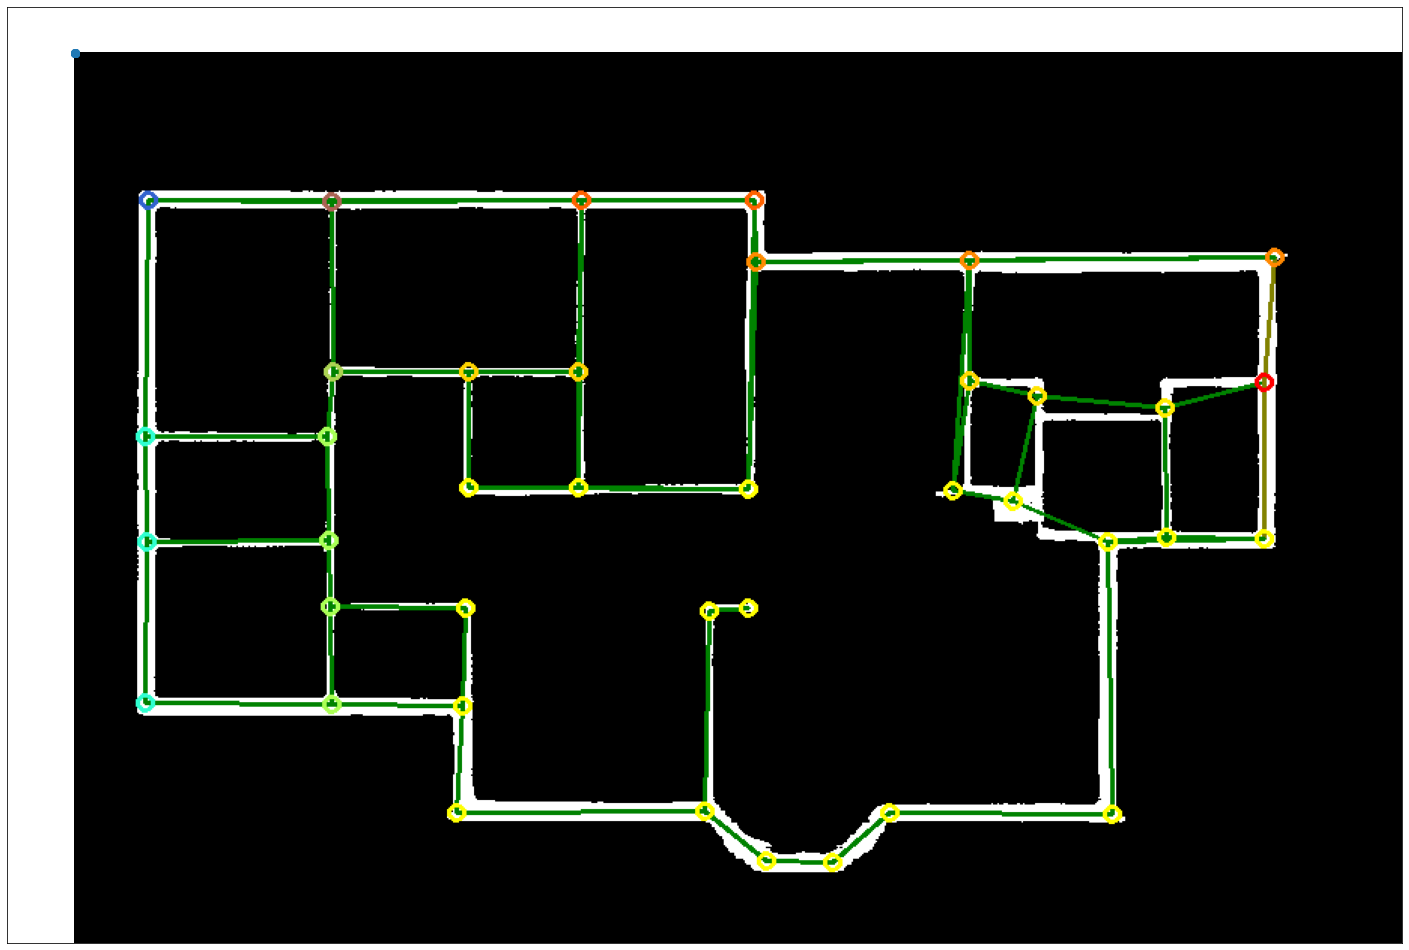

condition y: ((791.0, 323.5), (687.0, 325.0)) (726.0, 322.0)


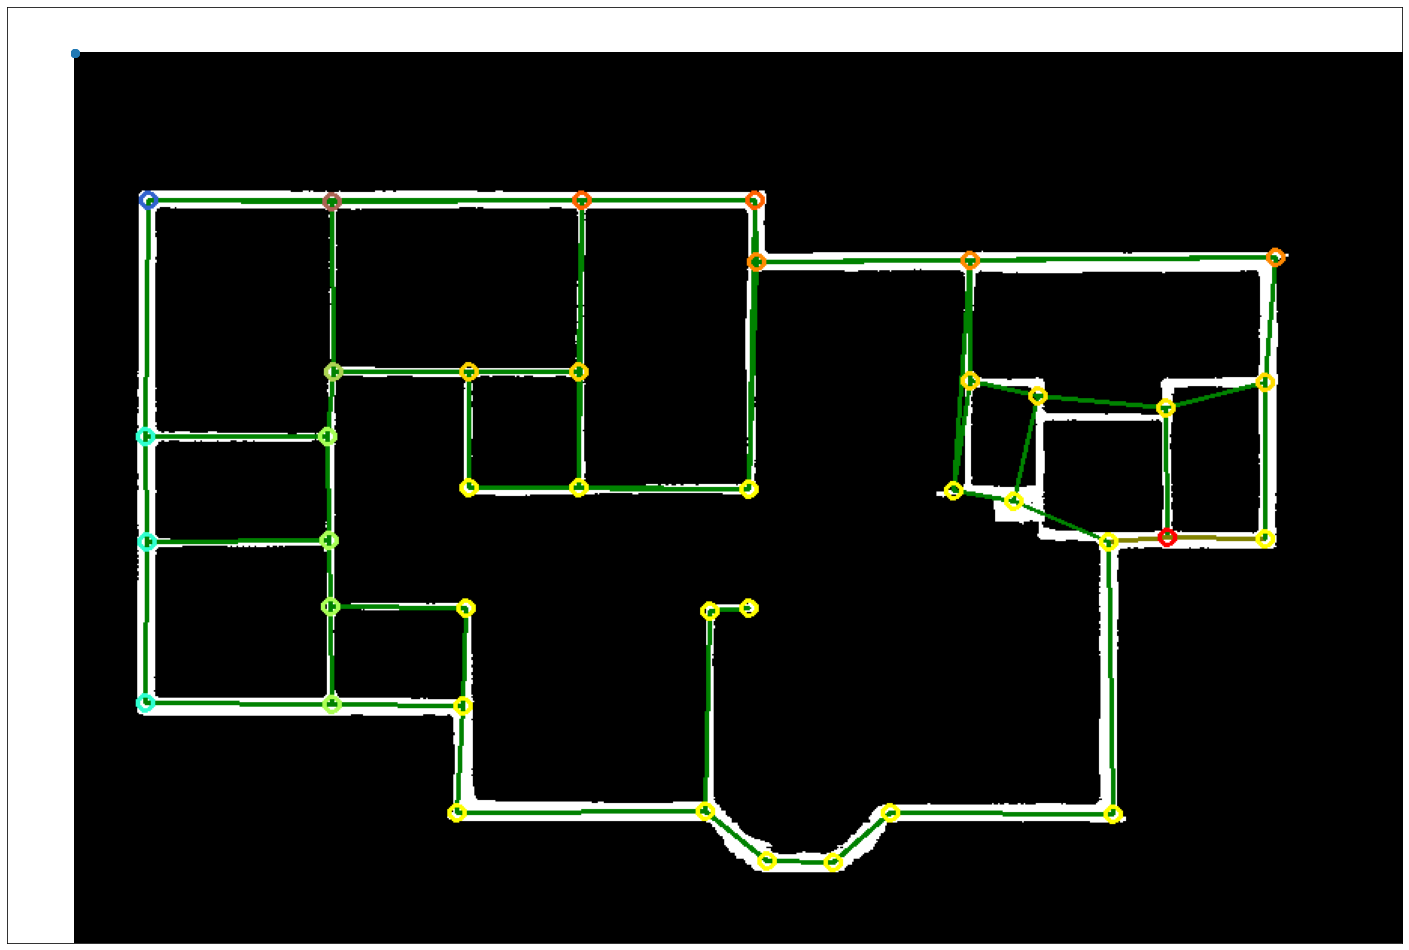

condition y: ((584.0, 291.0), (595.0, 138.5)) (595.0, 218.5)


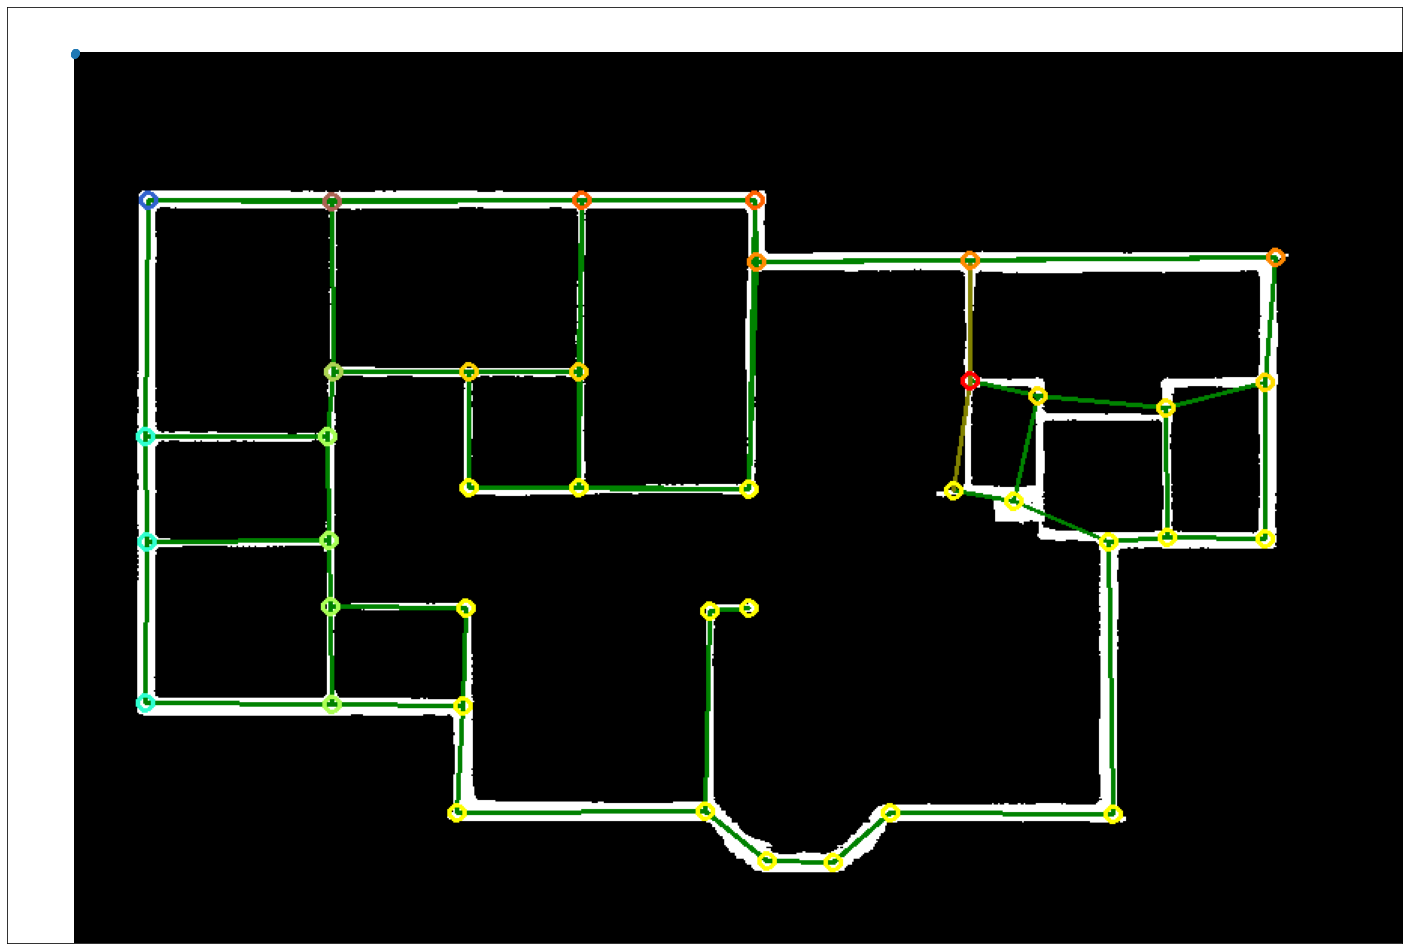

condition y: ((335.5, 212.5), (172.0, 212.5)) (262.0, 212.0)


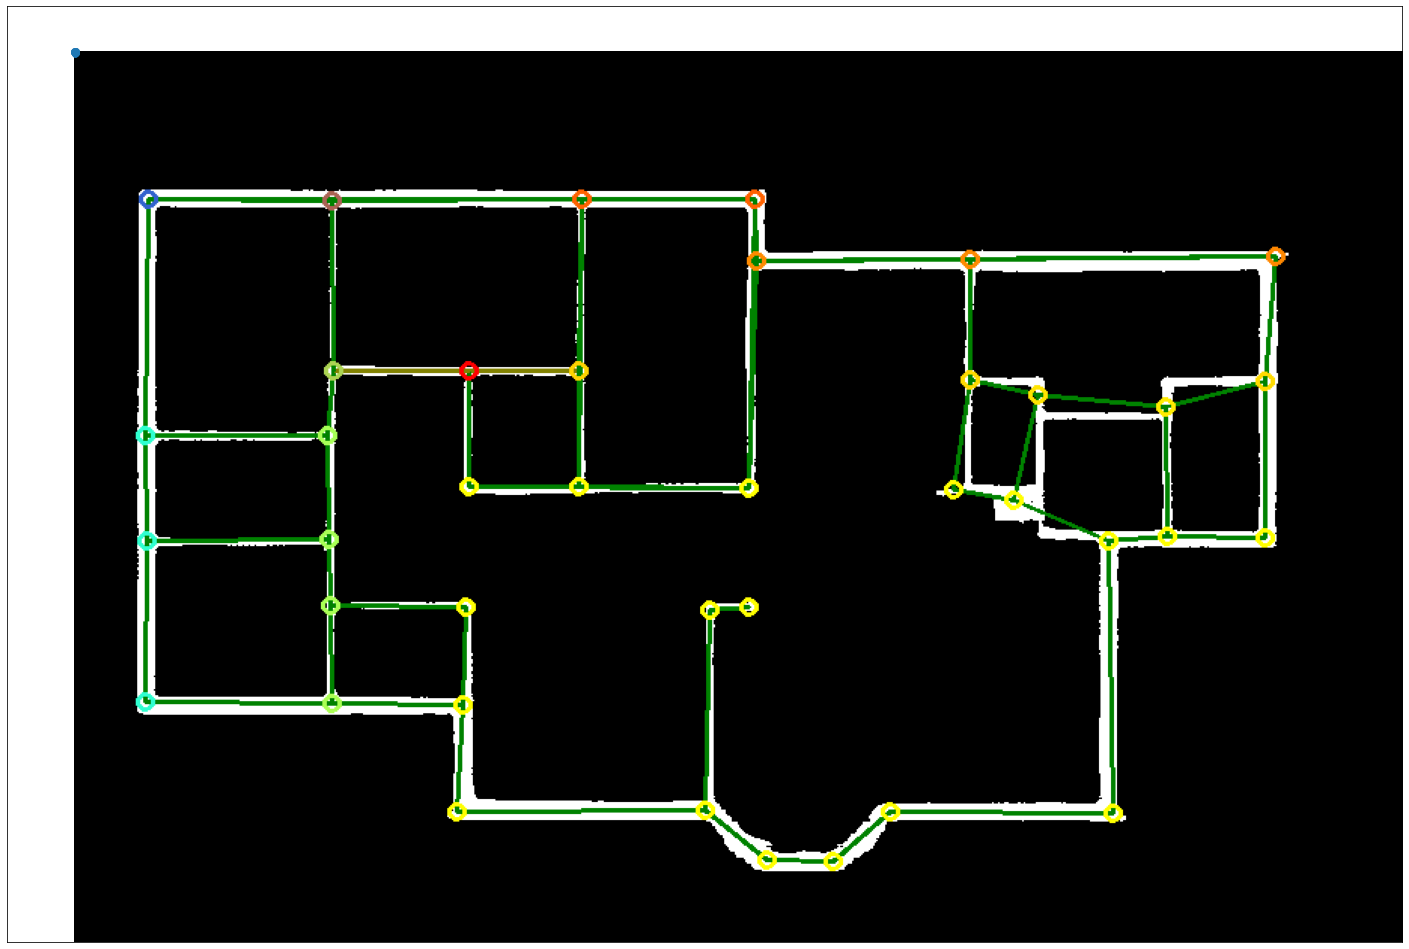

condition y: ((335.5, 289.5), (337.0, 98.0)) (335.5, 212.5)


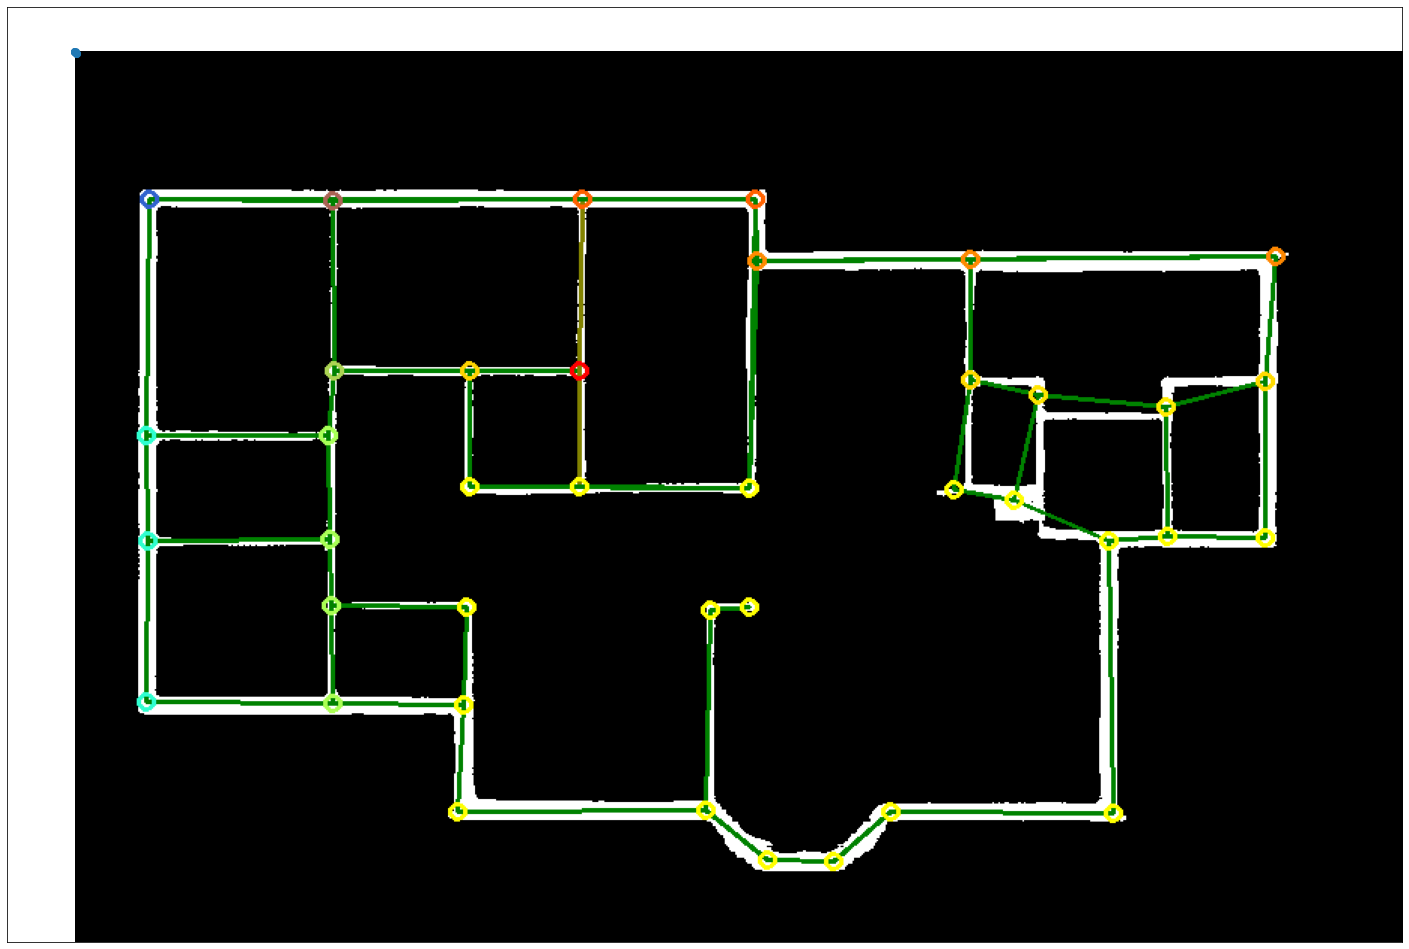

condition y: ((262.0, 289.0), (448.5, 290.0)) (335.5, 289.5)


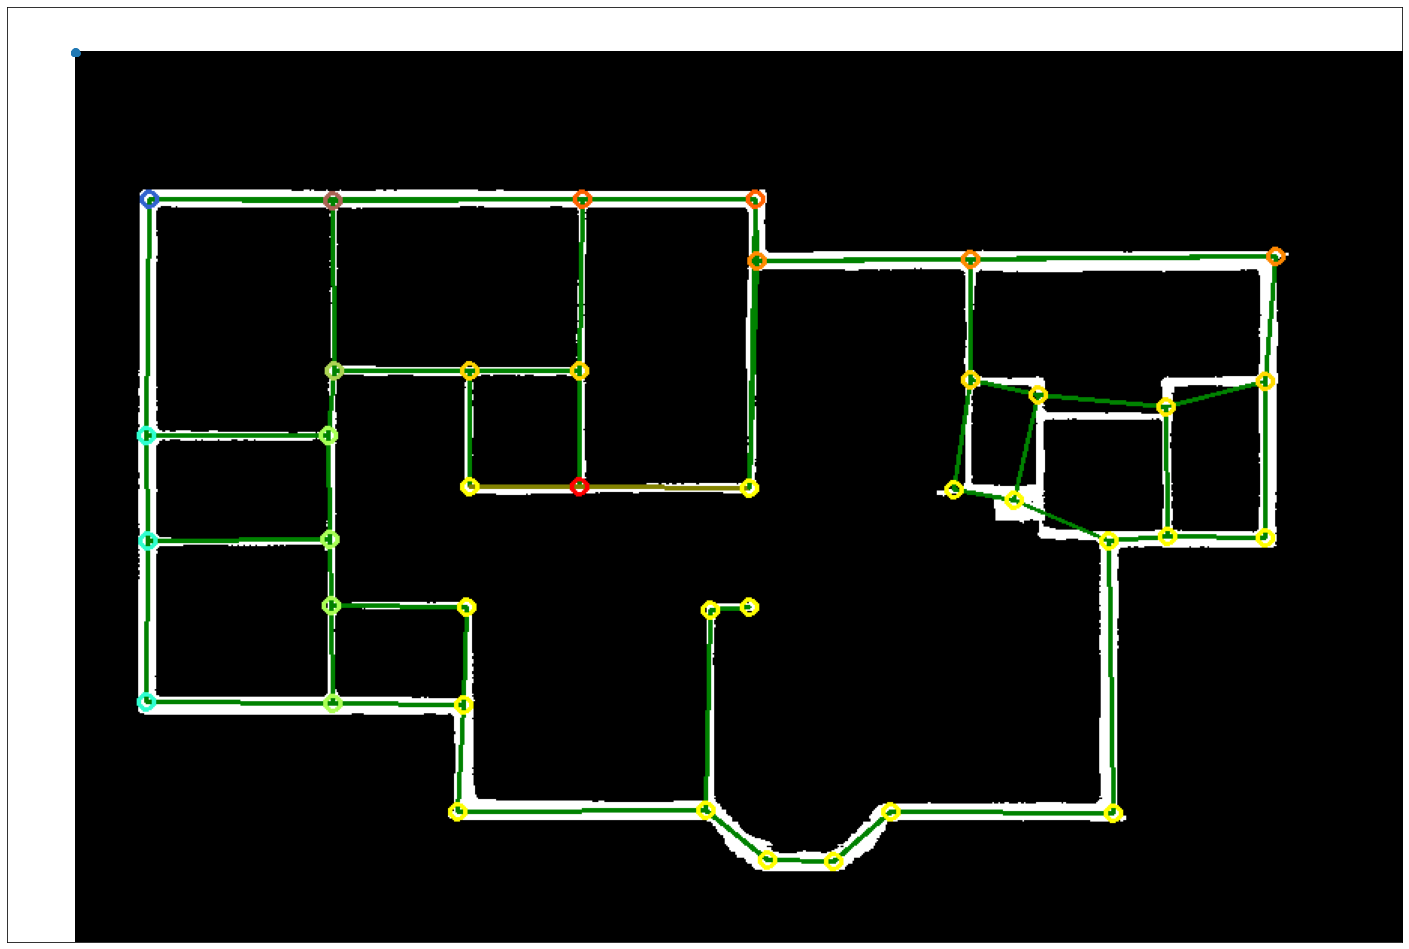

condition y: ((798.5, 136.5), (453.5, 139.5)) (595.0, 138.5)


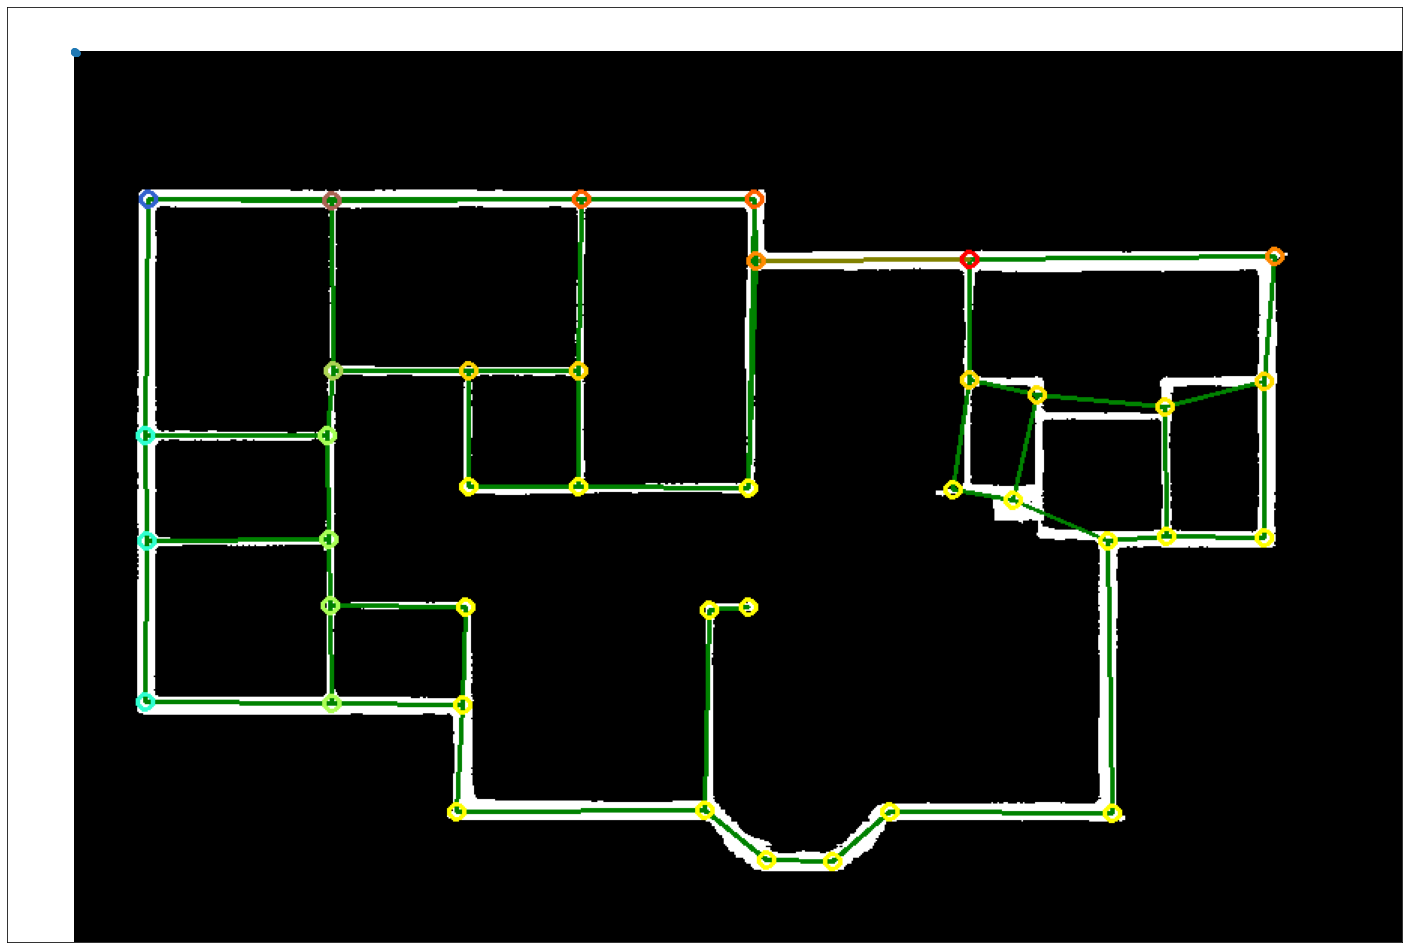

condition y: ((448.5, 290.0), (452.0, 98.5)) (453.5, 139.5)


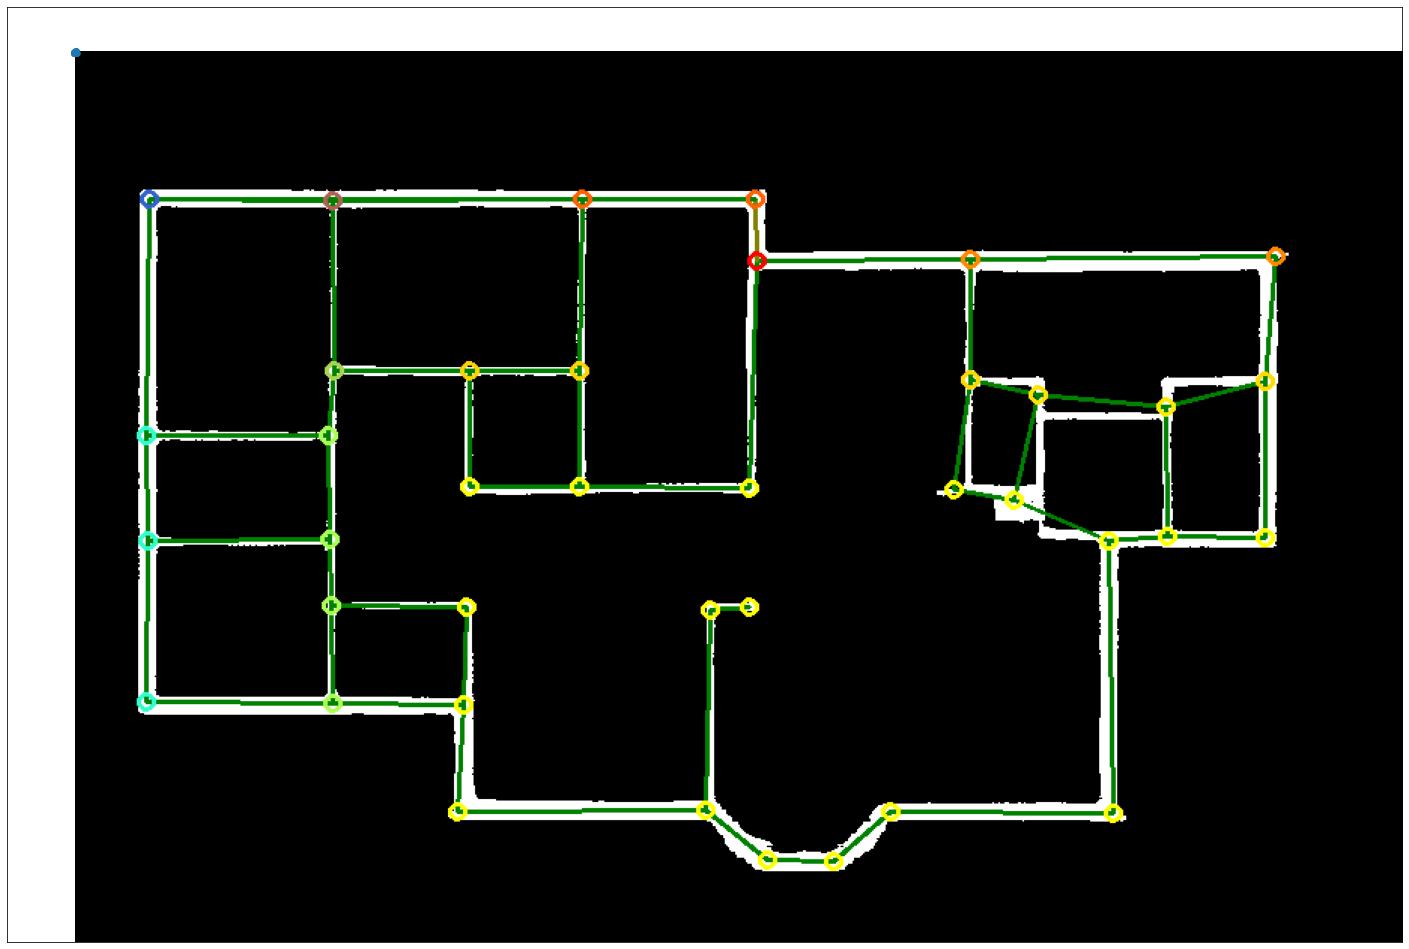

condition y: ((452.0, 98.5), (49.5, 98.5)) (337.0, 98.0)


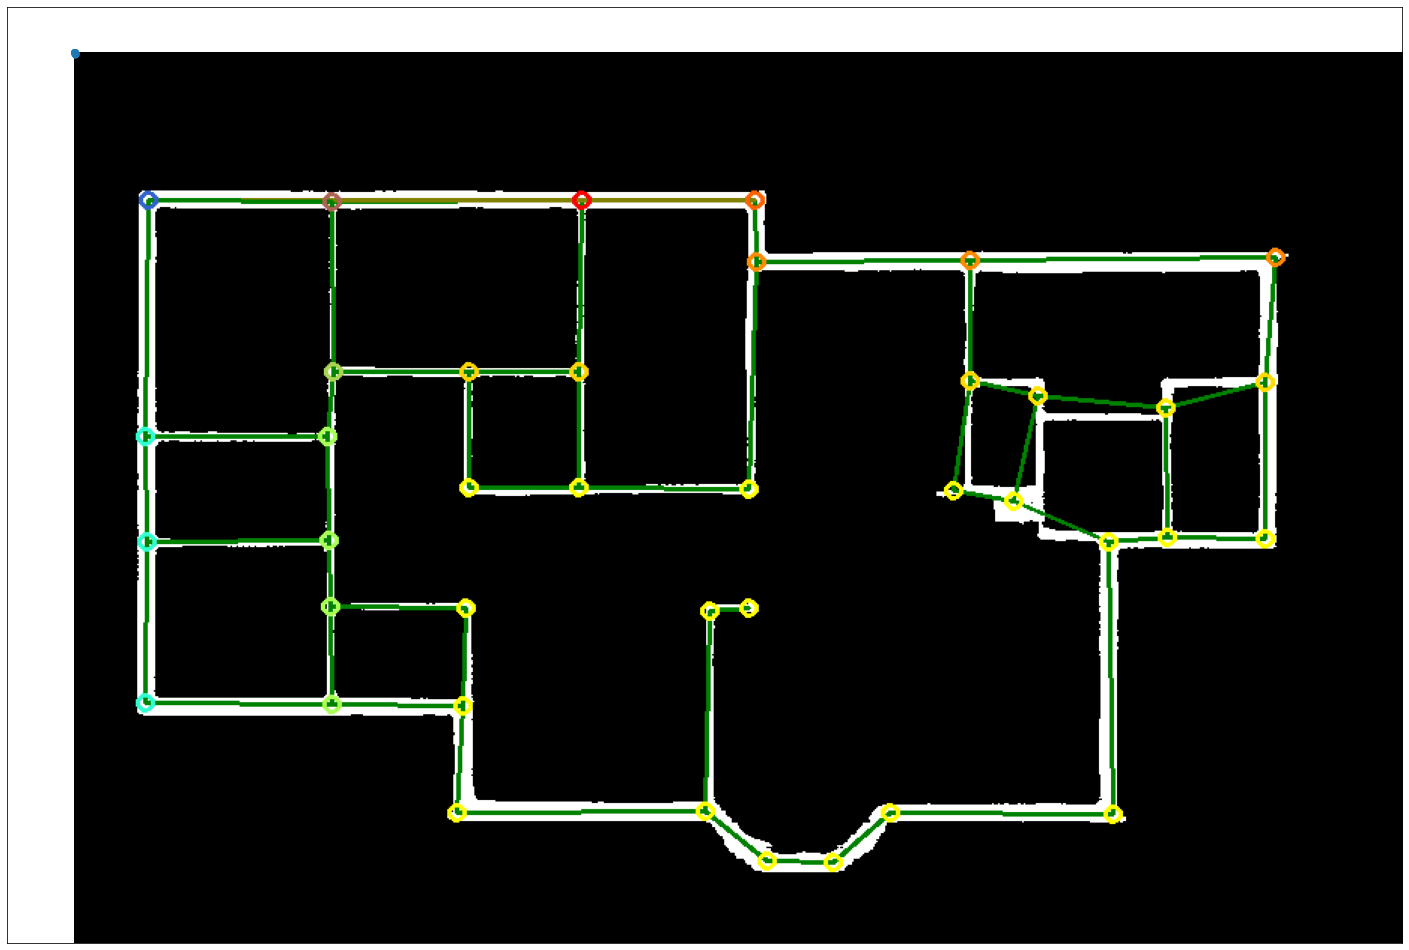

condition y: ((337.0, 98.0), (49.5, 98.5)) (171.0, 99.0)


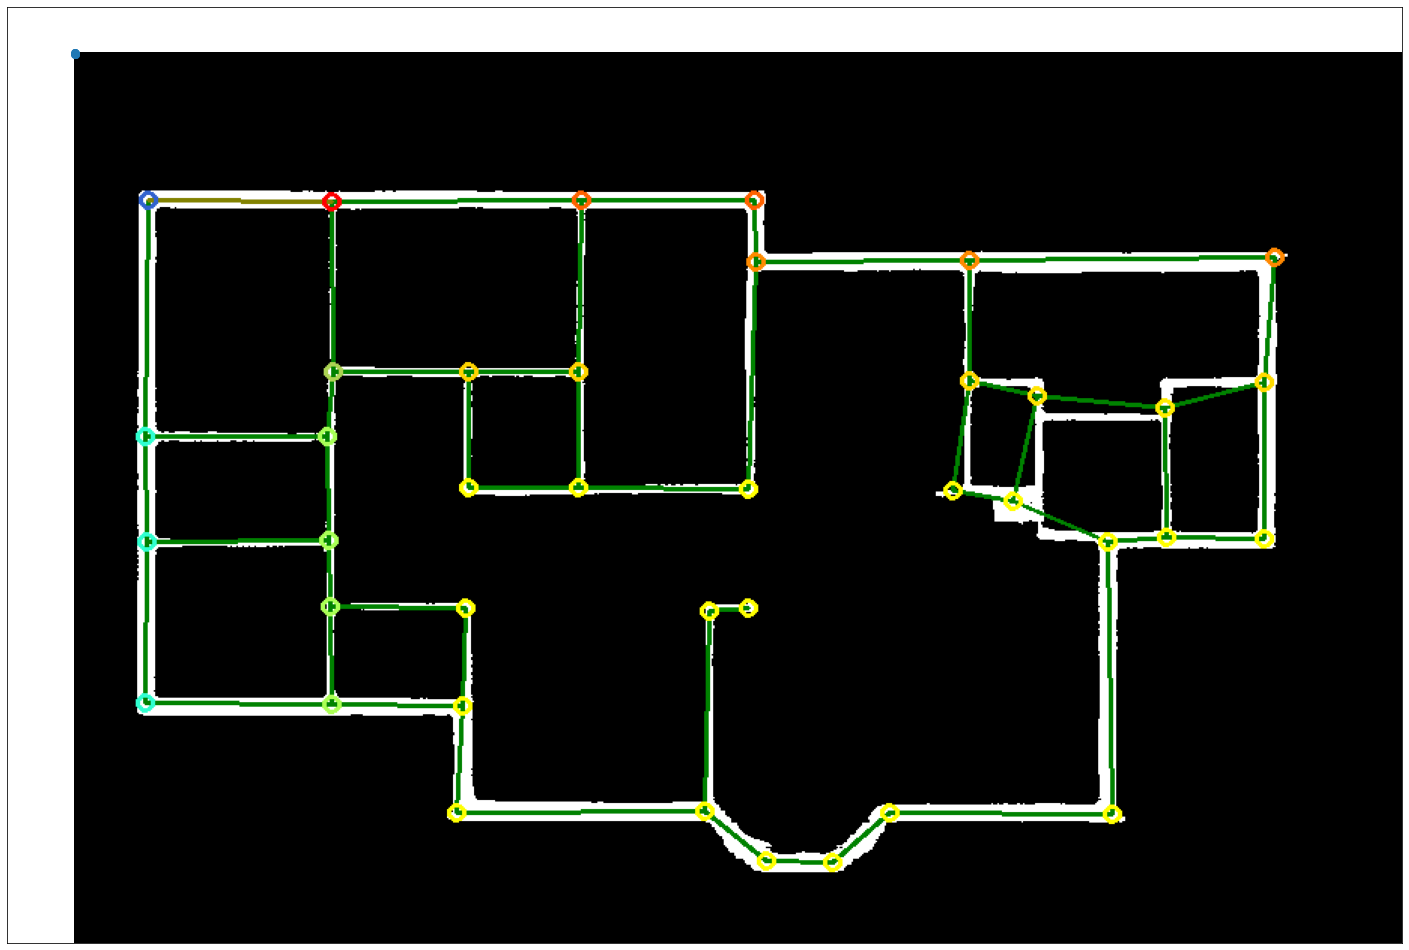

In [21]:
def draw_g(g, nodes_changed=None, edges_changed=None):
    im = np.expand_dims(wallPixels, axis=2).repeat(3, axis=2) 

    for e in g.edges:
        if edges_changed != None and e in edges_changed:
            im = cv.line(im, np.intp(e[0]), np.intp(e[1]), color=(130, 130, 0), thickness=2)
        else:
            im = cv.line(im, np.intp(e[0]), np.intp(e[1]), color=(0, 130, 0), thickness=2)

    for n in g.nodes:
        if nodes_changed != None and n in nodes_changed:
            im = cv.circle(im, np.intp(n), color=(255, 0, 0), radius=5, thickness=2)
        else:
            im = cv.circle(im, np.intp(n), color=(*tuple(int(e) for e in n), 255-int(n[0])), radius=5, thickness=2)

    plt.figure(figsize = (25,25))
    plt.imshow(im)
    nx.draw_networkx(g, with_labels = False, node_size = 30)
    plt.show()

def conditionX(n1, n2, delta=25):
    return distance(n1, n2) < delta

def conditionY(n, e, delta=20):
    p1, p2 = e
    p1, p2 = np.array(p1), np.array(p2)
    n = np.array(n)
    v1 = p1 - n
    v2 = p2 - n
    
    if np.dot(v1, v2) > 0: # if same direction
        return False
    
    return np.abs(np.cross(p2-p1,n-p1)/np.linalg.norm(p2-p1)) < delta    


def simplifyWalls(g):
    g = g.copy()
    
    # x
    redo = True
    while redo:
        redo = False
        contracted = False
        for i, n1 in enumerate(g.nodes):
            for j, n2 in enumerate(g.nodes):
                if i == j:
                    continue
                
                if conditionX(n1, n2):
                    g = nx.contracted_nodes(g, n1, n2, self_loops=False)
                    new_node = ((n1[0]+n2[0])/2, ((n1[1]+n2[1])/2))
                    g = nx.relabel_nodes(g, {n1: new_node})

                    contracted = True
                    redo = True
                    break
            
            if contracted:
                # sleep(0.25)
                #clear_output()
                print("condition x:", n1, n2)
                draw_g(g, [new_node])

                contracted = False
                break
    
    # y
    redo = True
    while redo:
        redo = False
        contracted = False
        for e in g.edges:
            for n in g.nodes:
                if n in e: # if the node is connected to the edge
                    continue
                
                if conditionY(n, e):
                    g.remove_edge(e[0], e[1])
                    g.add_edge(n, e[0])
                    g.add_edge(n, e[1])

                    contracted = True
                    redo = True
                    break
            
            if contracted:
                # sleep(0.25)
                #clear_output()
                print("condition y:", e, n)
                draw_g(g, [n], [(n, e[0]), (n, e[1])])
                contracted = False
                break
    
    return g

draw_g(G)
# Center line optimization
while True:#checkConditionX(G) or checkConditionY(G):
    G = simplifyWalls(G)
    break

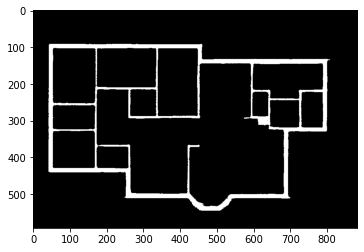

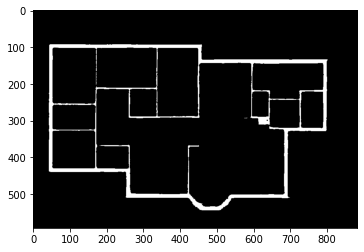

In [15]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

doors = cv.imread("walls.png")
doors_gray = cv.cvtColor(doors, cv.COLOR_BGR2GRAY)
doors_thresh = cv.threshold(doors_gray, 0, 255, cv.THRESH_OTSU)[1]
eroded = cv.erode(doors_thresh, np.ones((3, 3))) # hack, should iterate over walls and create masks with doors

plt.imshow(doors_gray, cmap="gray")
plt.show()

plt.imshow(eroded, cmap="gray")
plt.show()

In [ ]:
import recognition

recognition.get_opening_lines()

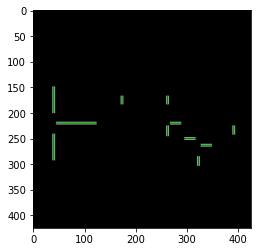

In [10]:
door_cnts, _ = cv.findContours(eroded, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

def boxToLine(box):
    if distance(box[0], box[1]) > distance(box[1], box[2]):
        return np.array([(box[0] + box[3])/2, (box[1] + box[2])/2])
    else:
        return np.array([(box[0] + box[1])/2, (box[2] + box[3])/2])

## DISPLAY
im = np.expand_dims(eroded, axis=2).repeat(3, axis=2)
for k, cnt in enumerate(door_cnts):
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    
    line = np.int0(boxToLine(np.int0(box)))
    
    im = cv.line(im, line[0], line[1], color=(0, 130, 0), thickness=2)
    
    plt.imshow(im)
plt.show()
##

lines = [np.int0(boxToLine(cv.boxPoints(cv.minAreaRect(cnt)))) for cnt in door_cnts]

In [65]:
import mystic
import scipy.spatial.distance as scidistance

walls = np.array(G.edges)

## DISPLAY
img = cv.imread("1_close_wall.png", cv.IMREAD_GRAYSCALE)
wallPixels = (cv.threshold(img, 0, 255, cv.THRESH_OTSU)[1])//255

#plt.imshow(wallPixels, cmap="gray")
#plt.show()
##

# cv.line has rounded corners, we use this instead to rasterize the walls
def wallToPoly(wall, width):
    """Generates the vertices to a given wall with two endpoints and a width."""
    v = wall[1] - wall[0]
    p = np.array([v[1], -v[0]])
    p = p / np.linalg.norm(p)
    
    p1 = wall[0] + p*(width/2)
    p2 = p1 + v
    p3 = p2 - p*width
    p4 = p3 - v
    
    return np.array([p1, p2, p3, p4])


def wallWidthIOU(wall, wallPixels, width):
    newImage = np.zeros(wallPixels.shape)
    rect = wallToPoly(wall, width)
    newImage = np.int0(cv.fillConvexPoly(newImage, points = np.array(rect, dtype=np.int32), color = 255))//255
    
    # crop to RoI
    x,y,w,h = cv.boundingRect(np.array(wallToPoly(wall, 100), dtype=np.int32))
    newImage = newImage[y:y+h, x:x+w]
    wallPixels = wallPixels[y:y+h, x:x+w]
    
#     plt.imshow(newImage, cmap="gray")
#     plt.show()
#     plt.imshow(newImage & wallPixels, cmap="gray")
#     plt.show()

#     plt.imshow(newImage | wallPixels, cmap="gray")
#     plt.show()

    i = np.sum(newImage & wallPixels)
    u = np.sum(newImage | wallPixels)
    return i/u
      
    return 1 - scidistance.jaccard(newImage.flatten(), wallPixels.flatten())

#     # dice coefficient
#     intersection = 2*np.sum(newImage & wallPixels)
#     union = np.sum(newImage) + np.sum(wallPixels)

def loss(wall, wallPixels, width):
    newImage = np.zeros(wallPixels.shape)
    rect = wallToPoly(wall, width)
    newImage = np.int0(cv.fillConvexPoly(newImage, points = np.array(rect, dtype=np.int32), color = 255))//255
    

    i = np.sum(newImage & wallPixels)
    neg = ~wallPixels + 2
    negative_i = np.sum(newImage & neg)
    return i - negative_i
    

def plotWallAndIOU(wall, wallPixels, width):
    newImage = np.zeros(wallPixels.shape)
    rect = wallToPoly(wall, width)
    newImage = np.int0(cv.fillConvexPoly(newImage, points = np.array(rect, dtype=np.int32), color = 255))//255
    
    plt.imshow(newImage, cmap="gray")
    plt.show()
    plt.imshow(newImage & wallPixels, cmap="gray")
    plt.show()
    plt.imshow(newImage | wallPixels, cmap="gray")
    plt.show()

loss(walls[0], wallPixels, 10)

247

0
[5.88345395]


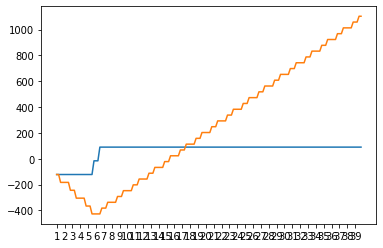

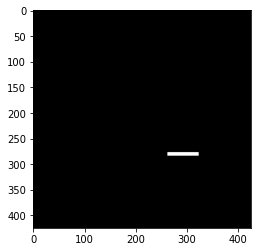

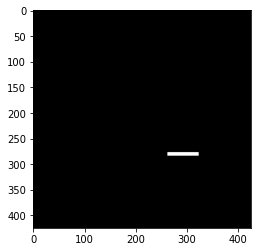

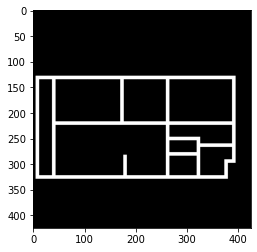

1
[6.19246545]


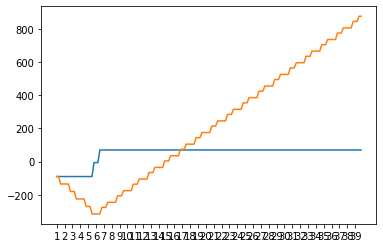

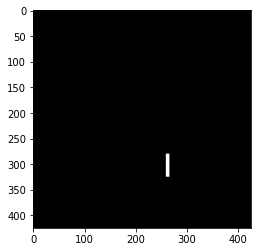

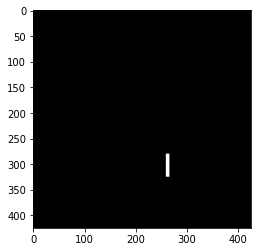

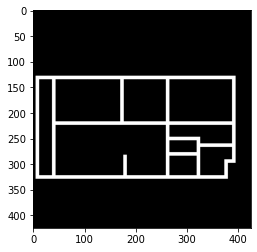

2
[5.75107459]


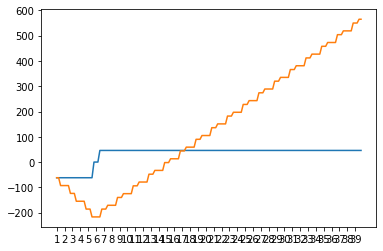

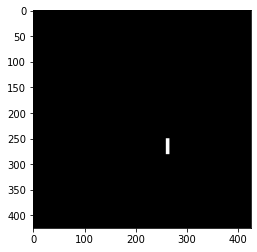

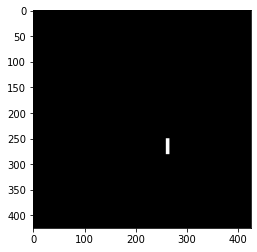

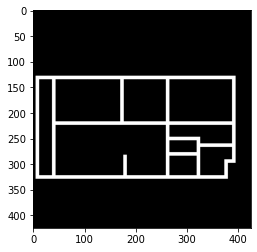

3
[5.97978173]


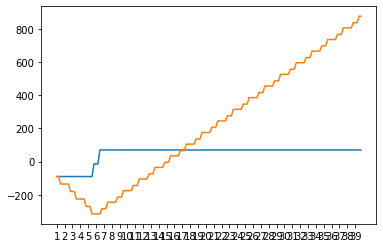

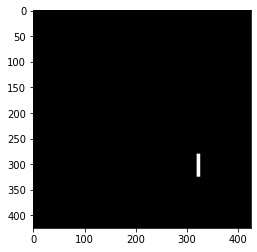

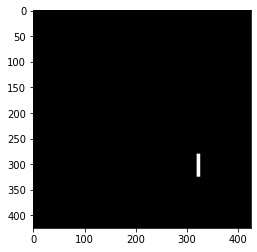

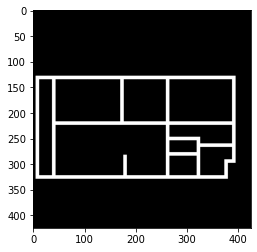

4
[5.96760166]


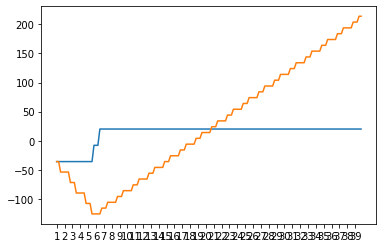

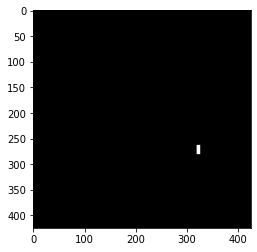

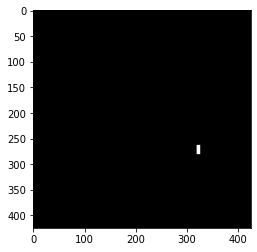

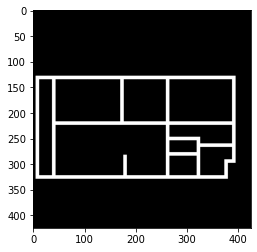

5
[8.41967199]


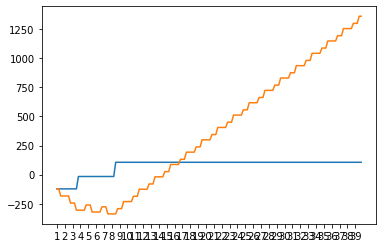

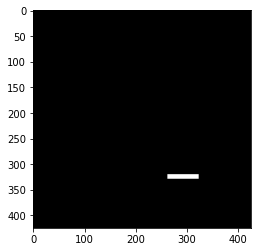

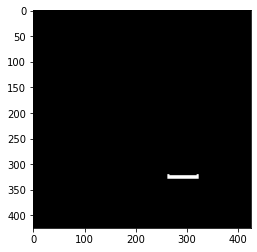

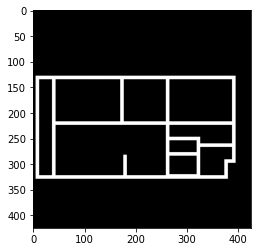

6
[9.65937825]


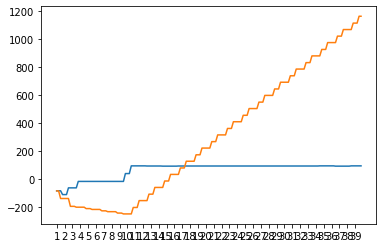

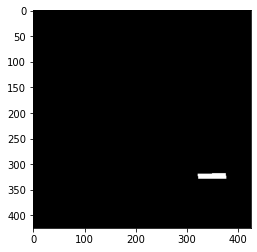

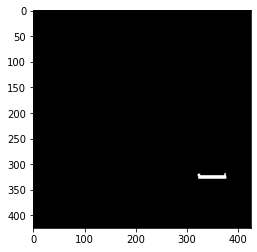

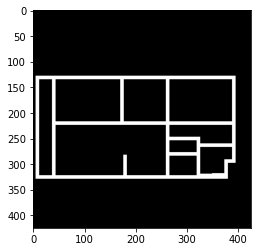

7
[8.1112006]


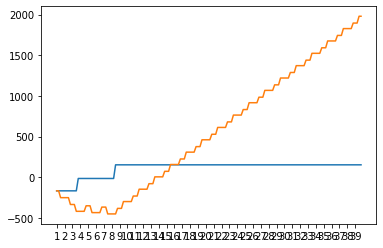

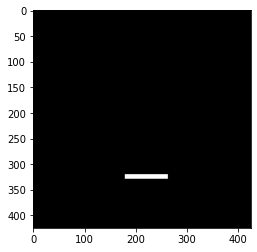

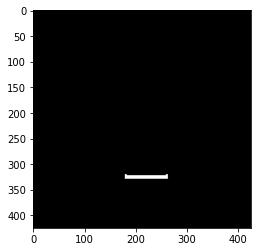

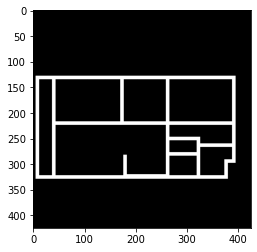

8
[5.80113719]


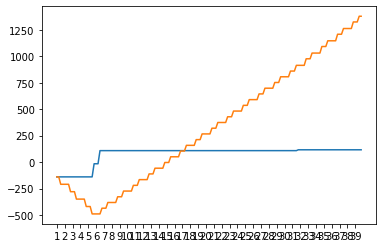

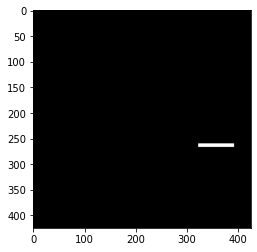

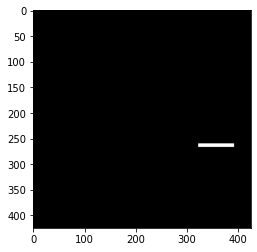

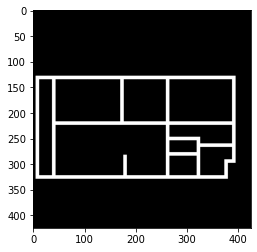

9
[6.42171958]


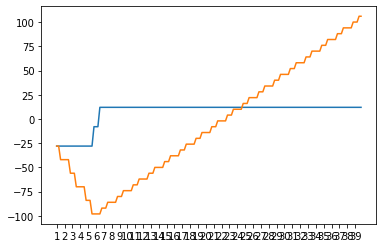

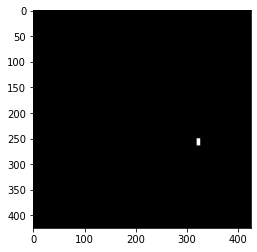

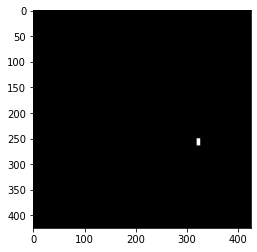

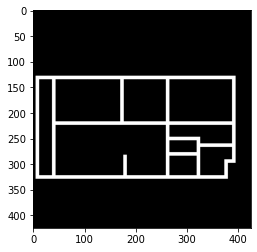

10
[6.44758613]


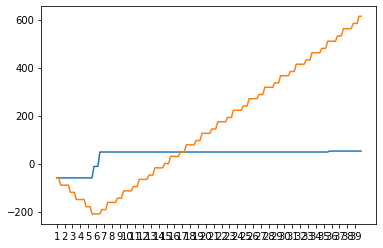

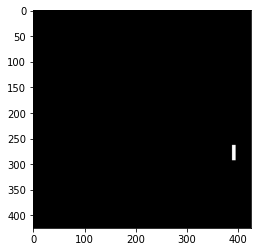

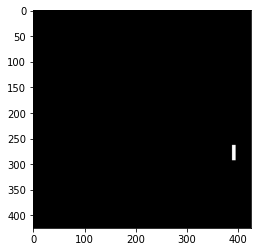

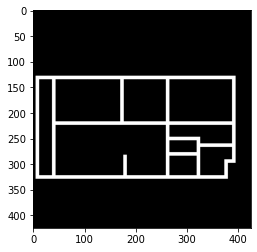

11
[5.65678769]


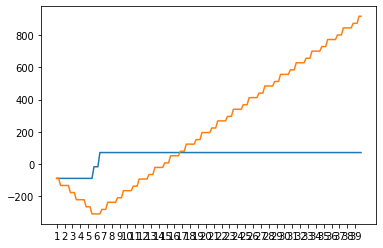

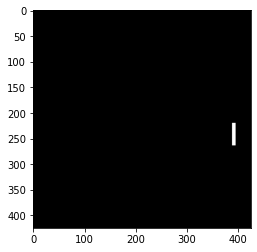

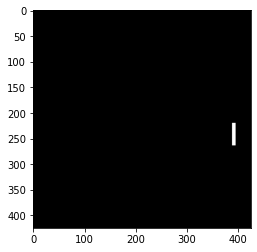

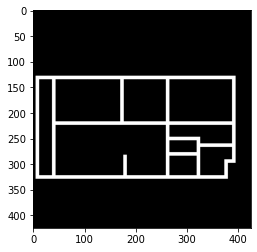

12
[8.17879737]


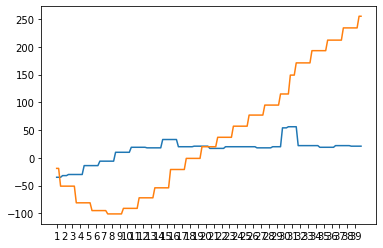

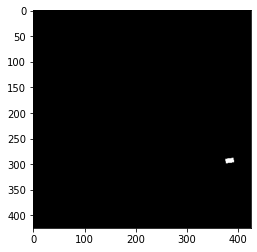

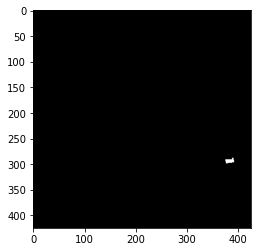

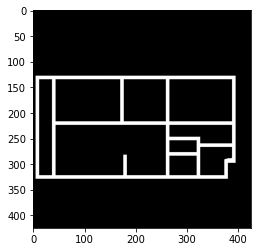

13
[5.94006792]


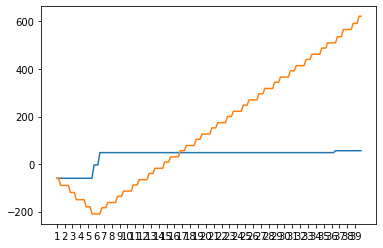

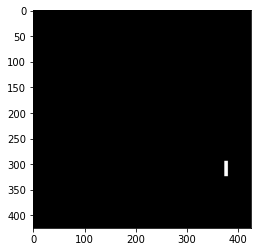

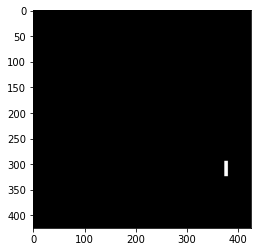

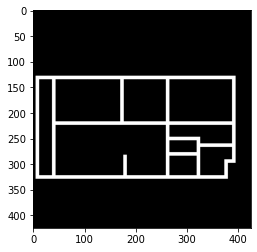

14
[7.28377714]


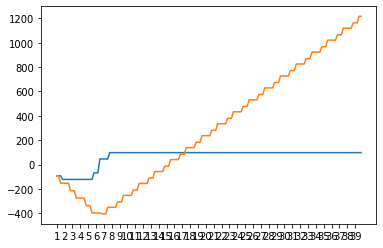

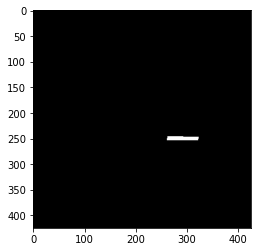

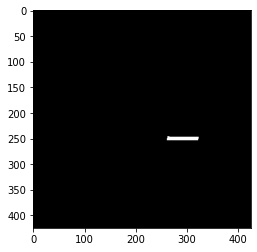

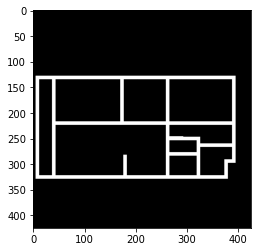

15
[5.61853203]


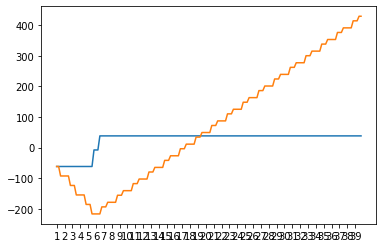

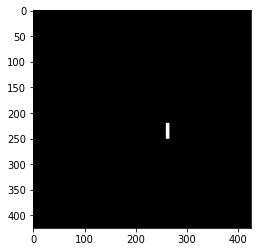

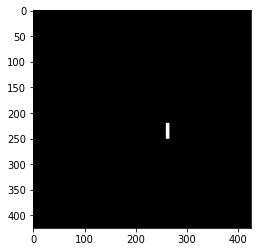

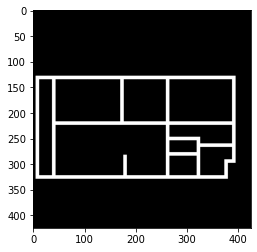

16
[6.12386574]


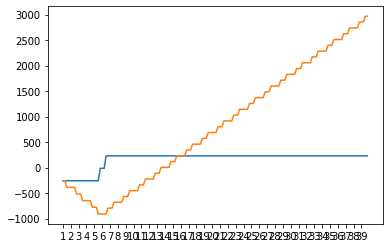

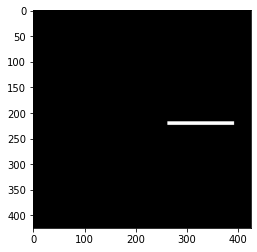

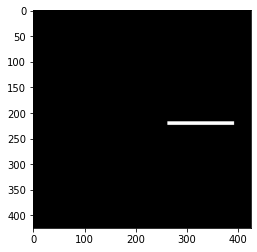

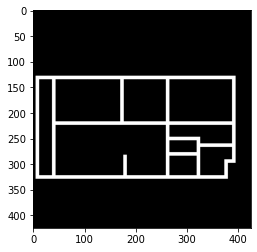

17
[5.99180323]


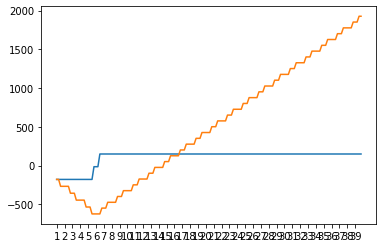

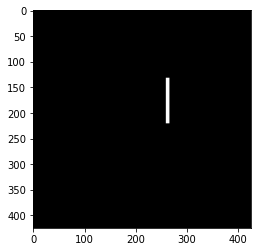

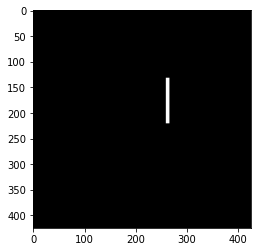

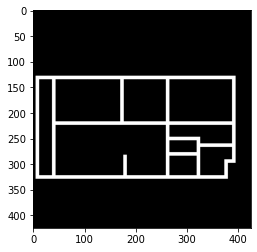

18
[8.28770722]


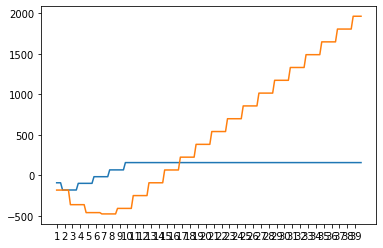

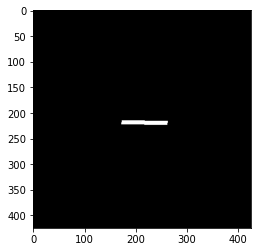

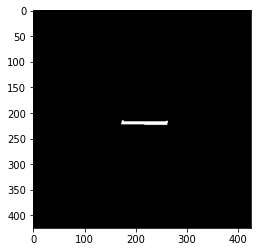

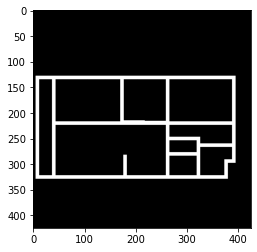

19
[6.34361643]


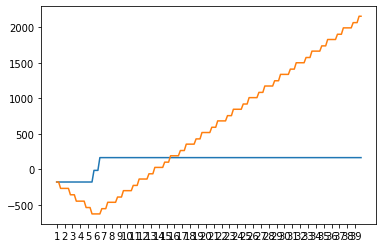

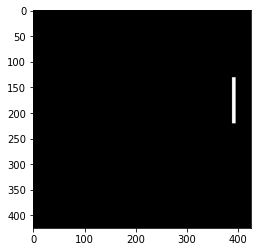

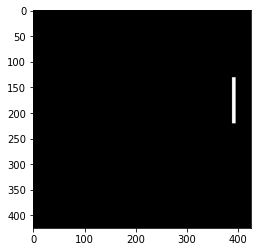

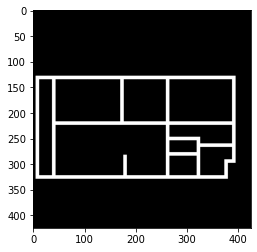

20
[6.13956245]


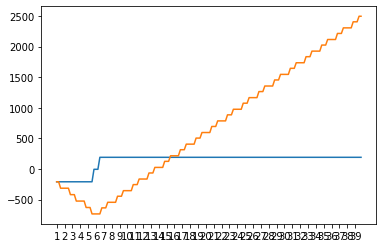

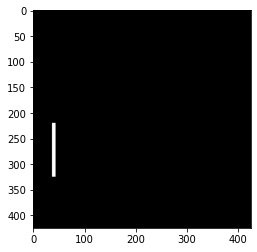

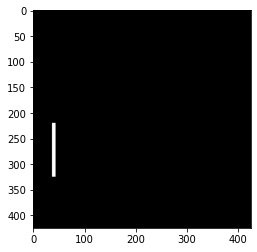

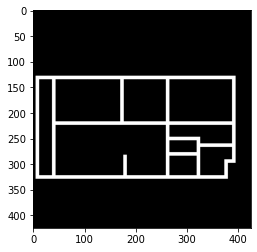

21
[7.72929168]


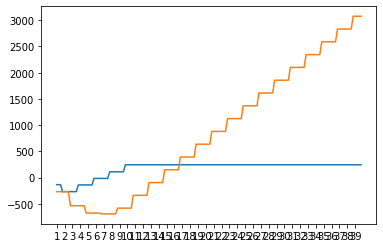

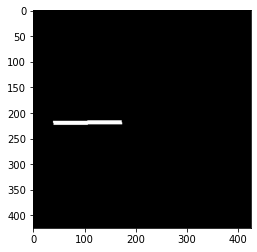

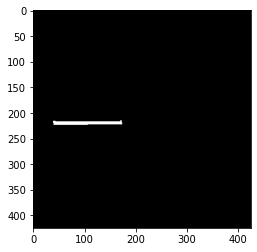

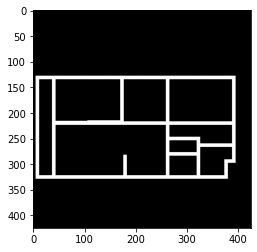

22
[5.99369678]


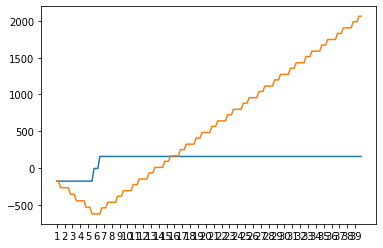

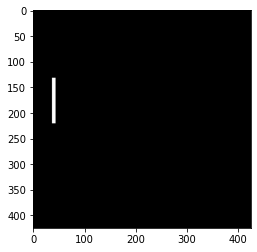

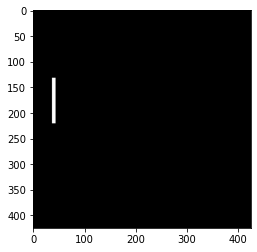

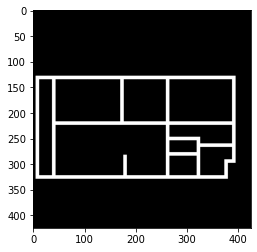

23
[5.7832313]


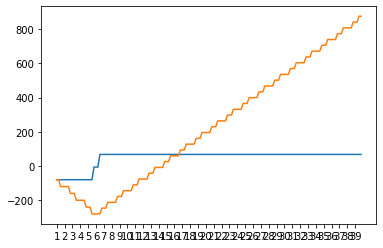

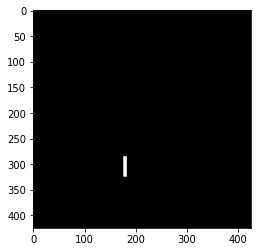

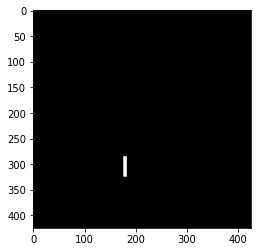

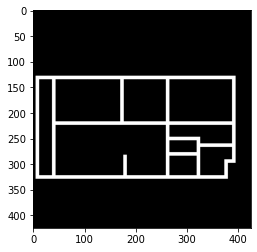

24
[8.23003367]


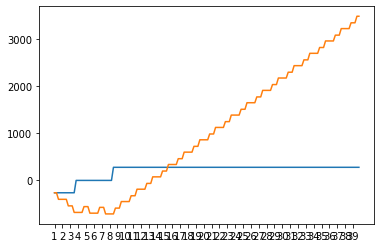

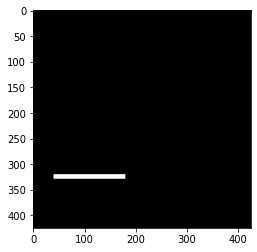

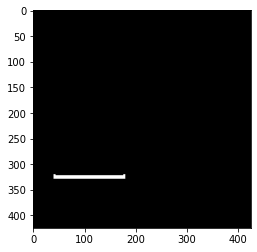

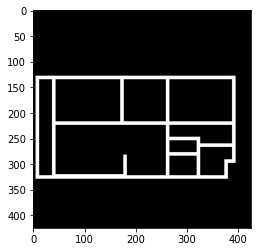

25
[9.17406575]


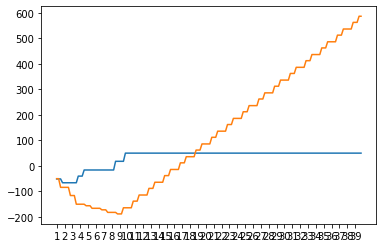

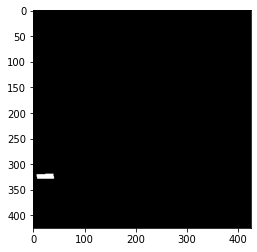

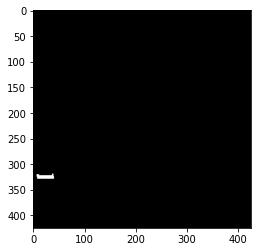

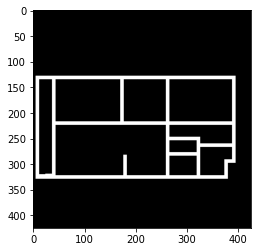

26
[7.04614021]


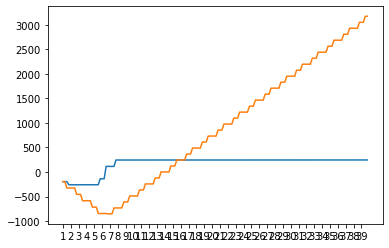

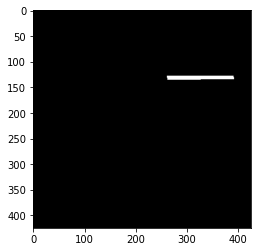

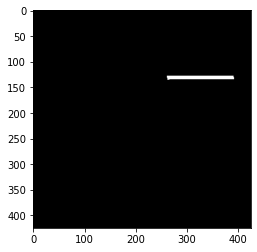

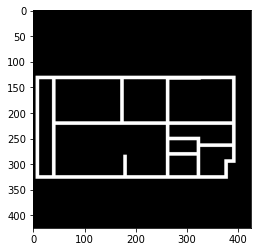

27
[7.42172487]


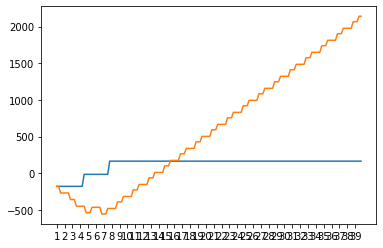

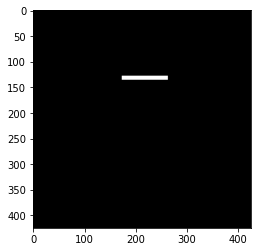

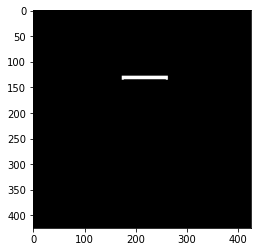

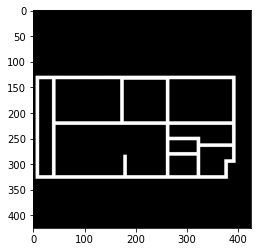

28
[6.40263905]


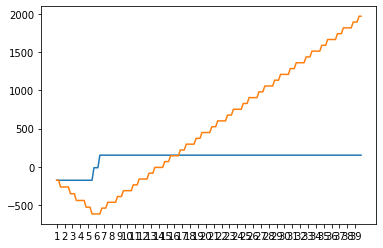

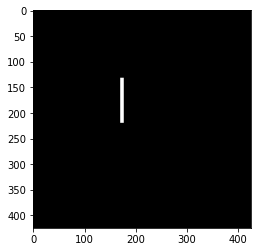

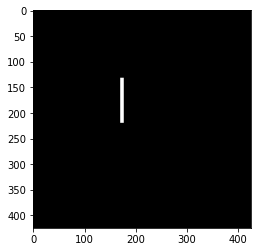

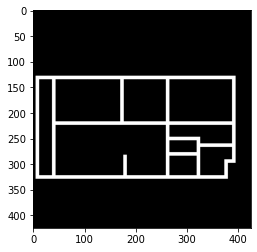

29
[6.90120833]


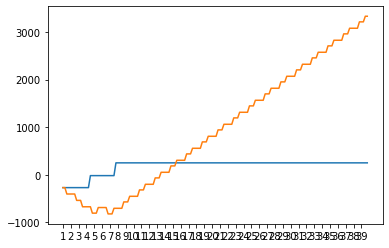

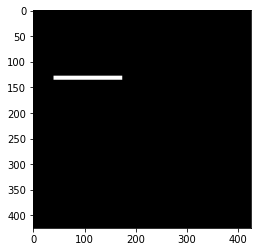

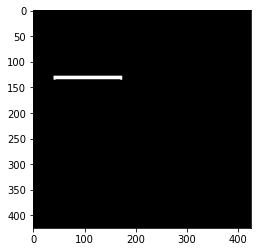

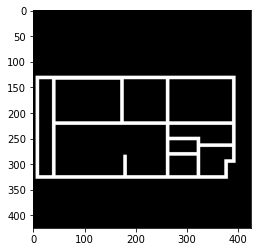

30
[7.31526826]


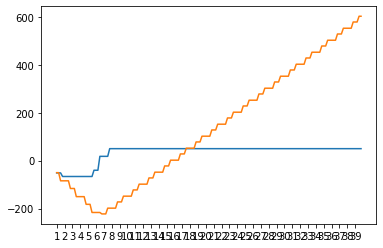

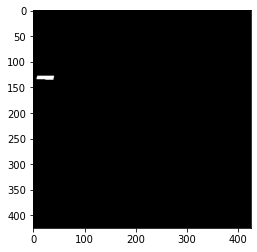

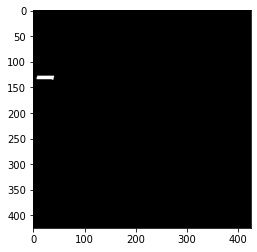

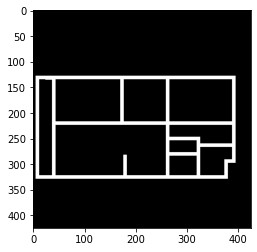

31
[5.83407117]


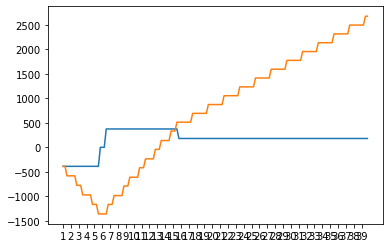

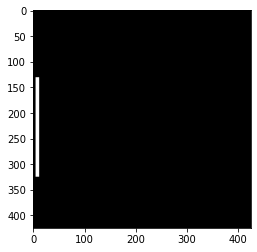

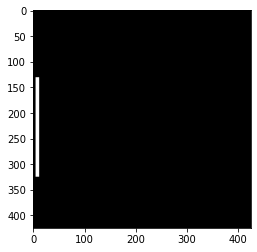

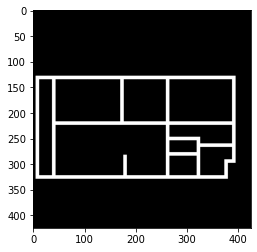

In [87]:
from scipy.optimize import differential_evolution, minimize

def jac(x, obj, h=1):
    return [(obj([x[0]+h]) - obj([x[0]-h]))/(h)]

def objective(x, wall, wallPixels):
    return -loss(wall, wallPixels, int(round(x[0])))

for i, w in enumerate(walls):
    print(i)
    o = lambda x: objective(x, w, wallPixels)
    solution = differential_evolution(o, bounds=[(1, 40)])
    #solution = minimize(lambda x: objective(x, walls[0], wallPixels), [20], jac=lambda x: jac(x, o, 1))
    print(solution.x)

    a = np.arange(1, 40, 0.25)
    y_values = np.array([o([x]) for x in a])
    jac_values = np.array([jac([x], o, 1) for x in a])
    plt.plot(a, jac_values)
    plt.plot(a, y_values)
    plt.xticks(np.arange(1, 40))
    plt.show()
    plotWallAndIOU(w, wallPixels, int(round(solution.x[0])))

In [13]:
n_comps, labels, stats, centroids = cv.connectedComponentsWithStats(doors_thresh, 8, cv.CV_32S)

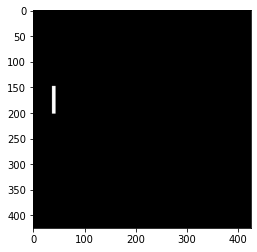

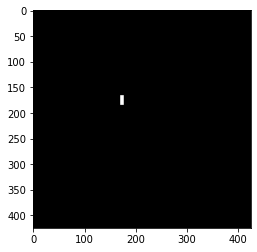

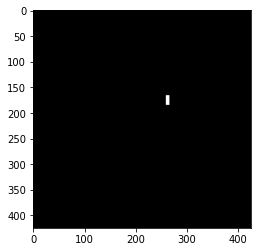

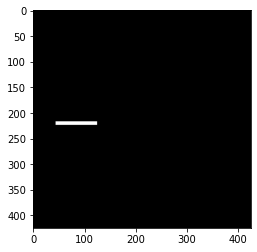

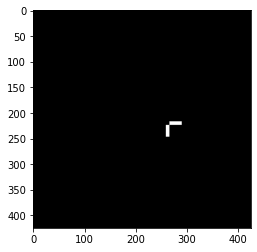

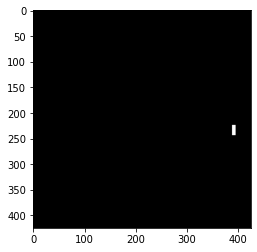

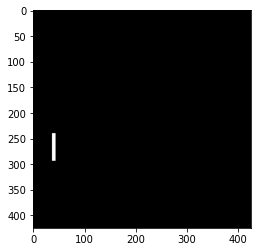

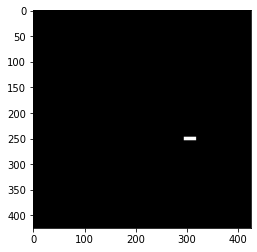

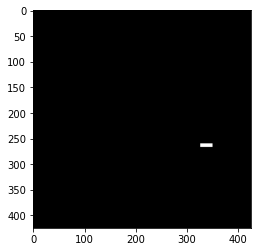

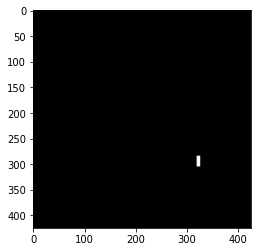

In [14]:
for l in range(1, n_comps):
    im = labels == l
    plt.imshow(im, cmap="gray")
    plt.show()

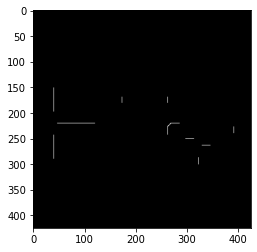

In [15]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

doors = cv.imread("1_close.png")
doors_gray = cv.cvtColor(doors, cv.COLOR_BGR2GRAY)
doors_thresh = cv.threshold(doors_gray, 0, 255, cv.THRESH_OTSU)[1]
skeleton = cv.ximgproc.thinning(doors_thresh)

plt.imshow(skeleton, cmap="gray")

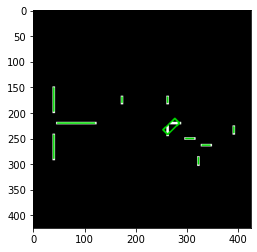

In [16]:
door_cnts, _ = cv.findContours(skeleton, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
im = np.expand_dims(eroded, axis=2).repeat(3, axis=2) 
for k, cnt in enumerate(door_cnts):
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    im = cv.drawContours(im, [box], 0, (0, 220, 0), 2)
    
plt.imshow(im)